# Análise das medidas do cálculo coerência do conjunto de dados SQUAD 2 P(1,0%).

Realiza a análise dos cálculos de medida de coerência utilizando BERT no SQUAD 2 P(1,0%).

Utiliza os arquivos resultantes da medição de `X` documentos perturbados e `Y` top K predições.

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento.
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [7]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [9]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )    
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )  
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )     
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    estrategia_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Biblioteca de limpeza de tela


In [10]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [11]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4  Identificando o ambiente Colab

In [12]:
# Se estiver executando no Google Colaboratory.
import sys

# Retorna true ou false se estiver no Google Colaboratory.
IN_COLAB = 'google.colab' in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [13]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [14]:
# Import das bibliotecas.
import torch

def getDeviceGPU():
    """
      Retorna um dispositivo de GPU se disponível ou CPU.
    
      Retorno:
        `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [15]:
# Recupera o device com GPU ou CPU
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Memória

Memória disponível no ambiente

In [16]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [17]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Mounted at /content/drive


# 2 Parametrização

## Gerais

In [18]:
# Nome base das saidas do projeto
NOME_BASE_SAIDA = "MedidaCoerenciaSquad2_P_v1"

# Definição dos parâmetros a serem avaliados

## Específicos

Parâmetros do modelo

## Nome do diretório dos arquivos de dados

In [19]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "SQUAD2_P"

## Define o caminho para os arquivos de dados

In [20]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 Resultado do Cálculo das Medidas de (In)coerência

In [21]:
CONJUNTO_DADOS = 'SQuAD 2'

## 3.1 Carrega os dados das medidas 

### 3.1.1 Função que encontra a melhor mensuração

In [22]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []

  listaTempoTotal = []  
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:                      
                    for estrategia_medida in ESTRATEGIA_MEDIDA:  
                      for filtro_palavra in FILTRO_PALAVRAS:  
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [23]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []
    
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:                      
                    for estrategia_medida in ESTRATEGIA_MEDIDA:  
                      for filtro_palavra in FILTRO_PALAVRAS:  
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [24]:
# Parametros para o Cohebert Manual
DOCUMENTOS_PERTURBADOS = [1, 20, 100]
TOP_K_PREDICAO = [1, 20, 100]

# Recupera os melhores parâmetros
MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracao(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [25]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Modelo BERT           :", MELHOR_MODELO_BERT, 
      "\n  Tamanho BERT          :", MELHOR_TAMANHO_BERT, 
      "\n  Modelo                :", MELHOR_MODELO,     
      "\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Equação               :", MELHOR_EQUACAO_MEDIDA,
      "\n  Estratégia            :", MELHOR_ESTRATEGIA_MEDIDA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Modelo BERT           : _BERTimbau 
  Tamanho BERT          : _large 
  Modelo                : _pretreinado 
  Documentos Perturbados: 100 
  Top k predição        : 100 
  Equação               : _com 
  Estratégia            : _mean 
  Filtro                : _tap 
  Resultado             : 0.7151656095842143 
  Medida                : ceuc 
  Tempo execução        : 1:37:20

Lista dos resultados ranqueados
1 = ['_BERTimbau', '_large', '_pretreinado', 100, 100, '_com', '_mean', '_tap', 0.4791754756871036, 0.7151656095842143, 0.6731782945736434, 'ceuc', 0.7151656095842143, '1:37:20']
2 = ['_BERTimbau', '_large', '_pretreinado', 100, 100, '_ctx', '_mean', '_tap', 0.4688794926004228, 0.708999295278365, 0.6642565186751234, 'ceuc', 0.708999295278365, '0:18:28']
3 = ['_BERTimbau', '_large', '_pretreinado', 100, 100, '_adj', '_mean', '_tap', 0.4493587033121917, 0.7067512332628612, 0.6650810429880197, 'ceuc', 0.7067512332628612, '0:16:00']
4 =

### Escolhendo um resultado diferente do melhor

In [26]:
# Carrega somente as melhores medidas para Np = 20
MELHOR_DOCUMENTOS_PERTURBADOS = 20
MELHOR_TOP_K_PREDICAO = 20

# Parametros para melhor de 100
# MELHOR_MODELO_BERT = '_BERTimbau'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 100
# MELHOR_TOP_K_PREDICAO = 100
# MELHOR_EQUACAO_MEDIDA = '_com'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_tap'
# MELHOR_RESULTADO = 0.7151656095842143
# MELHOR_MEDIDA_GERAL_STR = 'ceuc'
# MELHOR_TEMPO = '1:37:20'
# lista_resultados = []
 
# Parametros para melhor de 20
# MELHOR_MODELO_BERT = '_BERTimbau'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 20
# MELHOR_TOP_K_PREDICAO = 20
# MELHOR_EQUACAO_MEDIDA = '_ctx'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_ssw'
# MELHOR_RESULTADO =0.6106060606060606
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = 0:01:49'
# lista_resultados = []

# Parametros para melhor de 1
# MELHOR_MODELO_BERT = '_BERTimbau'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_EQUACAO_MEDIDA = '_ctx'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_ssw'
# MELHOR_RESULTADO = 0.6744186046511628
# MELHOR_MEDIDA_GERAL_STR = 'ccos'
# MELHOR_TEMPO = '0:00:11'
# lista_resultados = []

### 3.1.2 Função que carrega os parâmetros do resultado da melhor mensuração

In [27]:
def carregaMedidasCompactada(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO

  # Diretório do drive do arquivo
  DIRETORIO_MEDICAO_DRIVE = DIRETORIO_DRIVE + "validacao_medicao_palavra/Medicao/"

  # Diretório local para salvar o arquivo
  DIRETORIO_MEDICAO_LOCAL = DIRETORIO_LOCAL + "Medicao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_MEDICAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_MEDICAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_MEDICAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_MEDICAO_LOCAL))

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO_DRIVE):        

    # Caminho completo do arquivo compactado no drive
    NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO = DIRETORIO_MEDICAO_DRIVE + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO)

    # Caminho completo do arquivo compactado no local
    NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO)

    # Caminho completo do arquivo no local
    NOME_ARQUIVO_MEDICAO_LOCAL = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".csv"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL:", NOME_ARQUIVO_MEDICAO_LOCAL)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO):
      
      # Copia arquivo da medição compactado do google drive para o drive local
      !cp "$NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO"  
                        
      # Descompacta arquivo da medição compactado no drive local
      !unzip -o -j -q "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO" -d "$DIRETORIO_MEDICAO_LOCAL"

      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_LOCAL, sep=';')

      #print('Registros: ', len(dados_medida))
      print('Arquivo encontrado e carregado')        

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

In [28]:
def carregaMedidas1(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO + ".csv"

  # Diretório para salvar o arquivo.
  DIRETORIO_MEDICAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Medicao/"
  # print("DIRETORIO_MEDICAO:", DIRETORIO_MEDICAO)

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO):    

    # Caminho completo do arquivo
    NOME_ARQUIVO_MEDICAO_COMPLETO = DIRETORIO_MEDICAO + NOME_ARQUIVO_MEDICAO
    # print("NOME_ARQUIVO_MEDICAO_COMPLETO:", NOME_ARQUIVO_MEDICAO_COMPLETO)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_COMPLETO):
      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_COMPLETO, sep=';')

      print('Registros: ', len(dados_medida))

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [29]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [30]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/SQUAD2_P


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [31]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [32]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [33]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 1419.
INFO:root:TERMINADO ORIGINAIS POS: 1419.


In [34]:
lista_documentos_originais.sample(5)

id  \
99    5726a764f1498d1400e8e639   
1151  57313d51e6313a140071cd75   
104   57070b1490286e26004fc840   
791   5a8639c1b4e223001a8e74ee   
279   572a1e9daf94a219006aa801   

                                              sentencas  \
99    ['A que Montini se encarregou de responder em ...   
1151  ['Para que ação foi necessária a assistência d...   
104      ['Em que a definição do Censo não se baseia?']   
791   ['Qual a porcentagem de sites no Tajiquistão q...   
279   ['Qual governante reconheceu os otomanos em 15...   

                                              documento  respondivel  
99    A que Montini se encarregou de responder em no...            1  
1151  Para que ação foi necessária a assistência do ...            1  
104          Em que a definição do Censo não se baseia?            1  
791   Qual a porcentagem de sites no Tajiquistão que...            0  
279     Qual governante reconheceu os otomanos em 1547?            1

In [35]:
lista_documentos_originais_pos.sample(5)

id  \
667   56de7dd64396321400ee296b   
466   5acf6cd977cf76001a684df8   
1151  57313d51e6313a140071cd75   
543   5726f7b0708984140094d74b   
347   56fa413bf34c681400b0c031   

                                          pos_documento  
667   [[['Que', 'tipos', 'de', 'programas', 'não', '...  
466   [[['Qual', 'é', 'a', 'temperatura', 'média', '...  
1151  [[['Para', 'que', 'ação', 'foi', 'necessária',...  
543   [[['Quando', 'foi', 'criado', 'o', 'EFCC', 'da...  
347   [[['Sobre', 'qual', 'porcentagem', 'de', 'made...

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [36]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 1419.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 1419.


#### Criando dados indexados originais

In [37]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_indexado = lista_documentos_originais.copy()

# Especifica o(s) campo(s) indexado(s)
lista_documentos_originais_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_indexado.head()

sentencas  \
id                                                                            
5a8d89b5df8bba001a0f9afb  [O formulário Edna do Link é mais rápido do qu...   
5acfa4e977cf76001a6856da  [Quais dois ministros lutaram pelo poder em An...   
5ad19f40645df0001a2d213b  [O que Irving Langmuir descobriu que aumentari...   
56ce66aeaab44d1400b8875a  [Em que ano a célula solar de silício cristali...   
5acdabd307355d001abf48f0  [Desde que ano foi levantada a idéia de um tún...   

                                                                  documento  \
id                                                                            
5a8d89b5df8bba001a0f9afb  O formulário Edna do Link é mais rápido do que...   
5acfa4e977cf76001a6856da   Quais dois ministros lutaram pelo poder em Anne?   
5ad19f40645df0001a2d213b  O que Irving Langmuir descobriu que aumentaria...   
56ce66aeaab44d1400b8875a  Em que ano a célula solar de silício cristalin...   
5acdabd307355d001abf48f0  Desde que ano foi levantada a idéia de um túne...   

                          respondivel  
id                                     
5a8d89b5df8bba001a0f9afb            0  
5acfa4e977cf76001a6856da            0  
5ad19f40645df0001a2d213b            0  
56ce66aeaab44d1400b8875a            1  
5acdabd307355d001abf48f0            0

In [38]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.copy()

# Especifica o(s) campo(s) indexado(s)
lista_documentos_originais_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                                         
5a8d89b5df8bba001a0f9afb  [[[O, formulário, Edna, do, Link, é, mais, ráp...
5acfa4e977cf76001a6856da  [[[Quais, dois, ministros, lutaram, pelo, pode...
5ad19f40645df0001a2d213b  [[[O, que, Irving, Langmuir, descobriu, que, a...
56ce66aeaab44d1400b8875a  [[[Em, que, ano, a, célula, solar, de, silício...
5acdabd307355d001abf48f0  [[[Desde, que, ano, foi, levantada, a, idéia, ...

#### Carrega o arquivo dos dados perturbados e POS

In [39]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 28380.
INFO:root:TERMINADO PERTURBADOS POS: 28380.


Alguns csv estão com os nomes das colunas errados

In [40]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [41]:
lista_documentos_perturbados.sample(5)

id  \
182     5a668e55f038b7001ab0bfcc_pert_2   
17555  5ad232d0d7d075001a428776_pert_15   
6416   5acfce2e77cf76001a6860d4_pert_16   
15180   56e1aba0e3433e1400423094_pert_0   
4505    573051012461fd1900a9cd19_pert_5   

                                              perturbado  \
182    ['Sinback e com qual faculdade em um sistema d...   
17555     ['O que foi fácil para Popper fez com isso ?']   
6416   ["Quantos trabalhos saíram no Salão da Seção d...   
15180  ['Qual é o termo para um modelo matemático que...   
4505          ['Que tipo de feedback o Windows 8 tem ?']   

                                    documento_perturbado  \
182    Sinback e com qual faculdade em um sistema de ...   
17555         O que foi fácil para Popper fez com isso ?   
6416   Quantos trabalhos saíram no Salão da Seção d'O...   
15180  Qual é o termo para um modelo matemático que d...   
4505              Que tipo de feedback o Windows 8 tem ?   

                                               sentencas  
182    [['Sinback [MASK] com qual faculdade em um sis...  
17555  [['O que foi fácil para Popper [MASK] com isso...  
6416   [["Quantos trabalhos [MASK] no Salão da Seção ...  
15180  [['Qual é o termo para um modelo matemático qu...  
4505   [['Que tipo de feedback o Windows 8 [MASK] ?',...

In [42]:
lista_documentos_perturbados_pos.sample(5)

id  \
12035  57269184f1498d1400e8e407_pert_15   
24188   5acd410907355d001abf3a85_pert_8   
13373  5ad27baad7d075001a42965d_pert_13   
9068    5ad403ea604f3c001a3ffda4_pert_8   
27851  5a711df70efcfe001a8afd4f_pert_11   

                                           pos_documento  
12035  [[['Qual', 'tratado', 'oferece', 'Hong', 'Kong...  
24188  [[['Qual', 'era', 'o', 'nome', 'da', 'lei', 'd...  
13373  [[['Como', 'eles', 'não', 'falam', 'que', 'seu...  
9068   [[['Quem', 'é', 'A', 'história', 'do', 'prínci...  
27851  [[['O', 'que', 'aconteceu', 'depois', 'que', '...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [43]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 28380.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 28380.


#### Criando dados indexados perturbados

In [44]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.copy()

# Especifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                                                   
5a8d89b5df8bba001a0f9afb_pert_0  [O form Edna do Link é mais rápido do que outr...   
5a8d89b5df8bba001a0f9afb_pert_1  [O Form Edna do Link é mais rápido do que outr...   
5a8d89b5df8bba001a0f9afb_pert_2  [O Can Edna do Link é mais rápido do que outro...   
5a8d89b5df8bba001a0f9afb_pert_3  [O da Edna do Link é mais rápido do que outro ...   
5a8d89b5df8bba001a0f9afb_pert_4  [O Cada Edna do Link é mais rápido do que outr...   

                                                              documento_perturbado  \
id                                                                                   
5a8d89b5df8bba001a0f9afb_pert_0  O form Edna do Link é mais rápido do que outro...   
5a8d89b5df8bba001a0f9afb_pert_1  O Form Edna do Link é mais rápido do que outro...   
5a8d89b5df8bba001a0f9afb_pert_2  O Can Edna do Link é mais rápido do que outro ...   
5a8d89b5df8bba001a0f9afb_pert_3  O da Edna do Link é mais rápido do que outro f...   
5a8d89b5df8bba001a0f9afb_pert_4  O Cada Edna do Link é mais rápido do que outro...   

                                                                         sentencas  
id                                                                                  
5a8d89b5df8bba001a0f9afb_pert_0  [[O [MASK] Edna do Link é mais rápido do que o...  
5a8d89b5df8bba001a0f9afb_pert_1  [[O [MASK] Edna do Link é mais rápido do que o...  
5a8d89b5df8bba001a0f9afb_pert_2  [[O [MASK] Edna do Link é mais rápido do que o...  
5a8d89b5df8bba001a0f9afb_pert_3  [[O [MASK] Edna do Link é mais rápido do que o...  
5a8d89b5df8bba001a0f9afb_pert_4  [[O [MASK] Edna do Link é mais rápido do que o...

In [45]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.copy()

# Especifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                                                
5a8d89b5df8bba001a0f9afb_pert_0  [[[O, form, Edna, do, Link, é, mais, rápido, d...
5a8d89b5df8bba001a0f9afb_pert_1  [[[O, Form, Edna, do, Link, é, mais, rápido, d...
5a8d89b5df8bba001a0f9afb_pert_2  [[[O, Can, Edna, do, Link, é, mais, rápido, do...
5a8d89b5df8bba001a0f9afb_pert_3  [[[O, da, Edna, do, Link, é, mais, rápido, do,...
5a8d89b5df8bba001a0f9afb_pert_4  [[[O, Cada, Edna, do, Link, é, mais, rápido, d...

### 3.2.5 Agrupar os dados originais e perturbados

In [46]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

lista_documentos_agrupados = []

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
    #print("linha_documento:",linha_documento)
    # Recupera o id do documento
    id_documento = linha_documento[0]     
    #print("id_documento:",id_documento)     
 
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento[1]    
    #print("\nlista_sentenca_documento:",lista_sentenca_documento)
    #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

    # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
    lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
  
    # Percorre os documentos perturbados apartir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

      # Id do documento perturbado
      id_perturbado = str(id_documento) + "_pert_" + str(j)

      # localiza o documento perturbado 
      #documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
      documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
      # Recupera a sentença do documento perturbado
      lista_perturbado = documento_perturbado[0]
          
      # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
      lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

Processando 1419 documentos originais


Documentos:   0%|          | 0/1419 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 29799.


Converte em um dataframe

In [47]:
# Cria o dataframe da lista
df_lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

In [48]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

df_lista_documentos_agrupados = df_lista_documentos_agrupados.astype(tipos)

In [49]:
df_lista_documentos_agrupados.sample(5)

id  \
18698   5a7d1c3670df9f001a874fa3_pert_7   
11010   56df0d11c65bf219000b3f0b_pert_5   
22934   5ad50dc65b96ef001a10ab09_pert_1   
27540   5728ee664b864d19001650b6_pert_8   
6312   5a8c773cfd22b3001a8d884e_pert_11   

                                               sentencas  \
18698  [A que gênero as realidades céticas e o deteti...   
11010  [Quem são os religiosos de mais alto nível na ...   
22934  [Quantas toneladas de papel são produzidos por...   
27540  [Quantos navios o Yuan enviou para libertar o ...   
6312              [Quantos homens Lucas fora apóstolo ?]   

                                               documento  classe  
18698  A que gênero as realidades céticas e o detetiv...       0  
11010  Quem são os religiosos de mais alto nível na I...       0  
22934  Quantas toneladas de papel são produzidos por ...       0  
27540  Quantos navios o Yuan enviou para libertar o J...       0  
6312                Quantos homens Lucas fora apóstolo ?       0

In [50]:
# Importa das bibliotecas
import pandas as pd

# Concatena as listas de documentos originais e perturbados
df_lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(df_lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 29799.


In [51]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

df_lista_documentos_agrupados_pos = df_lista_documentos_agrupados_pos.astype(tipos)

In [52]:
df_lista_documentos_agrupados_pos.sample(5)

id  \
129     57326c5ae99e3014001e6798_pert_9   
20325   572639beec44d21400f3dc63_pert_5   
15406   5acfc11177cf76001a685cdb_pert_6   
23415  5724e3020a492a1900435658_pert_15   
19288   5a5ad0c09c0277001abe71a8_pert_8   

                                           pos_documento  
129    [[[Quem, faria, um, filme, chamado, ', Bronx, ...  
20325  [[[Quem, pensa, que, os, ataques, de, 11, de, ...  
15406  [[[o, que, o, primeiro, ministro, pode, forçar...  
23415  [[[Quem, Victoria, ria, novamente, para, a, po...  
19288  [[[O, que, Martin, Luther, pensava, no, século...

#### Criar dados indexados

In [53]:
lista_documentos_agrupados_indexado = df_lista_documentos_agrupados.copy()

# Especifica o(s) campo(s) indexado(s)
lista_documentos_agrupados_indexado.set_index(["id"], inplace=True)
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                                                   
5a8d89b5df8bba001a0f9afb         [O formulário Edna do Link é mais rápido do qu...   
5a8d89b5df8bba001a0f9afb_pert_0  [O form Edna do Link é mais rápido do que outr...   
5a8d89b5df8bba001a0f9afb_pert_1  [O Form Edna do Link é mais rápido do que outr...   
5a8d89b5df8bba001a0f9afb_pert_2  [O Can Edna do Link é mais rápido do que outro...   
5a8d89b5df8bba001a0f9afb_pert_3  [O da Edna do Link é mais rápido do que outro ...   

                                                                         documento  \
id                                                                                   
5a8d89b5df8bba001a0f9afb         O formulário Edna do Link é mais rápido do que...   
5a8d89b5df8bba001a0f9afb_pert_0  O form Edna do Link é mais rápido do que outro...   
5a8d89b5df8bba001a0f9afb_pert_1  O Form Edna do Link é mais rápido do que outro...   
5a8d89b5df8bba001a0f9afb_pert_2  O Can Edna do Link é mais rápido do que outro ...   
5a8d89b5df8bba001a0f9afb_pert_3  O da Edna do Link é mais rápido do que outro f...   

                                 classe  
id                                       
5a8d89b5df8bba001a0f9afb              1  
5a8d89b5df8bba001a0f9afb_pert_0       0  
5a8d89b5df8bba001a0f9afb_pert_1       0  
5a8d89b5df8bba001a0f9afb_pert_2       0  
5a8d89b5df8bba001a0f9afb_pert_3       0

In [54]:
# Faz uma cópia da lista não indexada
df_lista_documentos_agrupados_pos_indexado = df_lista_documentos_agrupados_pos.copy()

# Especifica o(s) campo(s) indexado(s)
df_lista_documentos_agrupados_pos_indexado.set_index(["id"], inplace=True)
df_lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                                         
5a8d89b5df8bba001a0f9afb  [[[O, formulário, Edna, do, Link, é, mais, ráp...
5acfa4e977cf76001a6856da  [[[Quais, dois, ministros, lutaram, pelo, pode...
5ad19f40645df0001a2d213b  [[[O, que, Irving, Langmuir, descobriu, que, a...
56ce66aeaab44d1400b8875a  [[[Em, que, ano, a, célula, solar, de, silício...
5acdabd307355d001abf48f0  [[[Desde, que, ano, foi, levantada, a, idéia, ...

## 3.3 Carregando o resultado da melhor mensuração

In [55]:
# MODELO_BERT = [MELHOR_MODELO_BERT]
# TAMANHO_BERT = [MELHOR_TAMANHO_BERT]
# MODELO = [MELHOR_MODELO] 
# DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
# TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
# EQUACAO_MEDIDA = [MELHOR_EQUACAO_MEDIDA]
# ESTRATEGIA_MEDIDA = [MELHOR_ESTRATEGIA_MEDIDA]
# FILTRO_PALAVRAS = [MELHOR_FILTRO_PALAVRAS]  

# dados_mensuracao = carregaMedidasCompactada(MELHOR_MODELO_BERT, 
#                                  MELHOR_TAMANHO_BERT,
#                                  MELHOR_MODELO,
#                                  MELHOR_DOCUMENTOS_PERTURBADOS, 
#                                  MELHOR_TOP_K_PREDICAO,
#                                  MELHOR_EQUACAO_MEDIDA,
#                                  MELHOR_ESTRATEGIA_MEDIDA,
#                                  MELHOR_FILTRO_PALAVRAS)

### Carrega as melhores de cada equação(CAW, CWP,CG) para Np = 20

In [56]:
MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
TAMANHO_BERT = ['_base','_large']
MODELO = ['_pretreinado', '_ajustado'] 
DOCUMENTOS_PERTURBADOS = [1,20,100]
TOP_K_PREDICAO = [1,20,100]
EQUACAO_MEDIDA = ['_adj','_com','_ctx'] # ['CAW - palavras adjacentes','CWP - combinação de todas as palavras','CG - contexto global']
ESTRATEGIA_MEDIDA = ['_mean', '_max']
FILTRO_PALAVRA = ['_tap','_ssw', '_ssb']  #['TODAS_AS_PALAVRAS', 'SEM_STOPWORDS', 'SOMENTE_SUBSTANTIVOS']  

# Muda somente o carregamento da equação
dados_mensuracaoCAW = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20  
                                    EQUACAO_MEDIDA[0], #CAW
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCWP = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1],#20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[1], #CWP
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCG = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[2], #CG
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

print("Registros CAW:", len(dados_mensuracaoCAW))
print("Registros CWP:", len(dados_mensuracaoCWP))
print("Registros  CG:", len(dados_mensuracaoCG))

INFO:root:Diretório criado: /content/SQUAD2_P/Medicao/.
INFO:root:Diretório já existe: /content/SQUAD2_P/Medicao/.


Arquivo encontrado e carregado


INFO:root:Diretório já existe: /content/SQUAD2_P/Medicao/.


Arquivo encontrado e carregado
Arquivo encontrado e carregado
Registros CAW: 56760
Registros CWP: 56760
Registros  CG: 56760


In [57]:
dados_mensuracaoCAW.sample(5)

data                           arquivo      ccos  \
7101   13/07/2022 20:47  572a20e4af94a219006aa812_pert_10  0.711379   
21391  13/07/2022 20:47  572b6762be1ee31400cb8360_pert_15  0.723073   
26791  13/07/2022 20:47  5727f60f3acd2414000df0e3_pert_15  0.570943   
48209  13/07/2022 20:47   573058992461fd1900a9cda2_pert_4  0.706225   
52789  13/07/2022 20:47  5727a1a64b864d19001638e3_pert_14  0.763625   

            ceuc         cman  
7101   33.104997  1577.306880  
21391  30.953762  1476.901100  
26791  36.758053  1711.240279  
48209  31.330055  1518.803486  
52789  25.487247  1199.717900

In [58]:
dados_mensuracaoCWP.sample(5)

data                          arquivo      ccos       ceuc  \
11846  13/07/2022 21:15         57106644b654c5140001f8e5  0.652989  31.564948   
24848  13/07/2022 21:15         570e4f430dc6ce1900204f51  0.560023  36.243814   
40102  13/07/2022 21:15         5acd0c8407355d001abf3251  0.567865  33.532281   
15202  13/07/2022 21:15         5727692ef1498d1400e8f797  0.682941  31.185800   
9123   13/07/2022 21:15  5ad39730604f3c001a3fe7b8_pert_1  0.650952  31.759349   

              cman  
11846  1539.523947  
24848  1708.069642  
40102  1509.926258  
15202  1525.439564  
9123   1521.249604

In [59]:
dados_mensuracaoCG.sample(5)

data                           arquivo      ccos  \
30272  13/07/2022 21:52          5ad4956cba00c4001a268c94  0.798890   
55508  13/07/2022 21:52          5a513e8ece860b001aa3fc7e  0.791910   
12862  13/07/2022 21:52          5732144fe99e3014001e64dc  0.826556   
52861  13/07/2022 21:52  5ad04b2377cf76001a686f92_pert_10  0.804304   
49663  13/07/2022 21:52  570c29ffec8fbc190045bce8_pert_11  0.847851   

            ceuc         cman  
30272  23.520463  1126.781057  
55508  23.845987  1145.606928  
12862  21.540759  1045.325008  
52861  23.053401  1100.032980  
49663  20.306447   968.446655

In [60]:
def getMedidasDocumento(df_dados_medida, id_documento):
  
  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_dados_medida = df_dados_medida.set_index(["arquivo"])

  # Separa os originais
  #df_medida = df_dados_medida.loc[df_dados_medida['arquivo']==id_documento]
  df_medida = df_dados_medida.loc[id_documento]
  
  return df_medida['ccos'],df_medida['ceuc'],df_medida['cman'],

### Separa os documentos e remove as repetições

In [61]:
def separaDocumentos(dados_medida):
  
  # Separa os originais
  df_original_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==False]
  # Remove os duplicados
  df_original_medida = df_original_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Originais: ', len(df_original_medida))

  # Separa os perturbados
  df_perturbado_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==True]
  # Remove os duplicados
  df_perturbado_medida = df_perturbado_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Perturbados: ', len(df_perturbado_medida))

  return df_original_medida, df_perturbado_medida  

In [62]:
df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW = separaDocumentos(dados_mensuracaoCAW)
df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP = separaDocumentos(dados_mensuracaoCWP)
df_original_mesuracaoCG, df_perturbado_mesuracaoCG = separaDocumentos(dados_mensuracaoCG)

Registros Originais:  1419
Registros Perturbados:  28380
Registros Originais:  1419
Registros Perturbados:  28380
Registros Originais:  1419
Registros Perturbados:  28380


### Organiza os pares de documentos

In [63]:
def organizaParesDocumentos(df_original_medida, df_perturbado_medida):

  # Import das bibliotecas.
  import pandas as pd

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_perturbado_medida_indexado = df_perturbado_medida.set_index(["arquivo"])
  df_perturbado_medida_indexado.head()

  lista_pares_documentos_medidas = []
  # Refaz os pares de documentos
  for i, documento_orirginal in df_original_medida.iterrows():

    for j in range(0,MELHOR_DOCUMENTOS_PERTURBADOS):

      nome_arquivo_perturbado = str(documento_orirginal['arquivo']) + "_pert_" + str(j)

      documento_perturbado = df_perturbado_medida_indexado.loc[nome_arquivo_perturbado]

      lista_pares_documentos_medidas.append(
                                      [documento_orirginal['data'], 
                                       documento_orirginal['arquivo'],	
                                       documento_orirginal['ccos'], 
                                       documento_orirginal['ceuc'], 
                                       documento_orirginal['cman'],
                                       
                                       documento_perturbado['data'], 
                                       nome_arquivo_perturbado, 	
                                       documento_perturbado['ccos'], 
                                       documento_perturbado['ceuc'], 
                                       documento_perturbado['cman']])

  print('Registros antes:', len(lista_pares_documentos_medidas))

  df_lista_pares_documentos_medidas = pd.DataFrame(lista_pares_documentos_medidas, columns=('data_DO', 
                                                                                     'id_DO',
                                                                                     'ccos_DO', 
                                                                                     'ceuc_DO', 
                                                                                     'cman_DO', 
                                                                                     'data_pertDO', 
                                                                                     'id_pertDO', 
                                                                                     'ccos_pertDO', 
                                                                                     'ceuc_pertDO', 
                                                                                     'cman_pertDO')) 
  
  print('Registros depois:', len(df_lista_pares_documentos_medidas))

  return df_lista_pares_documentos_medidas

In [64]:
df_lista_pares_documentos_mensuracaoCAW = organizaParesDocumentos(df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW)
df_lista_pares_documentos_mensuracaoCWP = organizaParesDocumentos(df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP)
df_lista_pares_documentos_mensuracaoCG = organizaParesDocumentos(df_original_mesuracaoCG, df_perturbado_mesuracaoCG)

Registros antes: 28380
Registros depois: 28380
Registros antes: 28380
Registros depois: 28380
Registros antes: 28380
Registros depois: 28380


In [65]:
df_lista_pares_documentos_mensuracaoCAW.sample(5)

data_DO                     id_DO   ccos_DO    ceuc_DO  \
22906  13/07/2022 20:47  56ce0f42aab44d1400b8841e  0.674597  31.516929   
5641   13/07/2022 20:47  57268da7f1498d1400e8e39e  0.672233  32.185532   
22451  13/07/2022 20:47  56e786c937bdd419002c40ac  0.711708  29.696733   
16645  13/07/2022 20:47  56e0689b231d4119001ac0be  0.638266  33.213663   
11428  13/07/2022 20:47  56f978189e9bad19000a0981  0.666280  32.263059   

           cman_DO       data_pertDO                         id_pertDO  \
22906  1530.539657  13/07/2022 20:47   56ce0f42aab44d1400b8841e_pert_6   
5641   1543.309290  13/07/2022 20:47   57268da7f1498d1400e8e39e_pert_1   
22451  1414.911025  13/07/2022 20:47  56e786c937bdd419002c40ac_pert_11   
16645  1585.158214  13/07/2022 20:47   56e0689b231d4119001ac0be_pert_5   
11428  1555.416630  13/07/2022 20:47   56f978189e9bad19000a0981_pert_8   

       ccos_pertDO  ceuc_pertDO  cman_pertDO  
22906     0.657337    32.830422  1594.675471  
5641      0.682714    31.101423  1513.331290  
22451     0.682977    30.822478  1474.088100  
16645     0.655854    32.900649  1575.064443  
11428     0.679703    31.531155  1515.915270

In [66]:
df_lista_pares_documentos_mensuracaoCWP.sample(5)

data_DO                     id_DO   ccos_DO    ceuc_DO  \
2793   13/07/2022 21:15  5725d3e4271a42140099d273  0.720344  27.745683   
21843  13/07/2022 21:15  5ad50dc65b96ef001a10ab09  0.647240  32.215023   
2134   13/07/2022 21:15  5ad2a888d7d075001a429e1b  0.671205  33.872852   
11494  13/07/2022 21:15  5a10fcfd06e79900185c34b1  0.644217  32.586649   
9434   13/07/2022 21:15  5731322905b4da19006bce90  0.621340  34.961138   

           cman_DO       data_pertDO                         id_pertDO  \
2793   1330.712246  13/07/2022 21:15  5725d3e4271a42140099d273_pert_13   
21843  1545.589118  13/07/2022 21:15   5ad50dc65b96ef001a10ab09_pert_3   
2134   1625.723557  13/07/2022 21:15  5ad2a888d7d075001a429e1b_pert_14   
11494  1593.655914  13/07/2022 21:15  5a10fcfd06e79900185c34b1_pert_14   
9434   1694.981635  13/07/2022 21:15  5731322905b4da19006bce90_pert_14   

       ccos_pertDO  ceuc_pertDO  cman_pertDO  
2793      0.700667    28.750860  1374.150154  
21843     0.656451    31.983622  1538.515095  
2134      0.702572    30.452173  1509.450981  
11494     0.631142    33.533484  1635.622493  
9434      0.639527    34.222857  1643.437095

In [67]:
df_lista_pares_documentos_mensuracaoCG.sample(5)

data_DO                     id_DO   ccos_DO    ceuc_DO  \
6638   13/07/2022 21:52  5ad00f5877cf76001a68683d  0.790304  24.449684   
988    13/07/2022 21:52  56e4b61539bdeb14003479ac  0.827428  21.804319   
19693  13/07/2022 21:52  5ad25f42d7d075001a428f75  0.770764  22.678638   
6604   13/07/2022 21:52  572784ba708984140094dfd6  0.803742  24.036279   
23140  13/07/2022 21:52  56de2fedcffd8e1900b4b642  0.822658  22.780412   

           cman_DO       data_pertDO                         id_pertDO  \
6638   1159.648120  13/07/2022 21:52  5ad00f5877cf76001a68683d_pert_18   
988    1050.854184  13/07/2022 21:52   56e4b61539bdeb14003479ac_pert_8   
19693  1034.687845  13/07/2022 21:52  5ad25f42d7d075001a428f75_pert_13   
6604   1165.988511  13/07/2022 21:52   572784ba708984140094dfd6_pert_4   
23140  1095.550999  13/07/2022 21:52   56de2fedcffd8e1900b4b642_pert_0   

       ccos_pertDO  ceuc_pertDO  cman_pertDO  
6638      0.779795    24.990824  1194.028194  
988       0.837965    21.191302  1017.800044  
19693     0.766838    23.196451  1065.913973  
6604      0.808520    24.611352  1180.535442  
23140     0.822658    22.780412  1095.550999

### Retorna as medidas de um documento pelo seu índice

Uma uma lista ordenada de medidas pelo DO e depois pelo pertDO da medida

In [68]:
def getDocumentoPeloIndiceEmMedidas(lista_medidas_documento, indice_documento_original, medida = "cos"):

  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medida_documento = lista_medidas_documento_ordenado.iloc[indice_documento_original]
  # print("medida_documento:",medida_documento)

  id_documento_original = str(medida_documento['id_DO'])
  # print("id_documento_original:", id_documento_original)

  documento = lista_documentos_originais_indexado.loc[id_documento_original]
  
  return id_documento_original, documento

In [69]:
def getMedidasParesDocumento(lista_medidas_documento, indice_documento_original, medida = "cos"):

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  lista_medidas_documento = lista_medidas_documento.set_index(["id_DO"])
    
  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medidas_documento = lista_medidas_documento_ordenado.loc[indice_documento_original]
  print("medida_documentos:",len(medidas_documento))
      
  return medidas_documento

## 3.4 Estatísticas das Medidas

### Listas em pares

#### Listas de pares de documentos originais e perturbados medidos corretamente

In [70]:
# Lista os documentos medidos corretamente
def listaMedidaCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [71]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCAW = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCAW,
                                                               MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCAW))

Equação CAW para a medida para : ceuc
lista_retorno_medido_corretamente: 34586


In [72]:
print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCWP = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCWP,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCWP))

Equação CWP para a medida para : ceuc
lista_retorno_medido_corretamente: 34140


In [73]:
print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCG = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCG,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCG))

Equação CG para a medida para : ceuc
lista_retorno_medido_corretamente: 33740


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [74]:
# Lista os documentos medidos incorretamente
def listaMedidaIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == 'ccos':
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
       # Medida de distância (euc, man)
       if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [75]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCAW = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCAW,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCAW))

print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCWP = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCWP,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCWP))

print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCG = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCG,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCG))

Equação CAW para a medida para : ceuc
lista_retorno_medido_incorretamente: 22174
Equação CWP para a medida para : ceuc
lista_retorno_medido_incorretamente: 22620
Equação CG para a medida para : ceuc
lista_retorno_medido_incorretamente: 23020


#### Acertos das listas

In [76]:
print("Equação CAW")
total = len(lista_retorno_medido_corretamenteCAW) + len(lista_retorno_medido_incorretamenteCAW)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCAW))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCAW))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCAW)/total)

Equação CAW
Total de documentos: 56760
Total de acertos   : 34586
Total de erros     : 22174
Percentual acerto  : 0.609337561663143


In [77]:
print("Equação CWP")
total = len(lista_retorno_medido_corretamenteCWP) + len(lista_retorno_medido_incorretamenteCWP)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCWP))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCWP))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCWP)/total)

Equação CWP
Total de documentos: 56760
Total de acertos   : 34140
Total de erros     : 22620
Percentual acerto  : 0.6014799154334038


In [78]:
print("Equação CG")
total = len(lista_retorno_medido_corretamenteCG) + len(lista_retorno_medido_incorretamenteCG)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCG))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCG))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCG)/total)

Equação CG
Total de documentos: 56760
Total de acertos   : 33740
Total de erros     : 23020
Percentual acerto  : 0.5944326990838619


#### Listas documentos originais e perturbados e suas medições sem repetições

Remove as duplicidades dos dados originais.

In [79]:
print("Com repetição:",len(lista_retorno_medido_corretamenteCAW))
lista_retorno_medido_corretamente_sem_repeticaoCAW = lista_retorno_medido_corretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_corretamenteCAW))

Com repetição: 34586
Sem repetição: 34586


Remove as duplicidades dos dados perturbados.

In [80]:
print("Com repetição:",len(lista_retorno_medido_incorretamenteCAW))
lista_retorno_medido_incorretamente_sem_repeticaoCAW = lista_retorno_medido_incorretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_incorretamente_sem_repeticaoCAW))

Com repetição: 22174
Sem repetição: 12315


#### Listas documentos originais e perturbados medidos corretamente

In [81]:
print("Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)):", len(lista_retorno_medido_corretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_corretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:

    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)): 34586
    1 O formulário Edna do Link é mais rápido do que outro formulário? 1
    2 O form Edna do Link é mais rápido do que outro formulário ? 0
    3 O formulário Edna do Link é mais rápido do que outro formulário? 1
    4 O Form Edna do Link é mais rápido do que outro formulário ? 0
    5 O formulário Edna do Link é mais rápido do que outro formulário? 1
    6 O Can Edna do Link é mais rápido do que outro formulário ? 0
    7 O formulário Edna do Link é mais rápido do que outro formulário? 1
    8 O da Edna do Link é mais rápido do que outro formulário ? 0
    9 O formulário Edna do Link é mais rápido do que outro formulário? 1
    10 O Cada Edna do Link é mais rápido do que outro formulário ? 0


#### Listas documentos originais e perturbados medidos incorretamente

In [82]:
print("Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)):", len(lista_retorno_medido_incorretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_incorretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:        
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]           
    
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)): 22174
    1 Quais dois ministros lutaram pelo poder em Anne? 1
    2 Quais dois ministros passaram pelo poder em Anne ? 0
    3 Quais dois ministros lutaram pelo poder em Anne? 1
    4 Quais dois ministros responsáveis pelo poder em Anne ? 0
    5 Quais dois ministros lutaram pelo poder em Anne? 1
    6 Quais dois ministros decidiram pelo poder em Anne ? 0
    7 Quais dois ministros lutaram pelo poder em Anne? 1
    8 Quais dois ministros passam pelo poder em Anne ? 0
    9 Quais dois ministros lutaram pelo poder em Anne? 1
    10 Quais dois ministros trabalham pelo poder em Anne ? 0


### Listas

#### Lista de documentos originais(1) medidos corretamente(1)

In [83]:
def listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [84]:
lista_documento_original_medido_corretamenteCAW = listaOriginalMedidoCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)
print('lista_documento_original_medido_corretamente:', len(lista_documento_original_medido_corretamenteCAW))

lista_documento_original_medido_corretamente: 17293


In [85]:
print("Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)):", len(lista_documento_original_medido_corretamenteCAW))
for i, documento in lista_documento_original_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)): 17293
   0 - O formulário Edna do Link é mais rápido do que outro formulário? 1
   1 - O formulário Edna do Link é mais rápido do que outro formulário? 1
   2 - O formulário Edna do Link é mais rápido do que outro formulário? 1
   3 - O formulário Edna do Link é mais rápido do que outro formulário? 1
   4 - O formulário Edna do Link é mais rápido do que outro formulário? 1
   5 - O formulário Edna do Link é mais rápido do que outro formulário? 1
   6 - O formulário Edna do Link é mais rápido do que outro formulário? 1
   7 - O formulário Edna do Link é mais rápido do que outro formulário? 1
   8 - O formulário Edna do Link é mais rápido do que outro formulário? 1
   9 - O formulário Edna do Link é mais rápido do que outro formulário? 1


#### Lista de documento originais(1) medidos incorretamente(0)

In [86]:
def listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [87]:
lista_documento_original_medido_incorretamenteCAW = listaOriginalMedidoIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos originais medidos incorretamente:",len(lista_documento_original_medido_incorretamenteCAW))

Lista de documentos originais medidos incorretamente: 11087


In [88]:
print("Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)):", len(lista_documento_original_medido_incorretamenteCAW))
for i, documento in lista_documento_original_medido_incorretamenteCAW.iterrows():
  if i < 10:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)): 11087
   0 - Quais dois ministros lutaram pelo poder em Anne? 1
   1 - Quais dois ministros lutaram pelo poder em Anne? 1
   2 - Quais dois ministros lutaram pelo poder em Anne? 1
   3 - Quais dois ministros lutaram pelo poder em Anne? 1
   4 - Quais dois ministros lutaram pelo poder em Anne? 1
   5 - Quais dois ministros lutaram pelo poder em Anne? 1
   6 - Quais dois ministros lutaram pelo poder em Anne? 1
   7 - O que Irving Langmuir descobriu que aumentaria a evaporação? 1
   8 - O que Irving Langmuir descobriu que aumentaria a evaporação? 1
   9 - O que Irving Langmuir descobriu que aumentaria a evaporação? 1


#### Lista Documentos Perturbados(0) medidos corretamente(0)

In [89]:
def listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [90]:
lista_documento_perturbado_medido_corretamenteCAW  = listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos corretamente:",len(lista_documento_perturbado_medido_corretamenteCAW))

Lista de documentos perturbados medidos corretamente: 11087


In [91]:
print("Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)):", len(lista_documento_perturbado_medido_corretamenteCAW))
for i, documento in lista_documento_perturbado_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)): 11087
   0 - Quais dois ministros passaram pelo poder em Anne ? 0
   1 - Quais dois ministros responsáveis pelo poder em Anne ? 0
   2 - Quais dois ministros decidiram pelo poder em Anne ? 0
   3 - Quais dois ministros passam pelo poder em Anne ? 0
   4 - Quais dois ministros trabalham pelo poder em Anne ? 0
   5 - Quais dois ministros trabalharam pelo poder em Anne ? 0
   6 - Quais dois ministros decidem pelo poder em Anne ? 0
   7 - O que Irving Langmuir achou que aumentaria a evaporação ? 0
   8 - O que Irving Langmuir disse que aumentaria a evaporação ? 0
   9 - O que Irving Langmuir diz que aumentaria a evaporação ? 0


#### Lista Documentos Perturbados(0) medidos  incorretamente(1)

In [92]:
def listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [93]:
lista_documento_perturbado_medido_incorretamenteCAW = listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos incorretamente:",len(lista_documento_perturbado_medido_incorretamenteCAW))

Lista de documentos perturbados medidos incorretamente: 17293


In [94]:
print("Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)):", len(lista_documento_perturbado_medido_incorretamenteCAW))
for i, documento in lista_documento_perturbado_medido_incorretamenteCAW.iterrows():
  if i < 10:  
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)): 17293
   0 - O form Edna do Link é mais rápido do que outro formulário ? 0
   1 - O Form Edna do Link é mais rápido do que outro formulário ? 0
   2 - O Can Edna do Link é mais rápido do que outro formulário ? 0
   3 - O da Edna do Link é mais rápido do que outro formulário ? 0
   4 - O Cada Edna do Link é mais rápido do que outro formulário ? 0
   5 - O nome Edna do Link é mais rápido do que outro formulário ? 0
   6 - O de Edna do Link é mais rápido do que outro formulário ? 0
   7 - O campo Edna do Link é mais rápido do que outro formulário ? 0
   8 - O que Edna do Link é mais rápido do que outro formulário ? 0
   9 - O preench Edna do Link é mais rápido do que outro formulário ? 0


### Estatísticas medidas documentos coerentes e incoerentes

In [95]:
def geraEstatisticas(df_lista_pares_documentos_medidas):

  # Lista das estatísticas das medidas
  stats_medidas_documentos = []

  for i, linha in df_lista_pares_documentos_medidas.iterrows():
      
      # Registra as estatística da comparação
      stats_medidas_documentos.append(
        {  
          'documento': i,                  
          'original ccos': linha['ccos_DO'],
          'perturbado ccos': linha['ccos_pertDO'],
          'dif ccos' : linha['ccos_DO'] - linha['ccos_pertDO'],
          'difabs ccos' : abs(linha['ccos_DO'] - linha['ccos_pertDO']),
          'original ceuc': linha['ceuc_DO'],
          'perturbado ceuc': linha['ceuc_pertDO'],
          'dif ceuc' : linha['ceuc_DO'] - linha['ceuc_pertDO'],
          'difabs ceuc' : abs(linha['ceuc_DO'] - linha['ceuc_pertDO']),
          'original cman': linha['cman_DO'],
          'perturbado cman': linha['cman_pertDO'],
          'dif cman' : linha['cman_DO'] - linha['cman_pertDO'],
          'difabs cman' : abs(linha['cman_DO'] - linha['cman_pertDO']),
        }
      )     
  return stats_medidas_documentos

In [96]:
stats_mensuracao_documentos_CAW = geraEstatisticas(df_lista_pares_documentos_mensuracaoCAW)
stats_mensuracao_documentos_CWP = geraEstatisticas(df_lista_pares_documentos_mensuracaoCWP)
stats_mensuracao_documentos_CG = geraEstatisticas(df_lista_pares_documentos_mensuracaoCG)

Estatísticas de todas as Medidas

Define o formato de exibição dos números reais no dataframe.

In [97]:
# Import das bibliotecas
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.8f' %x)

Equação CAW

In [98]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos       dif ccos  \
count 28380.00000000 28380.00000000   28380.00000000 28380.00000000   
mean  14189.50000000     0.68427640       0.68483838    -0.00056198   
std    8192.74465610     0.04053993       0.03968873     0.01804034   
min       0.00000000     0.50032729       0.47616066    -0.16873768   
25%    7094.75000000     0.66320497       0.66512238    -0.00929427   
50%   14189.50000000     0.68787356       0.68793384     0.00000000   
75%   21284.25000000     0.71111979       0.71029194     0.00865926   
max   28379.00000000     0.81468305       0.80768524     0.15371756   

         difabs ccos  original ceuc  perturbado ceuc       dif ceuc  \
count 28380.00000000 28380.00000000   28380.00000000 28380.00000000   
mean      0.01241633    31.16698837      31.38047845    -0.21349009   
std       0.01309958     2.27582848       2.25282284     1.09136544   
min       0.00000000    21.67956161      22.35887384    -7.91683464   
25%       0.00388080    29.68983772      29.92468482    -0.76098055   
50%       0.00897195    31.17538588      31.43742263    -0.16015621   
75%       0.01682815    32.73506429      32.94112022     0.34280923   
max       0.16873768    38.25138725      39.85371590     6.50838057   

         difabs ceuc  original cman  perturbado cman       dif cman  \
count 28380.00000000 28380.00000000   28380.00000000 28380.00000000   
mean      0.79029471  1491.15250263    1499.69213712    -8.53963448   
std       0.78234929   101.97914686     101.11876497    48.01580225   
min       0.00000000  1044.47314250    1071.66628500  -370.10562000   
25%       0.24025776  1423.97914000    1435.45938083   -33.38579583   
50%       0.57130196  1494.94885714    1504.64219061    -6.04243611   
75%       1.09700755  1561.50184000    1569.55990318    16.65584643   
max       7.91683464  1851.74732000    1895.21499231   282.36480000   

         difabs cman  
count 28380.00000000  
mean     34.97055710  
std      33.99209078  
min       0.00000000  
25%      10.85192679  
50%      25.65820833  
75%      48.28909000  
max     370.10562000

Equação CWP

In [99]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos       dif ccos  \
count 28380.00000000 28380.00000000   28380.00000000 28380.00000000   
mean  14189.50000000     0.63910197       0.63974609    -0.00064412   
std    8192.74465610     0.04404973       0.04380867     0.01712330   
min       0.00000000     0.46073044       0.44204127    -0.15876451   
25%    7094.75000000     0.61494069       0.61575725    -0.00899644   
50%   14189.50000000     0.64242551       0.64322832     0.00000000   
75%   21284.25000000     0.66910513       0.66885515     0.00825210   
max   28379.00000000     0.79047744       0.79971650     0.12425818   

         difabs ccos  original ceuc  perturbado ceuc       dif ceuc  \
count 28380.00000000 28380.00000000   28380.00000000 28380.00000000   
mean      0.01186958    33.28012673      33.48688965    -0.20676292   
std       0.01235841     2.44194538       2.47726211     1.07679112   
min       0.00000000    23.19859715      22.87893696    -7.46589406   
25%       0.00369110    31.59632921      31.83029979    -0.75999737   
50%       0.00858685    33.28198229      33.57470474    -0.15295180   
75%       0.01607998    34.92857753      35.19154954     0.36124318   
max       0.15876451    40.92576754      41.58391040     6.31582858   

         difabs ceuc  original cman  perturbado cman       dif cman  \
count 28380.00000000 28380.00000000   28380.00000000 28380.00000000   
mean      0.78605354  1599.73394501    1607.42183516    -7.68789014   
std       0.76441454   110.41646717     111.79844789    46.87047160   
min       0.00000000  1121.21270700    1099.73410000  -352.68952000   
25%       0.24133164  1525.62776182    1534.33411500   -32.74143362   
50%       0.56958147  1603.45060448    1612.33665250    -5.74670524   
75%       1.08981943  1676.79245636    1683.61007685    17.37704461   
max       7.46589406  1965.62514308    1971.06389108   260.97388929   

         difabs cman  
count 28380.00000000  
mean     34.40664436  
std      32.74275424  
min       0.00000000  
25%      10.69952163  
50%      25.21751395  
75%      48.23038696  
max     352.68952000

Equação CG

In [100]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos       dif ccos  \
count 28380.00000000 28380.00000000   28380.00000000 28380.00000000   
mean  14189.50000000     0.81708720       0.81764354    -0.00055634   
std    8192.74465610     0.02950215       0.02934597     0.00949023   
min       0.00000000     0.69224204       0.68910860    -0.09060614   
25%    7094.75000000     0.80112864       0.80156592    -0.00526375   
50%   14189.50000000     0.82016437       0.82045751     0.00000000   
75%   21284.25000000     0.83692707       0.83709305     0.00444078   
max   28379.00000000     0.90534321       0.91638609     0.07005658   

         difabs ccos  original ceuc  perturbado ceuc       dif ceuc  \
count 28380.00000000 28380.00000000   28380.00000000 28380.00000000   
mean      0.00658425    22.52221036      22.64992216    -0.12771181   
std       0.00685712     1.88953208       1.91372677     0.70166280   
min       0.00000000    15.04859867      14.45818672    -4.73774910   
25%       0.00209312    21.27282121      21.40082241    -0.49841091   
50%       0.00484076    22.53882800      22.69458832    -0.09295177   
75%       0.00894948    23.81955355      23.95949019     0.24900347   
max       0.09060614    28.57662225      28.96589899     4.05098200   

         difabs ceuc  original cman  perturbado cman       dif cman  \
count 28380.00000000 28380.00000000   28380.00000000 28380.00000000   
mean      0.51501721  1081.62604173    1086.23881474    -4.61277301   
std       0.49334521    86.11461167      87.14475664    30.71370379   
min       0.00000000   725.56982000     694.68579600  -221.18475333   
25%       0.15953498  1026.56562200    1030.67696800   -21.36357275   
50%       0.37752786  1083.67954385    1089.46789283    -3.53735800   
75%       0.71979144  1142.12802214    1146.32284482    12.00064953   
max       4.73774910  1360.67357692    1372.49629750   173.04930375   

         difabs cman  
count 28380.00000000  
mean     22.66268878  
std      21.23663026  
min       0.00000000  
25%       7.20581330  
50%      16.89545689  
75%      31.83088649  
max     221.18475333

### Estatísticas de todas as Medidas(Transposta)

In [101]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count           mean           std           min  \
documento       28380.00000000 14189.50000000 8192.74465610    0.00000000   
original ccos   28380.00000000     0.68427640    0.04053993    0.50032729   
perturbado ccos 28380.00000000     0.68483838    0.03968873    0.47616066   
dif ccos        28380.00000000    -0.00056198    0.01804034   -0.16873768   
difabs ccos     28380.00000000     0.01241633    0.01309958    0.00000000   
original ceuc   28380.00000000    31.16698837    2.27582848   21.67956161   
perturbado ceuc 28380.00000000    31.38047845    2.25282284   22.35887384   
dif ceuc        28380.00000000    -0.21349009    1.09136544   -7.91683464   
difabs ceuc     28380.00000000     0.79029471    0.78234929    0.00000000   
original cman   28380.00000000  1491.15250263  101.97914686 1044.47314250   
perturbado cman 28380.00000000  1499.69213712  101.11876497 1071.66628500   
dif cman        28380.00000000    -8.53963448   48.01580225 -370.10562000   
difabs cman     28380.00000000    34.97055710   33.99209078    0.00000000   

                          25%            50%            75%            max  
documento       7094.75000000 14189.50000000 21284.25000000 28379.00000000  
original ccos      0.66320497     0.68787356     0.71111979     0.81468305  
perturbado ccos    0.66512238     0.68793384     0.71029194     0.80768524  
dif ccos          -0.00929427     0.00000000     0.00865926     0.15371756  
difabs ccos        0.00388080     0.00897195     0.01682815     0.16873768  
original ceuc     29.68983772    31.17538588    32.73506429    38.25138725  
perturbado ceuc   29.92468482    31.43742263    32.94112022    39.85371590  
dif ceuc          -0.76098055    -0.16015621     0.34280923     6.50838057  
difabs ceuc        0.24025776     0.57130196     1.09700755     7.91683464  
original cman   1423.97914000  1494.94885714  1561.50184000  1851.74732000  
perturbado cman 1435.45938083  1504.64219061  1569.55990318  1895.21499231  
dif cman         -33.38579583    -6.04243611    16.65584643   282.36480000  
difabs cman       10.85192679    25.65820833    48.28909000   370.10562000

In [102]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count           mean           std           min  \
documento       28380.00000000 14189.50000000 8192.74465610    0.00000000   
original ccos   28380.00000000     0.63910197    0.04404973    0.46073044   
perturbado ccos 28380.00000000     0.63974609    0.04380867    0.44204127   
dif ccos        28380.00000000    -0.00064412    0.01712330   -0.15876451   
difabs ccos     28380.00000000     0.01186958    0.01235841    0.00000000   
original ceuc   28380.00000000    33.28012673    2.44194538   23.19859715   
perturbado ceuc 28380.00000000    33.48688965    2.47726211   22.87893696   
dif ceuc        28380.00000000    -0.20676292    1.07679112   -7.46589406   
difabs ceuc     28380.00000000     0.78605354    0.76441454    0.00000000   
original cman   28380.00000000  1599.73394501  110.41646717 1121.21270700   
perturbado cman 28380.00000000  1607.42183516  111.79844789 1099.73410000   
dif cman        28380.00000000    -7.68789014   46.87047160 -352.68952000   
difabs cman     28380.00000000    34.40664436   32.74275424    0.00000000   

                          25%            50%            75%            max  
documento       7094.75000000 14189.50000000 21284.25000000 28379.00000000  
original ccos      0.61494069     0.64242551     0.66910513     0.79047744  
perturbado ccos    0.61575725     0.64322832     0.66885515     0.79971650  
dif ccos          -0.00899644     0.00000000     0.00825210     0.12425818  
difabs ccos        0.00369110     0.00858685     0.01607998     0.15876451  
original ceuc     31.59632921    33.28198229    34.92857753    40.92576754  
perturbado ceuc   31.83029979    33.57470474    35.19154954    41.58391040  
dif ceuc          -0.75999737    -0.15295180     0.36124318     6.31582858  
difabs ceuc        0.24133164     0.56958147     1.08981943     7.46589406  
original cman   1525.62776182  1603.45060448  1676.79245636  1965.62514308  
perturbado cman 1534.33411500  1612.33665250  1683.61007685  1971.06389108  
dif cman         -32.74143362    -5.74670524    17.37704461   260.97388929  
difabs cman       10.69952163    25.21751395    48.23038696   352.68952000

In [103]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count           mean           std           min  \
documento       28380.00000000 14189.50000000 8192.74465610    0.00000000   
original ccos   28380.00000000     0.81708720    0.02950215    0.69224204   
perturbado ccos 28380.00000000     0.81764354    0.02934597    0.68910860   
dif ccos        28380.00000000    -0.00055634    0.00949023   -0.09060614   
difabs ccos     28380.00000000     0.00658425    0.00685712    0.00000000   
original ceuc   28380.00000000    22.52221036    1.88953208   15.04859867   
perturbado ceuc 28380.00000000    22.64992216    1.91372677   14.45818672   
dif ceuc        28380.00000000    -0.12771181    0.70166280   -4.73774910   
difabs ceuc     28380.00000000     0.51501721    0.49334521    0.00000000   
original cman   28380.00000000  1081.62604173   86.11461167  725.56982000   
perturbado cman 28380.00000000  1086.23881474   87.14475664  694.68579600   
dif cman        28380.00000000    -4.61277301   30.71370379 -221.18475333   
difabs cman     28380.00000000    22.66268878   21.23663026    0.00000000   

                          25%            50%            75%            max  
documento       7094.75000000 14189.50000000 21284.25000000 28379.00000000  
original ccos      0.80112864     0.82016437     0.83692707     0.90534321  
perturbado ccos    0.80156592     0.82045751     0.83709305     0.91638609  
dif ccos          -0.00526375     0.00000000     0.00444078     0.07005658  
difabs ccos        0.00209312     0.00484076     0.00894948     0.09060614  
original ceuc     21.27282121    22.53882800    23.81955355    28.57662225  
perturbado ceuc   21.40082241    22.69458832    23.95949019    28.96589899  
dif ceuc          -0.49841091    -0.09295177     0.24900347     4.05098200  
difabs ceuc        0.15953498     0.37752786     0.71979144     4.73774910  
original cman   1026.56562200  1083.67954385  1142.12802214  1360.67357692  
perturbado cman 1030.67696800  1089.46789283  1146.32284482  1372.49629750  
dif cman         -21.36357275    -3.53735800    12.00064953   173.04930375  
difabs cman        7.20581330    16.89545689    31.83088649   221.18475333

### Divide os pares das medidas das equações em listas 





In [104]:
def divideMedidas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original 
  lista_medida_original = [linha[medida + '_DO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]
  
  # Medida do documento perturbado
  lista_medida_perturbado = [linha[medida + '_pertDO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  return lista_medida_original, lista_medida_perturbado

In [105]:
# Equações CAW
lista_original_CcosCAW, lista_perturbado_CcosCAW = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CcosCAW), len(lista_perturbado_CcosCAW))

lista_original_CeucCAW, lista_perturbado_CeucCAW = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CeucCAW), len(lista_perturbado_CeucCAW))

lista_original_CmanCAW, lista_perturbado_CmanCAW = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CmanCAW), len(lista_perturbado_CmanCAW))

# Equações CWP
lista_original_CcosCWP, lista_perturbado_CcosCWP = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_CeucCWP, lista_perturbado_CeucCWP = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CeucCWP), len(lista_perturbado_CeucCWP))

lista_original_CmanCWP, lista_perturbado_CmanCWP = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CmanCWP), len(lista_perturbado_CmanCWP))

# Equações CG
lista_original_CcosCG, lista_perturbado_CcosCG = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CcosCG), len(lista_perturbado_CcosCG))

lista_original_CeucCG, lista_perturbado_CeucCG = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CeucCG), len(lista_perturbado_CeucCG))

lista_original_CmanCG, lista_perturbado_CmanCG = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CmanCG), len(lista_perturbado_CmanCG))


28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380


### Divide os pares das medidas das equações em listas ordenadas

In [106]:
def divideMedidasOrdenadas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original e perturbado
  lista_medida_original_perturbado = [[linha[medida + '_DO'], linha[medida + '_pertDO']] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  lista_medida_original_perturbado_ordenado = sorted(lista_medida_original_perturbado, key = lambda x: (x[0], x[1]))
  
  lista_medida_original_ordenado = [linha[0] for linha in lista_medida_original_perturbado_ordenado]  
  lista_medida_perturbado_ordenado  = [linha[1] for linha in lista_medida_original_perturbado_ordenado]

  return lista_medida_original_ordenado, lista_medida_perturbado_ordenado

In [107]:
# Equações CAW
lista_original_ordenado_CcosCAW, lista_perturbado_ordenado_CcosCAW = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CcosCAW), len(lista_perturbado_ordenado_CcosCAW))

lista_original_ordenado_CeucCAW, lista_perturbado_ordenado_CeucCAW = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CeucCAW), len(lista_perturbado_ordenado_CeucCAW))

lista_original_ordenado_CmanCAW, lista_perturbado_ordenado_CmanCAW = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CmanCAW), len(lista_perturbado_ordenado_CmanCAW))

# Equações CWP
lista_original_ordenado_CcosCWP, lista_perturbado_ordenado_CcosCWP = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_ordenado_CeucCWP, lista_perturbado_ordenado_CeucCWP = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CeucCWP), len(lista_perturbado_ordenado_CeucCWP))

lista_original_ordenado_CmanCWP, lista_perturbado_ordenado_CmanCWP = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CmanCWP), len(lista_perturbado_ordenado_CmanCWP))

# Equações CG
lista_original_ordenado_CcosCG, lista_perturbado_ordenado_CcosCG = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CcosCG), len(lista_perturbado_ordenado_CcosCG))

lista_original_ordenado_CeucCG, lista_perturbado_ordenado_CeucCG = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CeucCG), len(lista_perturbado_ordenado_CeucCG))

lista_original_ordenado_CmanCG, lista_perturbado_ordenado_CmanCG = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CmanCG), len(lista_perturbado_ordenado_CmanCG))


28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380
28380 28380


### Funções estatísticas

#### Conta os acertos de uma medida de distância do original

In [108]:
# Conta os documentos originais com menor incoerencia,
# ou seja a menor distância média entre as sentenças
def acertosMedidaDistanciaOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] <= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado

#### Conta os acertos de uma medida de distância do perturbado

In [109]:
# Conta os documentos perturbados com maior incoerencia,
# ou seja a maior distância média entre as sentenças
def acertosMedidaDistanciaPerturbado(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:      
      acertos_perturbado = acertos_perturbado + 1
    else:
      acertos_original = acertos_original + 1
      
  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do original

In [110]:
def acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] >= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do perturbado

In [111]:
def acertosMedidaSimilaridadePerturbado(df_lista_pares_documentos_medidas, medida):
  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos

In [112]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos

In [113]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença absoluta entre as  medidas de um documento original

In [114]:
def getSomatorioDiferencaAbsolutaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre as medidas de um documento original

In [115]:
def getSomatorioDiferencaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO']
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [116]:
def getSomatorioDiferencaAbsolutaPorDocumento(medida, 
                                              df_lista_pares_documentos_mensuracao,
                                              reverso = True):

  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    # print(id_documento_original, diferenca)
    
    diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
    
    if id_documento_original in dic_diferenca:      
      soma = dic_diferenca.get(id_documento_original) + diferenca
      dic_diferenca.update({id_documento_original: soma})
    else:
      dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista dos somatórios
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1] , reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
    
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [117]:
def getSomatorioDiferencaPorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            soma = dic_diferenca.get(id_documento_original) + diferenca
            dic_diferenca.update({id_documento_original: soma})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos de pares

In [118]:
def getSomatorioDiferencaAbsolutaTotalDocumentos(medida, df_lista_pares_documentos_mensuracao, tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print("diferenca:", diferenca)
          soma = soma + diferenca
      else:  
        # todas as medidas
        diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos de pares

In [119]:
def getSomatorioDiferencaTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao,
                                         tipo_medida = 0
                                         ):
  
  # Retorna a lista das medidas de cada documento
  lista = getSomatorioDiferencaPorDocumento(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            tipo_medida = tipo_medida)
  
  # Calcula o somatório das diferenças
  soma = 0
  for i, linha in enumerate(lista):
    soma = soma + linha[1]
  return soma

#### Gera uma lista com o id dos documentos e as medidas ordenadas

In [120]:
def getMedidasDocumentosOriginaisOrdenadaId(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            reverso = False):

  # Acumula as diferenças dos pares de documentos
  dic_medida = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    valor_medida = linha['c' + medida + '_DO']
    # print(id_documento_original, diferenca)
    if id_documento_original in dic_medida:      
      dic_medida.update({id_documento_original: valor_medida})
    else:
      dic_medida.update({id_documento_original: valor_medida})

  lista = [[chave, valor] for chave, valor in dic_medida.items()] 

  #ordena a lista
  lista_ordenada = sorted(lista, key = lambda x: x[1],reverse=reverso)

  return lista_ordenada

#### Calcula o somatório das maiores amplitudes entre duas medidas ordenadas para cada documento original

In [121]:
def getMaiorAmplitudePorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório das maiores amplitudes entre duas medidas de documentos de pares

In [122]:
def getSomatorioAmplitudeTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao, 
                                         tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [valor for chave, valor in dic_diferenca.items()] 

  soma = sum(lista)

  return soma

### Funções dos gráficos

#### Configuração do tamanho da fonte dos gráficos

In [123]:
import matplotlib

TAMANHO_FONTE = 22
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE-2)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

#### Gráfico de linha da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [124]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np

def graficoLinhaMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                      medida = 'cos'):
                       
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixoX1 = list(range(1, len(lista_medidaDOBERTimbaub)+1))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixoX2 = list(range(1, len(lista_medidaPermBERTimbaub)+1))
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(1, len(lista_medidaDOBERTimbaul)+1))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixoX4 = list(range(1, len(lista_medidaPermBERTimbaul)+1))
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(1, len(lista_medidaDOBERTm)+1))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixoX6 = list(range(1, len(lista_medidaPermBERTm)+1))
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Medida de coerência utilizando a medida de distância' + medida + ' nos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixoX1, eixoY1, 'r-', label='DO CAW'+medida) 
  # conta = 0
  # for x,y in zip(eixoX1,eixoY1):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1 
  plt.plot(eixoX2, eixoY2, 'r--', label='pertDO CAW'+medida)

  plt.plot(eixoX3, eixoY3, 'b-', label='DO CWP'+medida)  
  # conta = 0
  # for x,y in zip(eixoX3,eixoY3):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX4, eixoY4, 'b--', label='pertDO CWP'+medida)  

  plt.plot(eixoX5, eixoY5, 'g-', label='DO CG'+medida)
  # conta = 0
  # for x,y in zip(eixoX5,eixoY5):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX6, eixoY6, 'g--', label='pertDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.05, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  if medida != 'cos':
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)
    
  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)  
  # plt.ylim(bottom = 0) 
        
  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [125]:
def graficoBarraMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,                      
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixoX1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Permutado
  eixoX2 = [x + 0.25 for x in eixoX1]
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Permutado
  eixoX4 = [x + 0.25 for x in eixoX3]
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(0, len(lista_medidaDOBERTm)))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Permutado
  eixoX6 = [x + 0.25 for x in eixoX5]
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  #plt.title('Medida de coerência utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO BERTimbau base')

  #plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO BERTimbau large')

  #plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO CAW'+medida)
  plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO CAW'+medida)  
  plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO CWP'+medida)
  plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO CWP'+medida)
  plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO CG'+medida)
  plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de linha da medida de (in)coerência "medida" de 2 listas de documentos originais e suas permutações aleatórias de 1 MCL.

In [126]:
def graficoLinhaMedida2Preenchido(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor1='r',
                       cor2='b',
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = lista_medidaPermBERTimbaub
  
  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)
  
  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor1+'-', label='Doc Original') 
  plt.plot(eixo_x2, eixo_y2, cor2+'-', label='Doc Perturbado')
  plt.tight_layout()
  
  plt.fill_between(eixo_x2, eixo_y2, color=cor2)    
  plt.fill_between(eixo_x1, eixo_y1, color=cor1)

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)


  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

Gráfico de linha dos documentos Cohebert Auto originais e perturbados por ordem crescente de incoerência calculada através da medida e distâncias entre sentenças medidas através do valor da medida dos respectivos embeddings do BERTimbau base.

In [127]:
def graficoLinhaMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor='r',
                       medida = 'cos'):
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = sorted(lista_medidaDOBERTimbaub)

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = sorted(lista_medidaPermBERTimbaub)
  
  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor+'-', label='Doc Original')
  plt.plot(eixo_x2, eixo_y2, cor+'--', label='Doc Perturbado')

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [128]:
def graficoBarraMedidaOrdenada(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixo_x3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixo_y3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixo_x4 = [x + 0.25 for x in eixo_x3]
  eixo_y4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixo_x5 = list(range(0, len(lista_medidaDOBERTm)))
  eixo_y5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixo_x6 = [x + 0.25 for x in eixo_x5]
  eixo_y6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('Documento')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO BERTimbau base')

  #plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO BERTimbau large')

  #plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO CAW'+medida)
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO CAW'+medida)

  plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO CWP'+medida)
  plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO CWP'+medida)
  
  plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO CG'+medida)
  plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.41), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" **ordenada crescentemente** de  documentos originais e suas permutações aleatórias de 1 MCL.

In [129]:
def graficoBarraMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Título do gráfico
  #plt.title('Medida de coerência ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' no MCL BERTimbau base')
  # Texto do eixo x
  plt.xlabel('DO/pertDO')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='Doc Original')
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='Doc Perturbado')
  
  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

### Funções auxiliares

###### getEstrategiaMedidaStr

In [130]:
def getEstrategiaMedidaStr(estrategia_medida):
  if estrategia_medida == 0:
    return "MEAN - Média dos tokens"
  else:
    if estrategia_medida == 1:
      return "MAX - Máximo dos tokens"
    else:
      return None

###### getFiltroPalavraStr

In [131]:
def getFiltroPalavraStr(filtro_palavra):
  if filtro_palavra == 0:
    return "ALL - Todas as palavras"
  else:
    if filtro_palavra == 1:
      return "CLEAN - Sem as stopwords"
    else:
      if filtro_palavra == 2:
        return "REL - Somente verbos(aux) e substantivos"
      else:
        return None

###### getEquacaoMedidaStr

In [132]:
def getEquacaoMedidaStr(equacao_medida):
  if equacao_medida == 0:
    return "CAW - Palavras adjacentes"
  else:
    if equacao_medida == 1:
      return "CWP - Todos os pares de palavras"
    else:
      if equacao_medida == 2:
        return "CG - Contexto global"
      else:
        return None     

###### getEquacaoMedidaStrCurto

In [133]:
def getEquacaoMedidaStrCurto(equacao_medida):
  if equacao_medida == 0:
    return "CAW"
  else:
    if equacao_medida == 1:
      return "CWP"
    else:
      if equacao_medida == 2:
        return "CG"
      else:
        return None   

###### getDadosDocumento

Recuperar os dados de documentos originais ou perturbados.

In [134]:
def getDadosDocumento(_id_documento):
  """
    Recupera os dados de um documento. Procura na lista de documentos originais e documentos perturbados.
    
    Parâmetros:
      `_id_documento` - Um id de documento original o perturbado.
      
    Retorno:
      `documento_original` - Um texto com o documento. 
      `lista_sentenca_documento_original` - Uma lista com as sentenças do documento.
      `lista_tokens_documento_original` - Uma lista com os tokens do documento.
      `lista_pos_documento_original` - Uma lista com os PoS-Tagging do documento.
  
  """

  # print("_id_documento:",_id_documento)
  # Procurar nos documentos perturbados
  if "_pert_" in str(_id_documento):
    # localiza os dados do documento perturbado 
    reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_documento]
        
    # Recupera as sentenças do documento perturbado
    lista_sentenca_documento_perturbado = reg_documento_perturbado["perturbado"]
    # Recupera o documento perturbado
    documento_perturbado = reg_documento_perturbado["documento_perturbado"]  

    # Recupera as POS Tagging do documento perturbado
    tokens_perturbado = []
    tokens_perturbado_pos = []        
    reg_perturbado_pos = lista_documentos_perturbados_pos_indexado.loc[_id_documento]
    #print("reg_perturbado_pos:",reg_perturbado_pos)
    pos_documento_perturbado = reg_perturbado_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_perturbado):
      tokens_perturbado.append(linha2[0])
      tokens_perturbado_pos.append(linha2[1])

    # Recupera os tokens e pos do documento perturbado
    lista_tokens_documento_perturbado = tokens_perturbado
    lista_pos_documento_perturbado = tokens_perturbado_pos

    return documento_perturbado, lista_sentenca_documento_perturbado, lista_tokens_documento_perturbado, lista_pos_documento_perturbado
  else:
    # Procurar nos documentos originais
    # localiza os dados do documento original                                     
    reg_documento_original = lista_documentos_originais_indexado.loc[_id_documento]

    # Recupera as sentenças do documento orriginal    
    lista_sentenca_documento_original = reg_documento_original["sentencas"]     
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    # Recupera o documento Original
    documento_original = reg_documento_original["documento"]    
          
    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos_indexado.loc[_id_documento]
    # print("documentos_originais_pos:", documentos_originais_pos)
    # print("len(documentos_originais_pos):", len(documentos_originais_pos))

    # Recupera os tokens e POS do documento original
    tokens_original = []
    tokens_original_pos = []    
    reg_original_pos = lista_documentos_originais_pos_indexado.loc[_id_documento] 
    # print("reg_original_pos:",reg_original_pos)    
    pos_documento_original = reg_original_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_original):      
      tokens_original.append(linha2[0])
      tokens_original_pos.append(linha2[1])
              
    # Recupera os tokens e pos do documento original
    lista_tokens_documento_original = tokens_original
    lista_pos_documento_original = tokens_original_pos

    return documento_original, lista_sentenca_documento_original, lista_tokens_documento_original, lista_pos_documento_original

###### getDadosPerturbacao

In [135]:
def getDadosPerturbacao(_id_perturbado):
  
  # localiza os dados do documento perturbado mascarado
  reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_perturbado]

  # Recupera a lista das sentenças perturbadas
  lista_sentencas_mascarada = reg_documento_perturbado[2]

  # Índice da sentença perturbada
  index_sentenca = -1

  # Percorre as sentenças para encontrar a sentença perturbada
  for i, linha in enumerate(lista_sentencas_mascarada):

    # Identifica a sentença mascarada que foi perturbada
    if 'MASK' in linha[0] :
      # Recupera a palavra mascarada sentença do documento perturbado
      index_sentenca = i
      sentenca_mascarada = linha[0]
      palavra_mascarada = linha[1]
      token_predito = linha[2]
      peso_predito = linha[3] 

  return index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito

###### getPosPalavraSentenca

In [136]:
def getPosPalavraSentenca(sentenca_token, sentenca_pos, token_procura):

  pos_token_procura = "" 
  # print("token_procura:",token_procura)
  # print("sentenca_token:", sentenca_token)
  # print("sentenca_pos:",sentenca_pos)
    
  for i, sentenca in enumerate(sentenca_token):
    # print("sentenca:", sentenca)
    for j, token_sentenca in enumerate(sentenca):
        # print("token_sentenca:", token_sentenca)        
        if token_sentenca == token_procura:
          # print("sentenca_pos[i][j]:", sentenca_pos[i][j])
          pos_token_procura = sentenca_pos[i][j]
  
  return pos_token_procura

###### getIndicePalavraMascarada

In [137]:
def getIndicePalavraMascarada(sentenca_mascarada):

  palavras = sentenca_mascarada.split()
  indice_token_procura = -1  
    
  for i, palavra in enumerate(palavras):
    # print("palavra:", palavra)
    if palavra == '[MASK]':
       indice_token_procura = i      
  
  return indice_token_procura

###### getLinhaMedida

In [138]:
def getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):
  
  linha = str(x[1] 
              + " [" 
              + x[2] 
              + "(" 
              + melhorDO 
              + trataNumero(x[indice_palavra_selecionada]) 
              + ") -> "  
              + x[4] 
              + "(" 
              + melhor_pertDO 
              + trataNumero(x[indice_palavra_substituida]) 
              + ")" 
              + " - " 
              + trataNumero(x[6]) 
              + "] - " 
              + str(x[7]))
  return linha

###### getLinhaMedidaExibicao

In [139]:
def getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida):
  
  # similaridade do cosseno euclidiana(busca a maior distância)
  if medida == 'cos':
    if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"              
            
  else:
    # distância euclidiana(busca a menor distância)          
    if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""              
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"

  palavra_igual = "0"
  if x[2] == x[4]:
    palavra_igual = "1"
  
  pos_igual = "0"
  if x[3] == x[5]:
    pos_igual = "1"

  eqDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(DO)="
  eqpertDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(pertDO)="
  linha = str(x[1] + 
              " [" + 
              x[2] +               
              "(" +               
              melhorDO + 
              eqDO +
              trataNumero(x[indice_palavra_selecionada]) + 
              ") -> " + 
              x[4] +
              "(" + 
              melhor_pertDO + 
              eqpertDO +
              trataNumero(x[indice_palavra_substituida]) + 
              ")" +               
              "] - " + 
              x[3] + 
              "/" + 
              x[5] + 
              "-" + 
              pos_igual + 
              "-" + 
              palavra_igual)
  return linha

###### getLinhaMedidaExibicaoCSV

In [140]:
def getLinhaMedidaExibicaoCSV(x):
  
  # Se palavra selecionado diferente a palavra perturbada  
  # 1 - Igual
  # 0 - Diferente
  palavra_igual = "0"  
  if x[2] == x[4]:
    # Se palavra selecionada é igual da palavra selecionada
    palavra_igual = "1"
  
  # Muda PoS-Tag da palavra selecionada igual da palavra selecionada
  # 1 - Igual
  # 0 - Diferente
  pos_igual = "0"
  if x[3] == x[5]:
    # Se PoS-Tag da palavra selecionada igual da palavra selecioanda
    pos_igual = "1"

  linha = str(x[0] +
              ";" +
              x[1] + 
              ";" + 
              x[2] +               
              ";" +               
              x[3] + 
              ";" + 
              trataNumero(x[8]) + 
              ";" + 
              trataNumero(x[9]) + 
              ";" + 
              trataNumero(x[10]) + 
              ";" + 
              x[4] +
              ";" +
              x[5] +
              ";" +               
              trataNumero(x[11]) + 
              ";" + 
              trataNumero(x[12]) + 
              ";" + 
              trataNumero(x[13]) + 
              ";" +     
              trataNumero(x[6]) + 
              ";" +
              palavra_igual + 
              ";" +
              pos_igual)
  return linha

###### trataNumero

In [141]:
def trataNumero(numero, casas_decimais=10):
    # Converte o número para string
    # Troca "." por vírgula
    # Especifica o número de casas decimais
    return str(format(numero, "." + str(casas_decimais) + "f")).replace(".", ",")

###### visualizaMedidasEquacao

In [142]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacao(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):
 

  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      # print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
            
      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      
      else:        
        # CWP
        if equacao_medida == 1:          
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
      
        else:          
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      # Ordena as listas     
      lista_perturbado_medidas = sorted(lista_perturbado_medidas, key=lambda x: (x[indice_palavra_selecionada], x[indice_palavra_substituida]))

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
        linha = getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida)
        print("  " + str(i+1), "- " + linha)            

###### visualizaMedidasEquacoesCSV

In [143]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacoesCSV(_id_documento_original,                             
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):   
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
      #Cabecalho CSV          
      print("idPertDO;" + 
            "pertDO;" +
            "palavra selecionada;" +   
            "PoS;" +
            "CAW" + medida + "(DO)" + ";" +
            "CWP" + medida + "(DO)" + ";" +
            "CG" + medida + "(DO)" + ";" + 
            "palavra predita;" +
            "PoS predita;" +             
            "CAW" + medida + "(pertDO)" + ";" + 
            "CWP" + medida + "(pertDO)" + ";" +
            "CG" + medida + "(pertDO)" + ";" + 
            "Ranking predição;" +        
            "Palavra igual;" +
            "PoS igual")    

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
                
        linha = getLinhaMedidaExibicaoCSV(x)
        print(linha)    

## 3.5 Avaliando o cálculo da incoerência com todas as equações e com a medida de similaridade do cosseno(cos)


In [144]:
medida = 'cos'

### Estatística

#### CAW

In [145]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 14481 de 28380
Percentual de documentos coerentes em relação ao total: 51.02536997885835
Acertos Perturbado : 13899 de 28380
Percentual de documentos incoerentes em relação ao total: 48.97463002114165


#### CWP

In [146]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 14519 de 28380
Percentual de documentos coerentes em relação ao total: 51.15926708949965
Acertos Perturbado : 13861 de 28380
Percentual de documentos incoerentes em relação ao total: 48.84073291050035


#### CG

In [147]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 14242 de 28380
Percentual de documentos coerentes em relação ao total: 50.18322762508809
Acertos Perturbado : 14138 de 28380
Percentual de documentos incoerentes em relação ao total: 49.81677237491191


### Gráficos

#### Gráfico de linha das medida de coerência Ccos dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





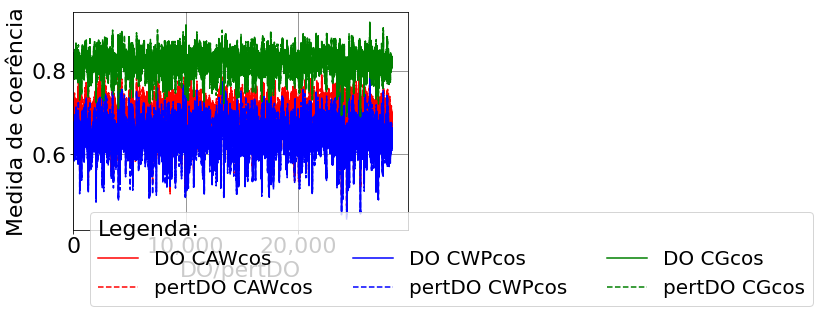

In [148]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_CcosCAW, 
                   lista_perturbado_CcosCAW, 
                   lista_original_CcosCWP, 
                   lista_perturbado_CcosCWP, 
                   lista_original_CcosCG, 
                   lista_perturbado_CcosCG,
                   medida = medida)

In [149]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCAW, lista_perturbado_CcosCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCWP, lista_perturbado_CcosCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CcosCG, lista_perturbado_CcosCG))

Diferença entre as equação CAW      : 352.37552378723854
Diferença entre as equação CWP      : 336.85857041265444
Diferença entre as equação CG       : 186.86096988285942


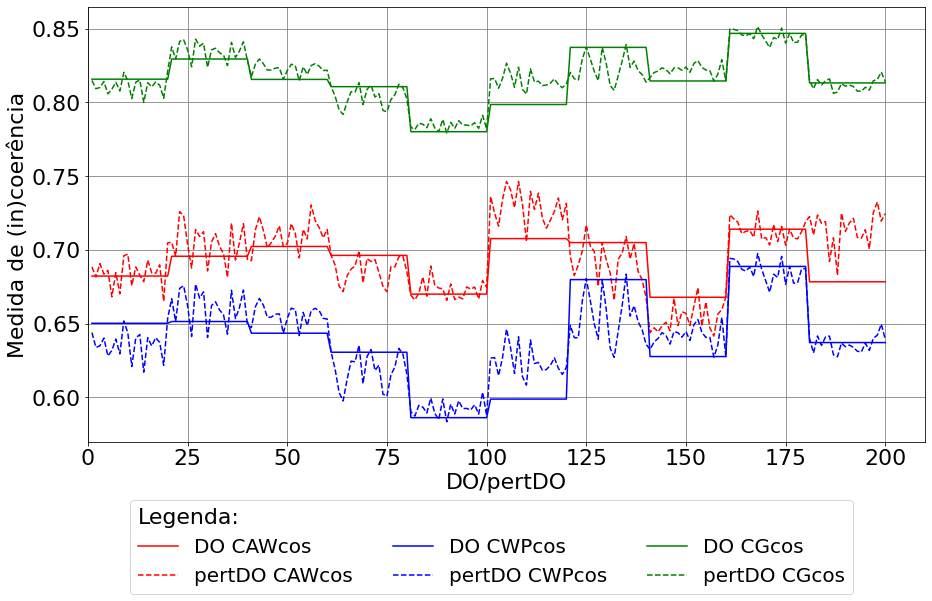

In [150]:
graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:200], 
                   lista_perturbado_CcosCAW[0:200], 
                   lista_original_CcosCWP[0:200], 
                   lista_perturbado_CcosCWP[0:200], 
                   lista_original_CcosCG[0:200], 
                   lista_perturbado_CcosCG[0:200],
                   medida = medida)

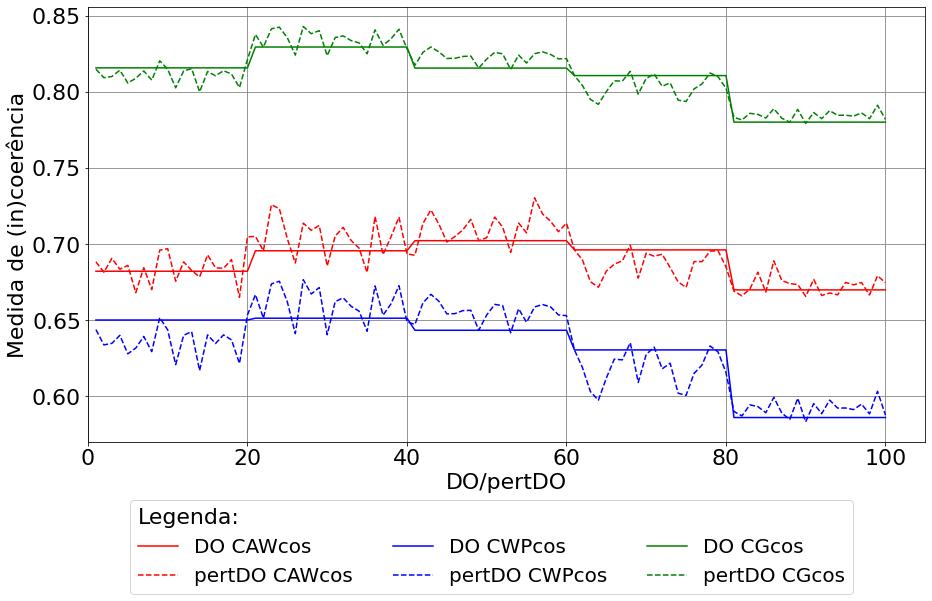

In [151]:

graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:100], 
                   lista_perturbado_CcosCAW[0:100], 
                   lista_original_CcosCWP[0:100], 
                   lista_perturbado_CcosCWP[0:100], 
                   lista_original_CcosCG[0:100], 
                   lista_perturbado_CcosCG[0:100],
                  medida = medida)

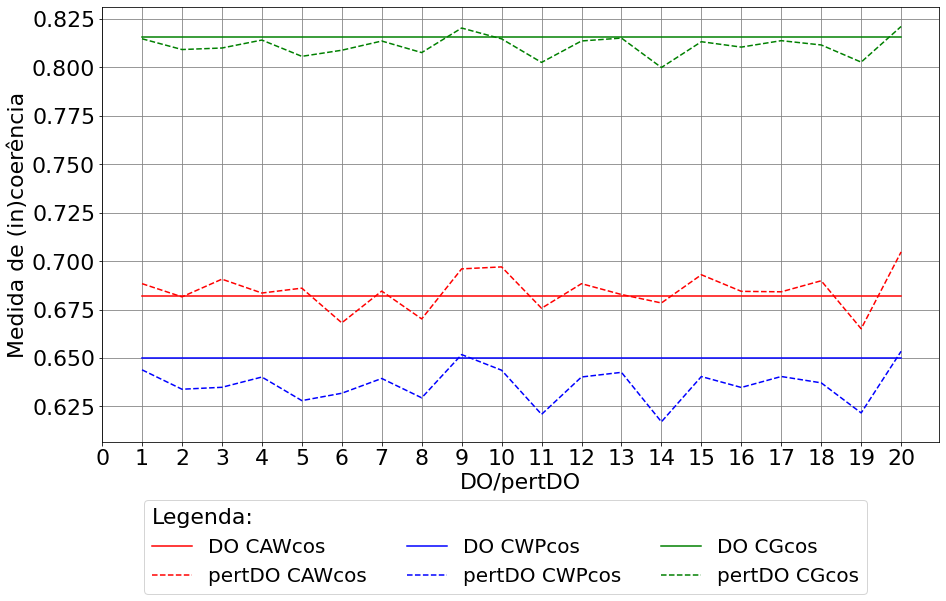

In [152]:
graficoLinhaMedida('Medida de (in)coerência', 
                   lista_original_CcosCAW[0:20], 
                   lista_perturbado_CcosCAW[0:20], 
                   lista_original_CcosCWP[0:20], 
                   lista_perturbado_CcosCWP[0:20], 
                   lista_original_CcosCG[0:20], 
                   lista_perturbado_CcosCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

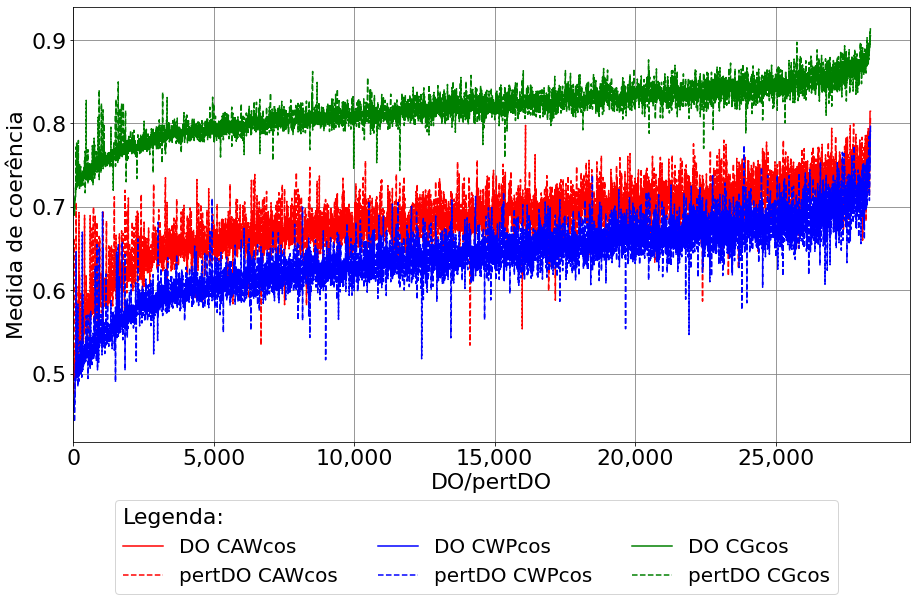

In [153]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_ordenado_CcosCAW, 
                   lista_perturbado_ordenado_CcosCAW, 
                   lista_original_ordenado_CcosCWP, 
                   lista_perturbado_ordenado_CcosCWP, 
                   lista_original_ordenado_CcosCG, 
                   lista_perturbado_ordenado_CcosCG,
                   medida = medida)

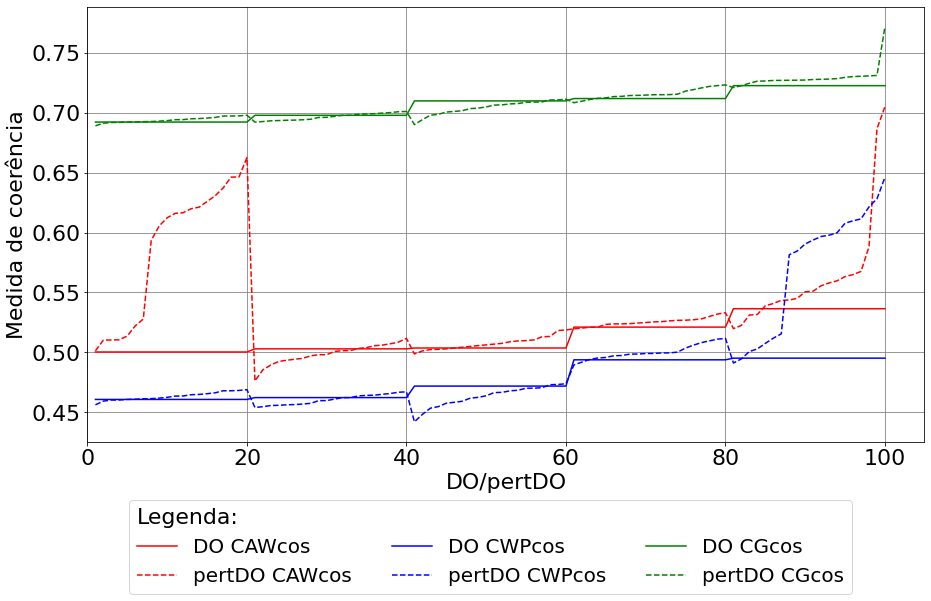

In [154]:
graficoLinhaMedida('Medida de coerência', 
                   lista_original_ordenado_CcosCAW[0:100], 
                   lista_perturbado_ordenado_CcosCAW[0:100], 
                   lista_original_ordenado_CcosCWP[0:100], 
                   lista_perturbado_ordenado_CcosCWP[0:100], 
                   lista_original_ordenado_CcosCG[0:100], 
                   lista_perturbado_ordenado_CcosCG[0:100],
                  medida = medida)

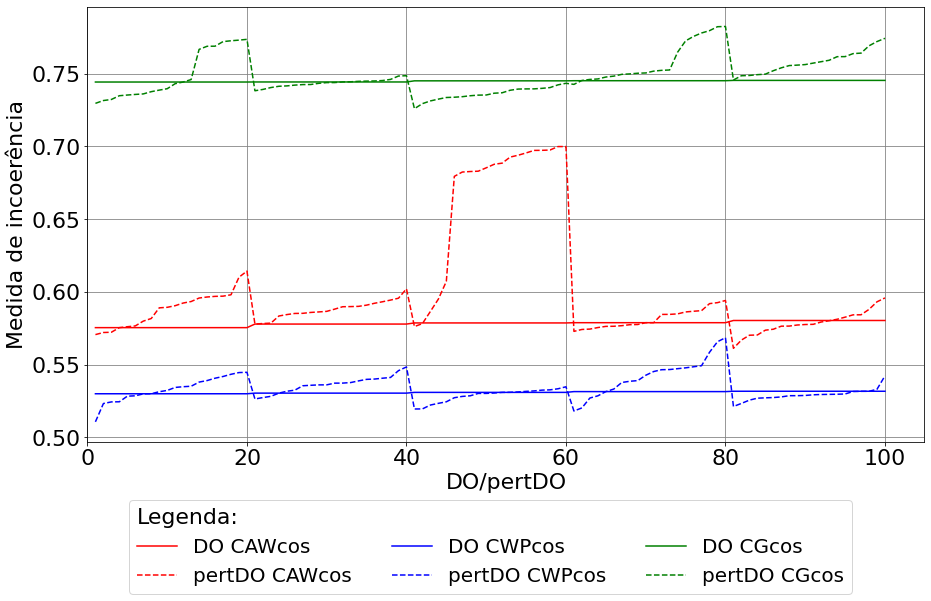

In [155]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CcosCAW[660:760], 
                   lista_perturbado_ordenado_CcosCAW[660:760], 
                   lista_original_ordenado_CcosCWP[660:760], 
                   lista_perturbado_ordenado_CcosCWP[660:760], 
                   lista_original_ordenado_CcosCG[660:760], 
                   lista_perturbado_ordenado_CcosCG[660:760])

# DO central do gráfico com a maior diferença
# id = 5728b8862ca10214002da658
# difabs=1.7355877189682087
# # 'Que governante se opôs ao uso britânico de permissões e acabou em guerra? 36
# Posição gráfico 36 * 20 = 720 = 660:760

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

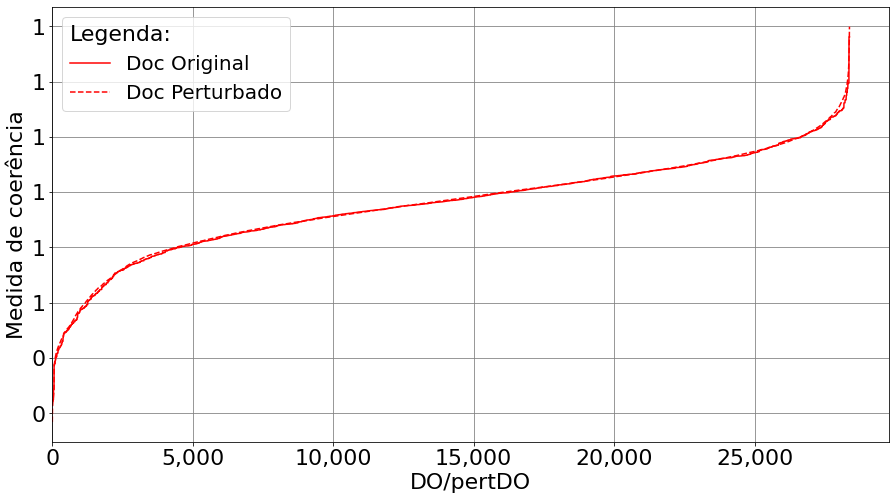

In [156]:
graficoLinhaMedida2('Medida de coerência', 
                    lista_original_ordenado_CcosCWP, 
                    lista_perturbado_ordenado_CcosCWP,
                    medida = 'cos')

Sem ordem

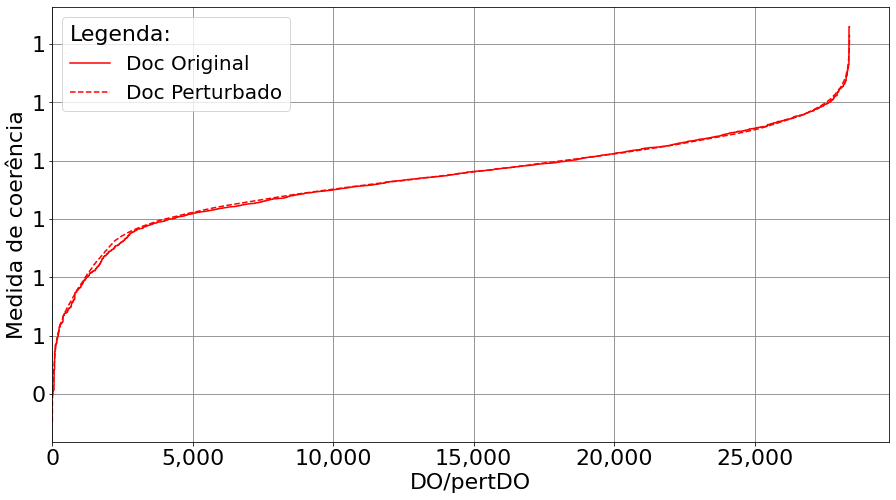

In [157]:
graficoLinhaMedida2('Medida de coerência', 
                    lista_original_CcosCAW, 
                    lista_perturbado_CcosCAW)

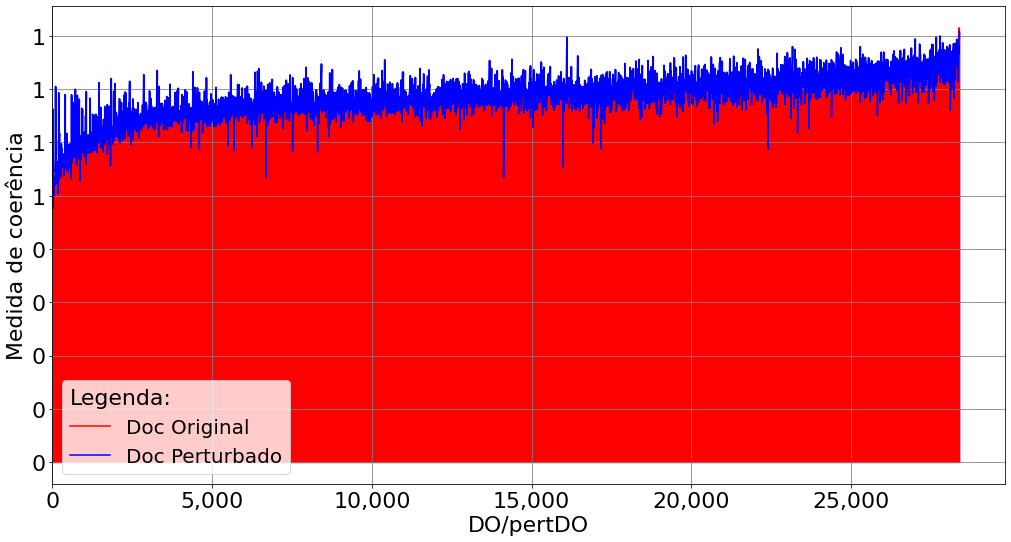

In [158]:
graficoLinhaMedida2Preenchido('Medida de coerência', 
                              lista_original_ordenado_CcosCAW, 
                              lista_perturbado_ordenado_CcosCAW,
                              medida = 'cos')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [159]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 352.37552378723854

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5726d752dd62a815002e9211', 0.03049642306107747, 118, 'O estudo de 2008 relacionado à morte de Napoleão constatou que os cabelos coletados dos cabelos de Napoleão, assim como de sua família e contemporâneos, tinham níveis de arsênico aproximadamente quantas vezes maiores que as médias atuais?']
['5726d061f1498d1400e8ec12', 0.037016174622944376, 1324, 'Que documento afirma que a igreja católica não está sujeita a nenhum governo particular?']
['56f8dcbe9e9bad19000a061c', 0.03876505941152586, 88, "Junto com o Queen Mary 2 e o Queen Victoria, qual terceiro navio deve estar presente para a 'Chegada das Três Rainhas'?"]
['5a69ba4d5ce1a5001a9696c9', 0.042591325044632256, 148, 'Em que número de relatório ao Consel

##### Usando CAW onde Cm(pertDO)>Cm(DO) *






In [160]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 184.16227511134906

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['570d4876b3d812140066d63a', 3.0080477396610128e-05, 1198, 'Que vantagens alemãs foram percebidas por outros países depois?']
['570c5532b3d812140066d12d', 4.1461907900330885e-05, 1022, 'Quem é o recordista de mais vitórias em troféus como treinador do Barcelona?']
['5730b5b4069b531400832299', 5.7379404703739034e-05, 1411, 'Quem era a Senhora Montanha Sagrada?']
['56cd976762d2951400fa6763', 8.179924704809771e-05, 598, 'Qual era o nome de trabalho do Wii antes do lançamento?']
['56f7477aa6d7ea1400e1714b', 0.00016201393944881293, 1366, 'Quais são os dois fatores que determinam se é possível

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [161]:
id_documento = "5728b8862ca10214002da658"
id_documento = lista[-1:][0][0]

In [162]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5728b8862ca10214002da658
DO: Que governante se opôs ao uso britânico de permissões e acabou em guerra?
     PRON NOUN PRON VERB ADP NOUN ADJ ADP NOUN CCONJ VERB ADP NOUN PUNCT 
  1 - Que governante se opôs ao uso britânico de permissões e lutou em guerra ? [acabou(>CAWcos(DO)=0,5786445743) -> lutou(CAWcos(pertDO)=0,5761628827)] - VERB/VERB-1-0
  2 - Que governante se opôs ao uso britânico de permissões e entrou em guerra ? [acabou(>CAWcos(DO)=0,5786445743) -> entrou(CAWcos(pertDO)=0,5781683114)] - VERB/VERB-1-0
  3 - Que governante se opôs ao uso britânico de permissões e esteve em guerra ? [acabou(CAWcos(DO)=0,5786445743) -> esteve(>CAWcos(pertDO)=0,5865392175)] - VERB/AUX-0-0
  4 - Que governante se opôs ao uso britânico de permissões e estava em guerra ? [acabou(CAWcos(DO)=0,5786445743) -> estava(>CAWcos(pertDO)=0,5950144953)] - VERB/AUX-0-0
  5 - Que governante se opôs ao uso britânico de permissões e concessões em guerra ? [acabou(CAWcos(DO)=0,5786445743) -> concessões(>CAW

In [163]:
visualizaMedidasEquacoesCSV("5a7a14ce17ab25001a8a0304",
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a7a14ce17ab25001a8a0304
DO: Quanto mudou o eslovaco do passado até agora?
     ADV VERB DET NOUN ADP NOUN ADP ADV PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
5a7a14ce17ab25001a8a0304_pert_0;Quanto vale o eslovaco do passado até agora ?;mudou;VERB;0,6200323701;0,5770222040;0,7839467128;vale;VERB;0,6934810579;0,6274161405;0,8129276633;0,2058372945;0;1
5a7a14ce17ab25001a8a0304_pert_1;Quanto ganhou o eslovaco do passado até agora ?;mudou;VERB;0,6200323701;0,5770222040;0,7839467128;ganhou;VERB;0,6568636969;0,6059378568;0,8012079332;0,1981807351;0;1
5a7a14ce17ab25001a8a0304_pert_2;Quanto ganha o eslovaco do passado até agora ?;mudou;VERB;0,6200323701;0,5770222040;0,7839467128;ganha;VERB;0,6633391976;0,6061590678;0,8009271688;0,0731330067;0;1
5a7a14ce17ab25001a8a0304_pert_3;Quanto é o eslovaco do passado até agora ?;mudou;VERB;0,6200323701

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [164]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 168.2132486758904

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56e4b61539bdeb14003479ac', 2.099275588995919e-05, 807, 'Que tipo de movimento era a arquitetura moderna no começo?']
['5a1e16ec3de3f40018b264aa', 7.822778489852134e-05, 877, 'Que local o idioma do chinês mandarim se originou?']
['56f8dcd39b226e1400dd1131', 0.00010018689291824145, 913, 'Quais são as principais exportações da Guiné-Bissau?']
['57302051947a6a140053d14f', 0.00011839509010314053, 104, 'Quem estava trabalhando no mesmo tipo de aplicação em larga escala de circuitos impressos que os EUA na Grã-Bretanha em meados da década de 1950?']
['572665dff1498d1400e8de47', 0.0001931707064

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [165]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [166]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56e4b61539bdeb14003479ac
DO: Que tipo de movimento era a arquitetura moderna no começo?
     DET NOUN ADP NOUN AUX DET NOUN ADJ ADP NOUN PUNCT 
  1 - Que tipo de movimento era a arquitetura moderna no Canadá ? [começo(>CAWcos(DO)=0,6936559319) -> Canadá(CAWcos(pertDO)=0,6936349392)] - NOUN/PROPN-0-0
  2 - Que tipo de movimento era a arquitetura moderna no Renascimento ? [começo(CAWcos(DO)=0,6936559319) -> Renascimento(>CAWcos(pertDO)=0,6949505150)] - NOUN/PROPN-0-0
  3 - Que tipo de movimento era a arquitetura moderna no Chile ? [começo(CAWcos(DO)=0,6936559319) -> Chile(>CAWcos(pertDO)=0,6951493442)] - NOUN/PROPN-0-0
  4 - Que tipo de movimento era a arquitetura moderna no Egito ? [começo(CAWcos(DO)=0,6936559319) -> Egito(>CAWcos(pertDO)=0,6952383935)] - NOUN/PROPN-0-0
  5 - Que tipo de movimento era a arquitetura moderna no Irã ? [começo(CAWcos(DO)=0,6936559319) -> Irã(>CAWcos(pertDO)=0,6970770478)] - NOUN/PROPN-0-0
  6 - Que tipo de movimento era a arquitetura moderna no ocide

In [167]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56e4b61539bdeb14003479ac
DO: Que tipo de movimento era a arquitetura moderna no começo?
     DET NOUN ADP NOUN AUX DET NOUN ADJ ADP NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
56e4b61539bdeb14003479ac_pert_0;Que tipo de movimento era a arquitetura moderna no Brasil ?;começo;NOUN;0,6936559319;0,6532113780;0,8274283409;Brasil;PROPN;0,7211925089;0,6738448132;0,8386818767;0,7731184959;0;0
56e4b61539bdeb14003479ac_pert_1;Que tipo de movimento era a arquitetura moderna no país ?;começo;NOUN;0,6936559319;0,6532113780;0,8274283409;país;NOUN;0,7146928608;0,6670235894;0,8349568735;0,0265477188;0;1
56e4b61539bdeb14003479ac_pert_2;Que tipo de movimento era a arquitetura moderna no Japão ?;começo;NOUN;0,6936559319;0,6532113780;0,8274283409;Japão;PROPN;0,7012244523;0,6621563391;0,8323043206;0,0243461337;0;0
56e4b61539bdeb14003479ac_pert_3;Que

#### Usando CWP

In [168]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 336.85857041265444

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5731b510e99e3014001e61f4', 0.04174375424782428, 65, 'Quando as cláusulas da regra da Suprema Corte dos EUA proibiram as pessoas de ocupar cargos públicos com base em sua religião eram inexequíveis?']
['5728f9a14b864d1900165160', 0.04273322423299131, 84, 'Em que dia a empresa que tocou a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes?']
['5ad11ad3645df0001a2d0d93', 0.048989635209242044, 426, 'Quantas ogivas nucleares podem ser fabricadas com 450 toneladas de urânio altamente enriquecido para armas?']
['5727cf404b864d1900163da2', 0.05435777346000947, 19, 'Os romanos invadiram o que hoje é Londres e estabeleceram seu primeiro grande assentamento em que ano?']


##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [169]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 177.56934536468367

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5ad4978fba00c4001a268cd9', 3.354766152119382e-05, 917, 'Quais são os requisitos dos dispositivos não certificados da Microsoft?']
['5730b5b4069b531400832299', 0.00020424808774666126, 1395, 'Quem era a Senhora Montanha Sagrada?']
['5ad257e8d7d075001a428da1', 0.0002299163076612265, 1326, 'O que Hobart não queria que os frades alcançassem?']
['5a81df6631013a001a334f2d', 0.0002846833732392806, 1195, 'O que os atuais inquilinos do humanismo evitam?']
['5acd600907355d001abf3f9c', 0.000299772773033502, 447, 'Qual é a maior pesquisa médica do país na Carolina do Norte?']

Os 5 últimos DOs
i

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [170]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [171]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 572933aa3f37b319004780fa
DO: Qual é o vértice também conhecido como?
     PRON AUX DET NOUN ADV VERB ADP PUNCT 
  1 - Qual é o vértice também conhecido como ? [conhecido(>CWPcos(DO)=0,6019071841) -> conhecido(CWPcos(pertDO)=0,6019071841)] - VERB/VERB-1-1
  2 - Qual é o vértice também ? como ? [conhecido(CWPcos(DO)=0,6019071841) -> ?(>CWPcos(pertDO)=0,6687731871)] - VERB/PUNCT-0-0
  3 - Qual é o vértice também E como ? [conhecido(CWPcos(DO)=0,6019071841) -> E(>CWPcos(pertDO)=0,6702166349)] - VERB/CCONJ-0-0
  4 - Qual é o vértice também será como ? [conhecido(CWPcos(DO)=0,6019071841) -> será(>CWPcos(pertDO)=0,6776505858)] - VERB/VERB-1-0
  5 - Qual é o vértice também vale como ? [conhecido(CWPcos(DO)=0,6019071841) -> vale(>CWPcos(pertDO)=0,6779985577)] - VERB/VERB-1-0
  6 - Qual é o vértice também ou como ? [conhecido(CWPcos(DO)=0,6019071841) -> ou(>CWPcos(pertDO)=0,6791384369)] - VERB/CCONJ-0-0
  7 - Qual é o vértice também o como ? [conhecido(CWPcos(DO)=0,6019071841) -> o(>CWPco

In [172]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 572933aa3f37b319004780fa
DO: Qual é o vértice também conhecido como?
     PRON AUX DET NOUN ADV VERB ADP PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
572933aa3f37b319004780fa_pert_0;Qual é o vértice também e como ?;conhecido;VERB;0,6692677566;0,6019071841;0,8054385036;e;CCONJ;0,7107605253;0,6863199451;0,8496820331;0,5633524656;0;0
572933aa3f37b319004780fa_pert_1;Qual é o vértice também , como ?;conhecido;VERB;0,6692677566;0,6019071841;0,8054385036;,;PUNCT;0,7193754315;0,6939882232;0,8539534882;0,1817247123;0;0
572933aa3f37b319004780fa_pert_2;Qual é o vértice também ou como ?;conhecido;VERB;0,6692677566;0,6019071841;0,8054385036;ou;CCONJ;0,6974477002;0,6791384369;0,8461769074;0,0503703803;0;0
572933aa3f37b319004780fa_pert_3;Qual é o vértice também ? como ?;conhecido;VERB;0,6692677566;0,6019071841;0,8054385036;?;PUNCT;0,6936936719;0,668

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [173]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 159.28922504797364

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56fc44bb2603e7140040a04b', 8.600644576250982e-05, 430, 'Que tipo de estudo de linguagem envolve tentar deduzir os fonos subjacentes?']
['5a668029f038b7001ab0bee6', 0.00015481847983134234, 295, 'O que envolve codificar informações usando menos bits que a codificação de canal?']
['57277f175951b619008f8b60', 0.0001669959588483927, 519, 'Qual era o nome da guerra civil suíça em 1839?']
['56fae0a58f12f31900630219', 0.0001799211357578212, 463, 'Juntamente com São Paulo, que cidade constitui as Cidades Gêmeas?']
['571a076110f8ca1400304ee1', 0.00018813993249622296, 1206, 'Que tipo de indúst

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [174]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [175]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56fc44bb2603e7140040a04b
DO: Que tipo de estudo de linguagem envolve tentar deduzir os fonos subjacentes?
     DET NOUN ADP NOUN ADP NOUN VERB VERB VERB DET NOUN ADJ PUNCT 
  1 - Que tipo de estudo de linguagem significa tentar deduzir os fonos subjacentes ? [envolve(>CWPcos(DO)=0,6216022533) -> significa(CWPcos(pertDO)=0,6215162468)] - VERB/VERB-1-0
  2 - Que tipo de estudo de linguagem permite tentar deduzir os fonos subjacentes ? [envolve(CWPcos(DO)=0,6216022533) -> permite(>CWPcos(pertDO)=0,6256233282)] - VERB/VERB-1-0
  3 - Que tipo de estudo de linguagem devo tentar deduzir os fonos subjacentes ? [envolve(CWPcos(DO)=0,6216022533) -> devo(>CWPcos(pertDO)=0,6316500146)] - VERB/VERB-1-0
  4 - Que tipo de estudo de linguagem é tentar deduzir os fonos subjacentes ? [envolve(CWPcos(DO)=0,6216022533) -> é(>CWPcos(pertDO)=0,6320227870)] - VERB/AUX-0-0
  5 - Que tipo de estudo de linguagem pretende tentar deduzir os fonos subjacentes ? [envolve(CWPcos(DO)=0,6216022533) -> pretende(

In [176]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56fc44bb2603e7140040a04b
DO: Que tipo de estudo de linguagem envolve tentar deduzir os fonos subjacentes?
     DET NOUN ADP NOUN ADP NOUN VERB VERB VERB DET NOUN ADJ PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
56fc44bb2603e7140040a04b_pert_0;Que tipo de estudo de linguagem pode tentar deduzir os fonos subjacentes ?;envolve;VERB;0,6626353562;0,6216022533;0,8016164670;pode;VERB;0,6809070955;0,6430981835;0,8143694722;0,2314390391;0;1
56fc44bb2603e7140040a04b_pert_1;Que tipo de estudo de linguagem podemos tentar deduzir os fonos subjacentes ?;envolve;VERB;0,6626353562;0,6216022533;0,8016164670;podemos;VERB;0,6780013641;0,6437197790;0,8150986525;0,1300261319;0;1
56fc44bb2603e7140040a04b_pert_2;Que tipo de estudo de linguagem poderia tentar deduzir os fonos subjacentes ?;envolve;VERB;0,6626353562;0,6216022533;0,8016164670;poderia;VERB;0,68

#### Usando CG

In [177]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 186.86096988285942

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5728f9a14b864d1900165160', 0.026686186790466082, 64, 'Em que dia a empresa que tocou a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes?']
['5731b510e99e3014001e61f4', 0.02692894458770745, 49, 'Quando as cláusulas da regra da Suprema Corte dos EUA proibiram as pessoas de ocupar cargos públicos com base em sua religião eram inexequíveis?']
['5ad11ad3645df0001a2d0d93', 0.03156087547540665, 347, 'Quantas ogivas nucleares podem ser fabricadas com 450 toneladas de urânio altamente enriquecido para armas?']
['5730bb522461fd1900a9d012', 0.03305971249938011, 237, 'a expansão dos EUA para o oeste poderia ser vista como que tipo de colonialismo?']
['5726d061f1498d1400e8e

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [178]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 101.32489985384862

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5acd600907355d001abf3f9c', 3.831203167259378e-05, 474, 'Qual é a maior pesquisa médica do país na Carolina do Norte?']
['5a4c43b77a6c4c001a2bbbca', 8.081847971141976e-05, 1223, 'o que está bloqueado comprar a superfície de baixa pressão?']
['5ad4978fba00c4001a268cd9', 8.61937349493358e-05, 888, 'Quais são os requisitos dos dispositivos não certificados da Microsoft?']
['5730b5b4069b531400832299', 8.976459503173828e-05, 1385, 'Quem era a Senhora Montanha Sagrada?']
['5a650f65c2b11c001a425bc6', 0.00011343305761168931, 491, 'o que foi estabelecido em Eridu no século 53 aC?']

Os 5 último

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [179]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [180]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56d4d2232ccc5a1400d83263
DO: Como Beyoncé e Jay Z nomearam sua filha?
     ADP PROPN CCONJ PROPN PROPN VERB DET NOUN PUNCT 
  1 - Como Beyoncé e Jay Z conseguiram sua filha ? [nomearam(CGcos(DO)=0,7389502161) -> conseguiram(>CGcos(pertDO)=0,7391069995)] - VERB/VERB-1-0
  2 - Como Beyoncé e Jay Z criaram sua filha ? [nomearam(CGcos(DO)=0,7389502161) -> criaram(>CGcos(pertDO)=0,7412615452)] - VERB/VERB-1-0
  3 - Como Beyoncé e Jay Z tiveram sua filha ? [nomearam(CGcos(DO)=0,7389502161) -> tiveram(>CGcos(pertDO)=0,7448710832)] - VERB/VERB-1-0
  4 - Como Beyoncé e Jay Z chamaram sua filha ? [nomearam(CGcos(DO)=0,7389502161) -> chamaram(>CGcos(pertDO)=0,7460198734)] - VERB/VERB-1-0
  5 - Como Beyoncé e Jay Z viram sua filha ? [nomearam(CGcos(DO)=0,7389502161) -> viram(>CGcos(pertDO)=0,7488087515)] - VERB/VERB-1-0
  6 - Como Beyoncé e Jay Z querem sua filha ? [nomearam(CGcos(DO)=0,7389502161) -> querem(>CGcos(pertDO)=0,7513244881)] - VERB/VERB-1-0
  7 - Como Beyoncé e Jay Z descobrira

In [181]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56d4d2232ccc5a1400d83263
DO: Como Beyoncé e Jay Z nomearam sua filha?
     ADP PROPN CCONJ PROPN PROPN VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
56d4d2232ccc5a1400d83263_pert_0;Como Beyoncé e Jay Z criaram sua filha ?;nomearam;VERB;0,5003272872;0,4951757369;0,7389502161;criaram;VERB;0,5013553817;0,4945839494;0,7412615452;0,2992008030;0;1
56d4d2232ccc5a1400d83263_pert_1;Como Beyoncé e Jay Z conheceram sua filha ?;nomearam;VERB;0,5003272872;0,4951757369;0,7389502161;conheceram;VERB;0,5934745185;0,5814776992;0,7923659947;0,1537322998;0;1
56d4d2232ccc5a1400d83263_pert_2;Como Beyoncé e Jay Z criam sua filha ?;nomearam;VERB;0,5003272872;0,4951757369;0,7389502161;criam;VERB;0,6212083399;0,5999128115;0,8026585778;0,0862130672;0;1
56d4d2232ccc5a1400d83263_pert_3;Como Beyoncé e Jay Z conheceu sua filha ?;nomearam;VERB;0,5003272

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [182]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 85.53607002901066

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57277f175951b619008f8b60', 5.906278436773604e-06, 550, 'Qual era o nome da guerra civil suíça em 1839?']
['5a5166c4ce860b001aa3fd8b', 2.6982277631759644e-05, 229, 'A quais princípios a lei básica sugere que a Alemanha não é obrigada a obedecer?']
['57313d51e6313a140071cd75', 9.776438985553693e-05, 308, 'Para que ação foi necessária a assistência do governo após o ciclone Tuvalu?']
['5acd976707355d001abf47c2', 0.00012210342619156656, 596, 'Qual porcentagem da Flórida era afro-americana em 2001?']
['572891182ca10214002da47c', 0.00019797257014675385, 188, 'Em que trabalho publicado em 193

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [183]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [184]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57277f175951b619008f8b60
DO: Qual era o nome da guerra civil suíça em 1839?
     PRON AUX DET NOUN ADP NOUN ADJ ADJ ADP NUM PUNCT 
  1 - Qual era o final da guerra civil suíça em 1839 ? [nome(>CGcos(DO)=0,8121266799) -> final(CGcos(pertDO)=0,8121207736)] - NOUN/NOUN-1-0
  2 - Qual era o nome da guerra civil suíça em 1839 ? [nome(>CGcos(DO)=0,8121266799) -> nome(CGcos(pertDO)=0,8121266799)] - NOUN/NOUN-1-1
  3 - Qual era o fim da guerra civil suíça em 1839 ? [nome(CGcos(DO)=0,8121266799) -> fim(>CGcos(pertDO)=0,8147501620)] - NOUN/NOUN-1-0
  4 - Qual era o resultado da guerra civil suíça em 1839 ? [nome(CGcos(DO)=0,8121266799) -> resultado(>CGcos(pertDO)=0,8166516152)] - NOUN/NOUN-1-0
  5 - Qual era o estado da guerra civil suíça em 1839 ? [nome(CGcos(DO)=0,8121266799) -> estado(>CGcos(pertDO)=0,8166580200)] - NOUN/NOUN-1-0
  6 - Qual era o início da guerra civil suíça em 1839 ? [nome(CGcos(DO)=0,8121266799) -> início(>CGcos(pertDO)=0,8170400804)] - NOUN/NOUN-1-0
  7 - Qual era o

In [185]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57277f175951b619008f8b60
DO: Qual era o nome da guerra civil suíça em 1839?
     PRON AUX DET NOUN ADP NOUN ADJ ADJ ADP NUM PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
57277f175951b619008f8b60_pert_0;Qual era o resultado da guerra civil suíça em 1839 ?;nome;NOUN;0,6859367549;0,6302064045;0,8121266799;resultado;NOUN;0,6822533846;0,6382437338;0,8166516152;0,1540717632;0;1
57277f175951b619008f8b60_pert_1;Qual era o significado da guerra civil suíça em 1839 ?;nome;NOUN;0,6859367549;0,6302064045;0,8121266799;significado;NOUN;0,6932924449;0,6433821212;0,8194292675;0,1252745092;0;1
57277f175951b619008f8b60_pert_2;Qual era o cenário da guerra civil suíça em 1839 ?;nome;NOUN;0,6859367549;0,6302064045;0,8121266799;cenário;NOUN;0,6976189971;0,6508796107;0,8236891736;0,0881198570;0;1
57277f175951b619008f8b60_pert_3;Qual era o objetivo da guerra 

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [186]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 85.53607002901066

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56f8dcbe9e9bad19000a061c', 0.005218306779861459, 88, "Junto com o Queen Mary 2 e o Queen Victoria, qual terceiro navio deve estar presente para a 'Chegada das Três Rainhas'?"]
['5726d752dd62a815002e9211', 0.005691350270540352, 118, 'O estudo de 2008 relacionado à morte de Napoleão constatou que os cabelos coletados dos cabelos de Napoleão, assim como de sua família e contemporâneos, tinham níveis de arsênico aproximadamente quantas vezes maiores que as médias atuais?']
['5728a0da2ca10214002da4e8', 0.006285027083423378, 74, 'Além da cabeça e do abdômen, qual é a outra seção principal do corpo de um inseto?']
['5705eece75f01819005e778b', 0.0066165654432206

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [187]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 85.53607002901066

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['570d4876b3d812140066d63a', 3.0080477396610128e-05, 1198, 'Que vantagens alemãs foram percebidas por outros países depois?']
['570c5532b3d812140066d12d', 4.1461907900330885e-05, 1022, 'Quem é o recordista de mais vitórias em troféus como treinador do Barcelona?']
['5730b5b4069b531400832299', 5.7379404703739034e-05, 1411, 'Quem era a Senhora Montanha Sagrada?']
['56cd976762d2951400fa6763', 8.179924704809771e-05, 598, 'Qual era o nome de trabalho do Wii antes do lançamento?']
['56f7477aa6d7ea1400e1714b', 0.00016201393944881293, 1366, 'Quais são os dois fatores que determinam se é possível retirar-se

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [188]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [189]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a35d653788daf001a5f86a1
DO: O que são botões curtos e redondos?
     PRON PRON AUX NOUN ADJ CCONJ ADJ PUNCT 
  1 - O que são pés curtos e redondos ? [botões(>CAWcos(DO)=0,5364387419) -> pés(CAWcos(pertDO)=0,5198376626)] - NOUN/NOUN-1-0
  2 - O que são dentes curtos e redondos ? [botões(>CAWcos(DO)=0,5364387419) -> dentes(CAWcos(pertDO)=0,5225135599)] - NOUN/NOUN-1-0
  3 - O que são olhos curtos e redondos ? [botões(>CAWcos(DO)=0,5364387419) -> olhos(CAWcos(pertDO)=0,5311968114)] - NOUN/NOUN-1-0
  4 - O que são dedos curtos e redondos ? [botões(>CAWcos(DO)=0,5364387419) -> dedos(CAWcos(pertDO)=0,5316466668)] - NOUN/NOUN-1-0
  5 - O que são óculos curtos e redondos ? [botões(CAWcos(DO)=0,5364387419) -> óculos(>CAWcos(pertDO)=0,5389000007)] - NOUN/NOUN-1-0
  6 - O que são pelos curtos e redondos ? [botões(CAWcos(DO)=0,5364387419) -> pelos(>CAWcos(pertDO)=0,5407791223)] - NOUN/ADP-0-0
  7 - O que são sapatos curtos e redondos ? [botões(CAWcos(DO)=0,5364387419) -> sapatos(>CAWcos(pe

In [190]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a35d653788daf001a5f86a1
DO: O que são botões curtos e redondos?
     PRON PRON AUX NOUN ADJ CCONJ ADJ PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
5a35d653788daf001a5f86a1_pert_0;O que são cabelos curtos e redondos ?;botões;NOUN;0,5364387419;0,5110031428;0,7497270703;cabelos;NOUN;0,5451186959;0,5063189877;0,7489651553;0,7847305536;0;1
5a35d653788daf001a5f86a1_pert_1;O que são fios curtos e redondos ?;botões;NOUN;0,5364387419;0,5110031428;0,7497270703;fios;NOUN;0,5632432295;0,5190769359;0,7563826777;0,0241297595;0;1
5a35d653788daf001a5f86a1_pert_2;O que são os curtos e redondos ?;botões;NOUN;0,5364387419;0,5110031428;0,7497270703;os;DET;0,7051764216;0,6697676565;0,8403332084;0,0240892936;0;0
5a35d653788daf001a5f86a1_pert_3;O que são braços curtos e redondos ?;botões;NOUN;0,5364387419;0,5110031428;0,7497270703;braços;NOUN;0,5437360363;

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [191]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 85.53607002901066

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56e4b61539bdeb14003479ac', 2.099275588995919e-05, 807, 'Que tipo de movimento era a arquitetura moderna no começo?']
['5a1e16ec3de3f40018b264aa', 7.822778489852134e-05, 877, 'Que local o idioma do chinês mandarim se originou?']
['56f8dcd39b226e1400dd1131', 0.00010018689291824145, 913, 'Quais são as principais exportações da Guiné-Bissau?']
['57302051947a6a140053d14f', 0.00011839509010314053, 104, 'Quem estava trabalhando no mesmo tipo de aplicação em larga escala de circuitos impressos que os EUA na Grã-Bretanha em meados da década de 1950?']
['572665dff1498d1400e8de47', 0.00019317070643110057, 7

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [192]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [193]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a8c8fa5fd22b3001a8d8b07
DO: Do que Skousen excluiu os restos de tinta e lápis?
     ADP PRON PROPN VERB DET NOUN ADP NOUN CCONJ NOUN PUNCT 
  1 - Do que Skousen tirou os restos de tinta e lápis ? [excluiu(>CAWcos(DO)=0,6877064586) -> tirou(CAWcos(pertDO)=0,5339888975)] - VERB/VERB-1-0
  2 - Do que Skousen tira os restos de tinta e lápis ? [excluiu(>CAWcos(DO)=0,6877064586) -> tira(CAWcos(pertDO)=0,5397592604)] - VERB/VERB-1-0
  3 - Do que Skousen retira os restos de tinta e lápis ? [excluiu(>CAWcos(DO)=0,6877064586) -> retira(CAWcos(pertDO)=0,5421640009)] - VERB/VERB-1-0
  4 - Do que Skousen retirou os restos de tinta e lápis ? [excluiu(>CAWcos(DO)=0,6877064586) -> retirou(CAWcos(pertDO)=0,5434042647)] - VERB/VERB-1-0
  5 - Do que Skousen guarda os restos de tinta e lápis ? [excluiu(>CAWcos(DO)=0,6877064586) -> guarda(CAWcos(pertDO)=0,5465224296)] - VERB/VERB-1-0
  6 - Do que Skousen recebeu os restos de tinta e lápis ? [excluiu(>CAWcos(DO)=0,6877064586) -> recebeu(CAWcos(pertD

In [194]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a8c8fa5fd22b3001a8d8b07
DO: Do que Skousen excluiu os restos de tinta e lápis?
     ADP PRON PROPN VERB DET NOUN ADP NOUN CCONJ NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
5a8c8fa5fd22b3001a8d8b07_pert_0;Do que Skousen tirou os restos de tinta e lápis ?;excluiu;VERB;0,6877064586;0,6371893146;0,8136465224;tirou;VERB;0,5339888975;0,5176774387;0,7439052354;0,0733064860;0;1
5a8c8fa5fd22b3001a8d8b07_pert_1;Do que Skousen retirou os restos de tinta e lápis ?;excluiu;VERB;0,6877064586;0,6371893146;0,8136465224;retirou;VERB;0,5434042647;0,5222477712;0,7467479895;0,0591557287;0;1
5a8c8fa5fd22b3001a8d8b07_pert_2;Do que Skousen fez os restos de tinta e lápis ?;excluiu;VERB;0,6877064586;0,6371893146;0,8136465224;fez;VERB;0,5777815804;0,5564772630;0,7678739645;0,0589119568;0;1
5a8c8fa5fd22b3001a8d8b07_pert_3;Do que Skousen tira os restos de

#### Usando CWP






In [195]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 85.53607002901066

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5728f9a14b864d1900165160', 0.005501537521680144, 84, 'Em que dia a empresa que tocou a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes?']
['5731b510e99e3014001e61f4', 0.0060694649815559165, 65, 'Quando as cláusulas da regra da Suprema Corte dos EUA proibiram as pessoas de ocupar cargos públicos com base em sua religião eram inexequíveis?']
['5730bb522461fd1900a9d012', 0.00625522012511881, 236, 'a expansão dos EUA para o oeste poderia ser vista como que tipo de colonialismo?']
['57268c25dd62a815002e892a', 0.007009696884032968, 413, 'Qual é o nome da principal liga nacional de basquete da Grécia?']
['56f76011a6d

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [196]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 85.53607002901066

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5ad4978fba00c4001a268cd9', 3.354766152119382e-05, 917, 'Quais são os requisitos dos dispositivos não certificados da Microsoft?']
['5730b5b4069b531400832299', 0.00020424808774666126, 1395, 'Quem era a Senhora Montanha Sagrada?']
['5ad257e8d7d075001a428da1', 0.0002299163076612265, 1326, 'O que Hobart não queria que os frades alcançassem?']
['5a81df6631013a001a334f2d', 0.0002846833732392806, 1195, 'O que os atuais inquilinos do humanismo evitam?']
['5acd600907355d001abf3f9c', 0.000299772773033502, 447, 'Qual é a maior pesquisa médica do país na Carolina do Norte?']

Os 5 últimos DOs
id_DO, difabs, 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [197]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [198]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a35d653788daf001a5f86a1
DO: O que são botões curtos e redondos?
     PRON PRON AUX NOUN ADJ CCONJ ADJ PUNCT 
  1 - O que são pés curtos e redondos ? [botões(>CAWcos(DO)=0,5364387419) -> pés(CAWcos(pertDO)=0,5198376626)] - NOUN/NOUN-1-0
  2 - O que são dentes curtos e redondos ? [botões(>CAWcos(DO)=0,5364387419) -> dentes(CAWcos(pertDO)=0,5225135599)] - NOUN/NOUN-1-0
  3 - O que são olhos curtos e redondos ? [botões(>CAWcos(DO)=0,5364387419) -> olhos(CAWcos(pertDO)=0,5311968114)] - NOUN/NOUN-1-0
  4 - O que são dedos curtos e redondos ? [botões(>CAWcos(DO)=0,5364387419) -> dedos(CAWcos(pertDO)=0,5316466668)] - NOUN/NOUN-1-0
  5 - O que são óculos curtos e redondos ? [botões(CAWcos(DO)=0,5364387419) -> óculos(>CAWcos(pertDO)=0,5389000007)] - NOUN/NOUN-1-0
  6 - O que são pelos curtos e redondos ? [botões(CAWcos(DO)=0,5364387419) -> pelos(>CAWcos(pertDO)=0,5407791223)] - NOUN/ADP-0-0
  7 - O que são sapatos curtos e redondos ? [botões(CAWcos(DO)=0,5364387419) -> sapatos(>CAWcos(pe

In [199]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a35d653788daf001a5f86a1
DO: O que são botões curtos e redondos?
     PRON PRON AUX NOUN ADJ CCONJ ADJ PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
5a35d653788daf001a5f86a1_pert_0;O que são cabelos curtos e redondos ?;botões;NOUN;0,5364387419;0,5110031428;0,7497270703;cabelos;NOUN;0,5451186959;0,5063189877;0,7489651553;0,7847305536;0;1
5a35d653788daf001a5f86a1_pert_1;O que são fios curtos e redondos ?;botões;NOUN;0,5364387419;0,5110031428;0,7497270703;fios;NOUN;0,5632432295;0,5190769359;0,7563826777;0,0241297595;0;1
5a35d653788daf001a5f86a1_pert_2;O que são os curtos e redondos ?;botões;NOUN;0,5364387419;0,5110031428;0,7497270703;os;DET;0,7051764216;0,6697676565;0,8403332084;0,0240892936;0;0
5a35d653788daf001a5f86a1_pert_3;O que são braços curtos e redondos ?;botões;NOUN;0,5364387419;0,5110031428;0,7497270703;braços;NOUN;0,5437360363;

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [200]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 85.53607002901066

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56fc44bb2603e7140040a04b', 8.600644576250982e-05, 430, 'Que tipo de estudo de linguagem envolve tentar deduzir os fonos subjacentes?']
['5a668029f038b7001ab0bee6', 0.00015481847983134234, 295, 'O que envolve codificar informações usando menos bits que a codificação de canal?']
['57277f175951b619008f8b60', 0.0001669959588483927, 519, 'Qual era o nome da guerra civil suíça em 1839?']
['56fae0a58f12f31900630219', 0.0001799211357578212, 463, 'Juntamente com São Paulo, que cidade constitui as Cidades Gêmeas?']
['571a076110f8ca1400304ee1', 0.00018813993249622296, 1206, 'Que tipo de indústria prospera e

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [201]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [202]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56e78fe637bdd419002c4144
DO: Quando as tropas Qing recuperaram Nanjing?
     SCONJ DET NOUN PROPN VERB PROPN PUNCT 
  1 - Quando as tropas Qing e Nanjing ? [recuperaram(>CAWcos(DO)=0,6932532191) -> e(CAWcos(pertDO)=0,5535039728)] - VERB/CCONJ-0-0
  2 - Quando as tropas Qing invadiram Nanjing ? [recuperaram(>CAWcos(DO)=0,6932532191) -> invadiram(CAWcos(pertDO)=0,6639799277)] - VERB/VERB-1-0
  3 - Quando as tropas Qing ocuparam Nanjing ? [recuperaram(>CAWcos(DO)=0,6932532191) -> ocuparam(CAWcos(pertDO)=0,6673211555)] - VERB/VERB-1-0
  4 - Quando as tropas Qing conquistaram Nanjing ? [recuperaram(>CAWcos(DO)=0,6932532191) -> conquistaram(CAWcos(pertDO)=0,6677744885)] - VERB/VERB-1-0
  5 - Quando as tropas Qing alcançaram Nanjing ? [recuperaram(>CAWcos(DO)=0,6932532191) -> alcançaram(CAWcos(pertDO)=0,6696943243)] - VERB/VERB-1-0
  6 - Quando as tropas Qing tomaram Nanjing ? [recuperaram(>CAWcos(DO)=0,6932532191) -> tomaram(CAWcos(pertDO)=0,6699195206)] - VERB/VERB-1-0
  7 - Quando a

In [203]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56e78fe637bdd419002c4144
DO: Quando as tropas Qing recuperaram Nanjing?
     SCONJ DET NOUN PROPN VERB PROPN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
56e78fe637bdd419002c4144_pert_0;Quando as tropas Qing deixaram Nanjing ?;recuperaram;VERB;0,6932532191;0,6710155464;0,8399785927;deixaram;VERB;0,6812167366;0,6622582021;0,8337923544;0,2611705363;0;1
56e78fe637bdd419002c4144_pert_1;Quando as tropas Qing invadiram Nanjing ?;recuperaram;VERB;0,6932532191;0,6710155464;0,8399785927;invadiram;VERB;0,6639799277;0,6518079326;0,8272281204;0,1783994734;0;1
56e78fe637bdd419002c4144_pert_2;Quando as tropas Qing tomaram Nanjing ?;recuperaram;VERB;0,6932532191;0,6710155464;0,8399785927;tomaram;VERB;0,6699195206;0,6542556030;0,8288674355;0,1007705256;0;1
56e78fe637bdd419002c4144_pert_3;Quando as tropas Qing atacaram Nanjing ?;recuperaram;VERB;0,693

#### Usando CG






In [204]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 85.53607002901066

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5728f9a14b864d1900165160', 0.0033874893188475808, 64, 'Em que dia a empresa que tocou a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes?']
['5730bb522461fd1900a9d012', 0.00366896390914917, 237, 'a expansão dos EUA para o oeste poderia ser vista como que tipo de colonialismo?']
['5731b510e99e3014001e61f4', 0.003961732387542716, 49, 'Quando as cláusulas da regra da Suprema Corte dos EUA proibiram as pessoas de ocupar cargos públicos com base em sua religião eram inexequíveis?']
['57268c25dd62a815002e892a', 0.004032772320967437, 436, 'Qual é o nome da principal liga nacional de basquete da Grécia?']
['5a5e61eb5bc9f

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [205]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 85.53607002901066

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5acd600907355d001abf3f9c', 3.831203167259378e-05, 474, 'Qual é a maior pesquisa médica do país na Carolina do Norte?']
['5a4c43b77a6c4c001a2bbbca', 8.081847971141976e-05, 1223, 'o que está bloqueado comprar a superfície de baixa pressão?']
['5ad4978fba00c4001a268cd9', 8.61937349493358e-05, 888, 'Quais são os requisitos dos dispositivos não certificados da Microsoft?']
['5730b5b4069b531400832299', 8.976459503173828e-05, 1385, 'Quem era a Senhora Montanha Sagrada?']
['5a650f65c2b11c001a425bc6', 0.00011343305761168931, 491, 'o que foi estabelecido em Eridu no século 53 aC?']

Os 5 últimos DOs
id_DO, d

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [206]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [207]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a35d653788daf001a5f86a1
DO: O que são botões curtos e redondos?
     PRON PRON AUX NOUN ADJ CCONJ ADJ PUNCT 
  1 - O que são pés curtos e redondos ? [botões(>CAWcos(DO)=0,5364387419) -> pés(CAWcos(pertDO)=0,5198376626)] - NOUN/NOUN-1-0
  2 - O que são dentes curtos e redondos ? [botões(>CAWcos(DO)=0,5364387419) -> dentes(CAWcos(pertDO)=0,5225135599)] - NOUN/NOUN-1-0
  3 - O que são olhos curtos e redondos ? [botões(>CAWcos(DO)=0,5364387419) -> olhos(CAWcos(pertDO)=0,5311968114)] - NOUN/NOUN-1-0
  4 - O que são dedos curtos e redondos ? [botões(>CAWcos(DO)=0,5364387419) -> dedos(CAWcos(pertDO)=0,5316466668)] - NOUN/NOUN-1-0
  5 - O que são óculos curtos e redondos ? [botões(CAWcos(DO)=0,5364387419) -> óculos(>CAWcos(pertDO)=0,5389000007)] - NOUN/NOUN-1-0
  6 - O que são pelos curtos e redondos ? [botões(CAWcos(DO)=0,5364387419) -> pelos(>CAWcos(pertDO)=0,5407791223)] - NOUN/ADP-0-0
  7 - O que são sapatos curtos e redondos ? [botões(CAWcos(DO)=0,5364387419) -> sapatos(>CAWcos(pe

In [208]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a35d653788daf001a5f86a1
DO: O que são botões curtos e redondos?
     PRON PRON AUX NOUN ADJ CCONJ ADJ PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
5a35d653788daf001a5f86a1_pert_0;O que são cabelos curtos e redondos ?;botões;NOUN;0,5364387419;0,5110031428;0,7497270703;cabelos;NOUN;0,5451186959;0,5063189877;0,7489651553;0,7847305536;0;1
5a35d653788daf001a5f86a1_pert_1;O que são fios curtos e redondos ?;botões;NOUN;0,5364387419;0,5110031428;0,7497270703;fios;NOUN;0,5632432295;0,5190769359;0,7563826777;0,0241297595;0;1
5a35d653788daf001a5f86a1_pert_2;O que são os curtos e redondos ?;botões;NOUN;0,5364387419;0,5110031428;0,7497270703;os;DET;0,7051764216;0,6697676565;0,8403332084;0,0240892936;0;0
5a35d653788daf001a5f86a1_pert_3;O que são braços curtos e redondos ?;botões;NOUN;0,5364387419;0,5110031428;0,7497270703;braços;NOUN;0,5437360363;

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [209]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 85.53607002901066

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57277f175951b619008f8b60', 5.906278436773604e-06, 550, 'Qual era o nome da guerra civil suíça em 1839?']
['5a5166c4ce860b001aa3fd8b', 2.6982277631759644e-05, 229, 'A quais princípios a lei básica sugere que a Alemanha não é obrigada a obedecer?']
['57313d51e6313a140071cd75', 9.776438985553693e-05, 308, 'Para que ação foi necessária a assistência do governo após o ciclone Tuvalu?']
['5acd976707355d001abf47c2', 0.00012210342619156656, 596, 'Qual porcentagem da Flórida era afro-americana em 2001?']
['572891182ca10214002da47c', 0.00019797257014675385, 188, 'Em que trabalho publicado em 1934 Popper intr

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [210]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [211]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a8c8fa5fd22b3001a8d8b07
DO: Do que Skousen excluiu os restos de tinta e lápis?
     ADP PRON PROPN VERB DET NOUN ADP NOUN CCONJ NOUN PUNCT 
  1 - Do que Skousen tirou os restos de tinta e lápis ? [excluiu(>CAWcos(DO)=0,6877064586) -> tirou(CAWcos(pertDO)=0,5339888975)] - VERB/VERB-1-0
  2 - Do que Skousen tira os restos de tinta e lápis ? [excluiu(>CAWcos(DO)=0,6877064586) -> tira(CAWcos(pertDO)=0,5397592604)] - VERB/VERB-1-0
  3 - Do que Skousen retira os restos de tinta e lápis ? [excluiu(>CAWcos(DO)=0,6877064586) -> retira(CAWcos(pertDO)=0,5421640009)] - VERB/VERB-1-0
  4 - Do que Skousen retirou os restos de tinta e lápis ? [excluiu(>CAWcos(DO)=0,6877064586) -> retirou(CAWcos(pertDO)=0,5434042647)] - VERB/VERB-1-0
  5 - Do que Skousen guarda os restos de tinta e lápis ? [excluiu(>CAWcos(DO)=0,6877064586) -> guarda(CAWcos(pertDO)=0,5465224296)] - VERB/VERB-1-0
  6 - Do que Skousen recebeu os restos de tinta e lápis ? [excluiu(>CAWcos(DO)=0,6877064586) -> recebeu(CAWcos(pertD

In [212]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a8c8fa5fd22b3001a8d8b07
DO: Do que Skousen excluiu os restos de tinta e lápis?
     ADP PRON PROPN VERB DET NOUN ADP NOUN CCONJ NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
5a8c8fa5fd22b3001a8d8b07_pert_0;Do que Skousen tirou os restos de tinta e lápis ?;excluiu;VERB;0,6877064586;0,6371893146;0,8136465224;tirou;VERB;0,5339888975;0,5176774387;0,7439052354;0,0733064860;0;1
5a8c8fa5fd22b3001a8d8b07_pert_1;Do que Skousen retirou os restos de tinta e lápis ?;excluiu;VERB;0,6877064586;0,6371893146;0,8136465224;retirou;VERB;0,5434042647;0,5222477712;0,7467479895;0,0591557287;0;1
5a8c8fa5fd22b3001a8d8b07_pert_2;Do que Skousen fez os restos de tinta e lápis ?;excluiu;VERB;0,6877064586;0,6371893146;0,8136465224;fez;VERB;0,5777815804;0,5564772630;0,7678739645;0,0589119568;0;1
5a8c8fa5fd22b3001a8d8b07_pert_3;Do que Skousen tira os restos de

## 3.6  Avaliando o cálculo da incoerência com todas as equações e com a medida de distância euclidiana(euc)






In [213]:
medida = 'euc'

### Estatística

#### CAW

In [214]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 17293 de 28380
Percentual de documentos coerentes em relação ao total: 60.9337561663143
Acertos Perturbado : 11087 de 28380
Percentual de documentos incoerentes em relação ao total: 39.0662438336857


#### CWP

In [215]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 17070 de 28380
Percentual de documentos coerentes em relação ao total: 60.14799154334038
Acertos Perturbado : 11310 de 28380
Percentual de documentos incoerentes em relação ao total: 39.85200845665962


#### CG

In [216]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 16870 de 28380
Percentual de documentos coerentes em relação ao total: 59.443269908386185
Acertos Perturbado : 11510 de 28380
Percentual de documentos incoerentes em relação ao total: 40.556730091613815


### Gráficos

#### Gráfico de linha das medida de coerência Ceuc dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





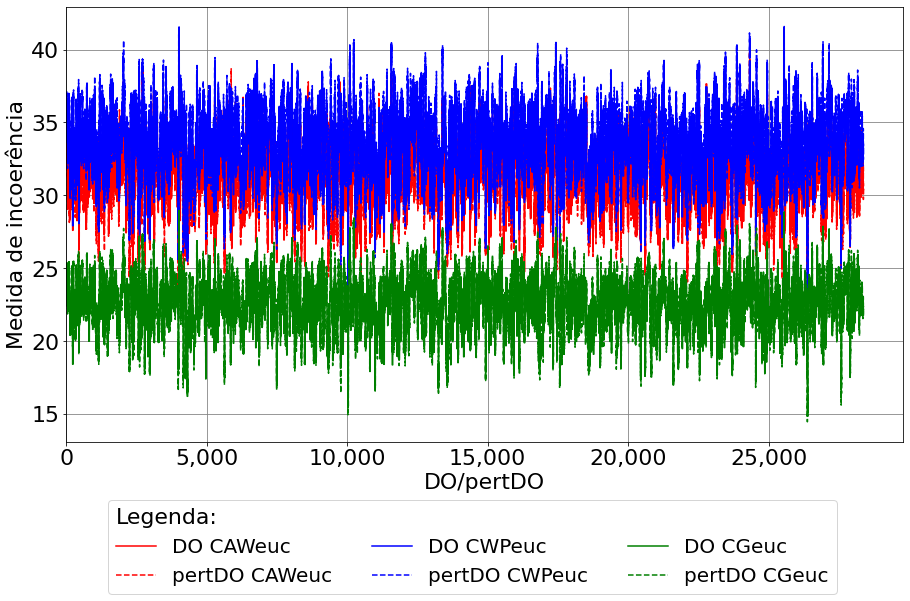

In [217]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CeucCAW, 
                   lista_perturbado_CeucCAW, 
                   lista_original_CeucCWP, 
                   lista_perturbado_CeucCWP, 
                   lista_original_CeucCG, 
                   lista_perturbado_CeucCG,
                   medida = medida)

In [218]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 22428.563986005043
Diferença absoluta entre as medidas equação CWP : 22308.19948823708
Diferença absoluta entre as medidas equação CG  : 14616.188384545298


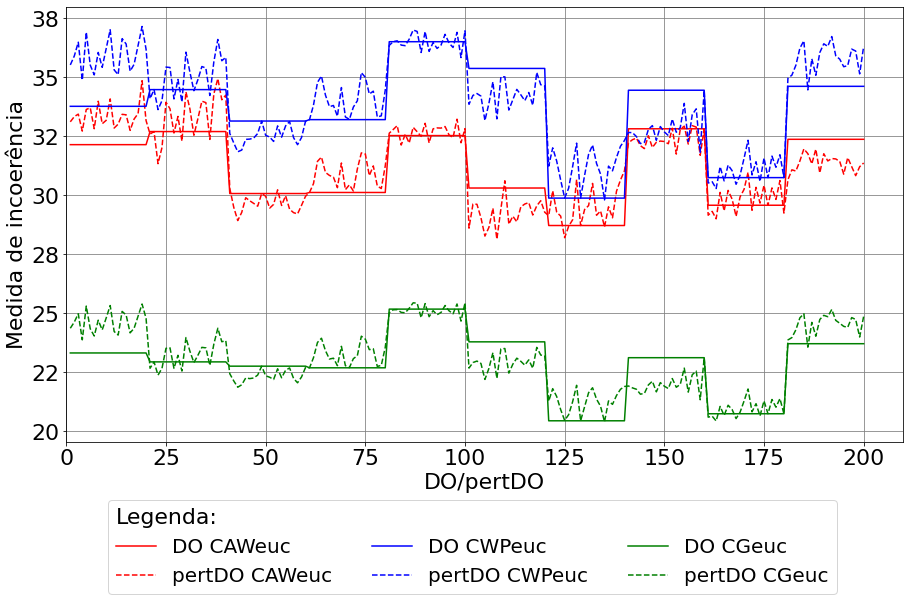

In [219]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CeucCAW[0:200], 
                   lista_perturbado_CeucCAW[0:200], 
                   lista_original_CeucCWP[0:200], 
                   lista_perturbado_CeucCWP[0:200], 
                   lista_original_CeucCG[0:200], 
                   lista_perturbado_CeucCG[0:200],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

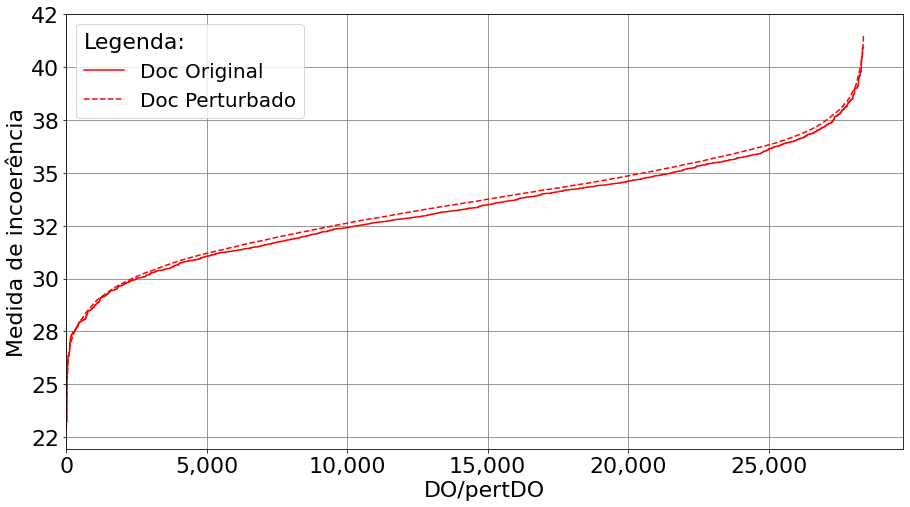

In [220]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CeucCWP, 
                    lista_perturbado_CeucCWP,
                    'r',
                    medida = medida)

Sem ordem

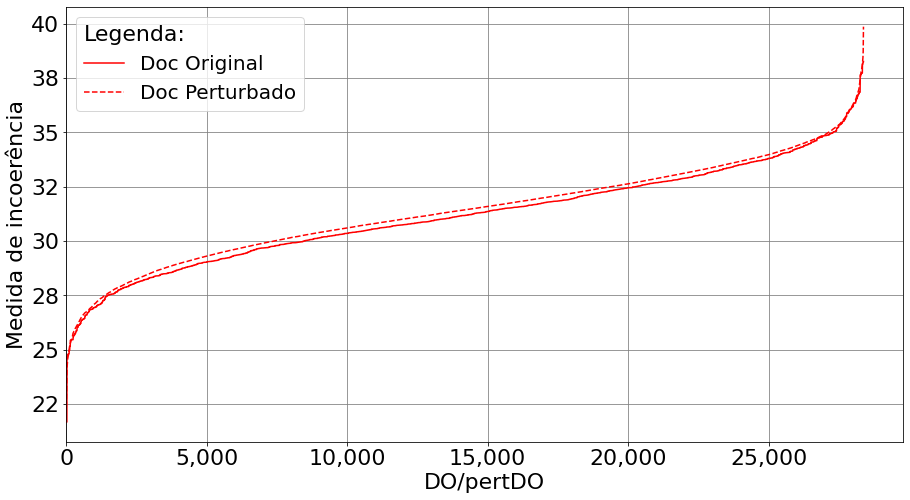

In [221]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CeucCAW, 
                    lista_perturbado_CeucCAW,
                    'r',
                    medida = 'euc')

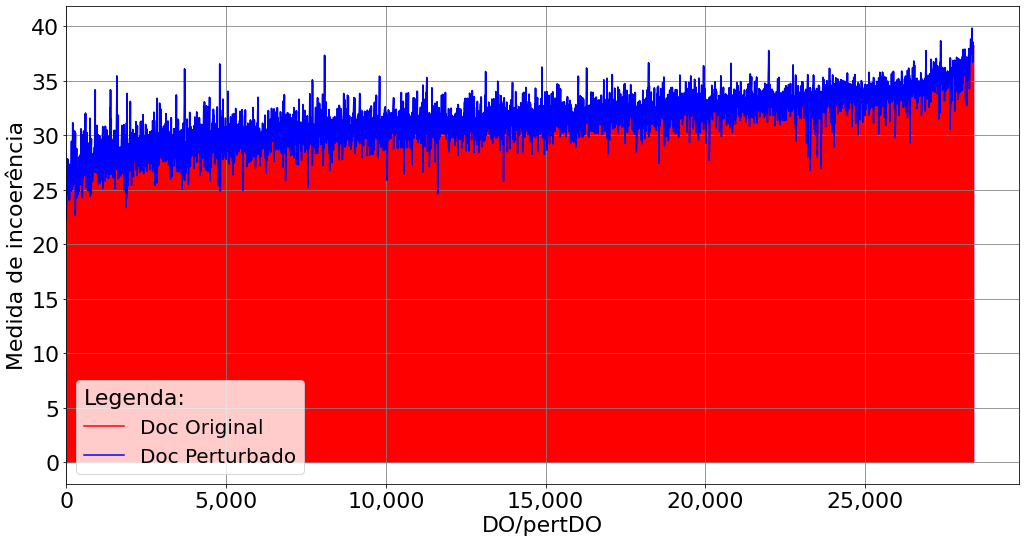

In [222]:
graficoLinhaMedida2Preenchido('Medida de incoerência', 
                              lista_original_ordenado_CeucCAW, 
                              lista_perturbado_ordenado_CeucCAW,
                              medida = 'euc')

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

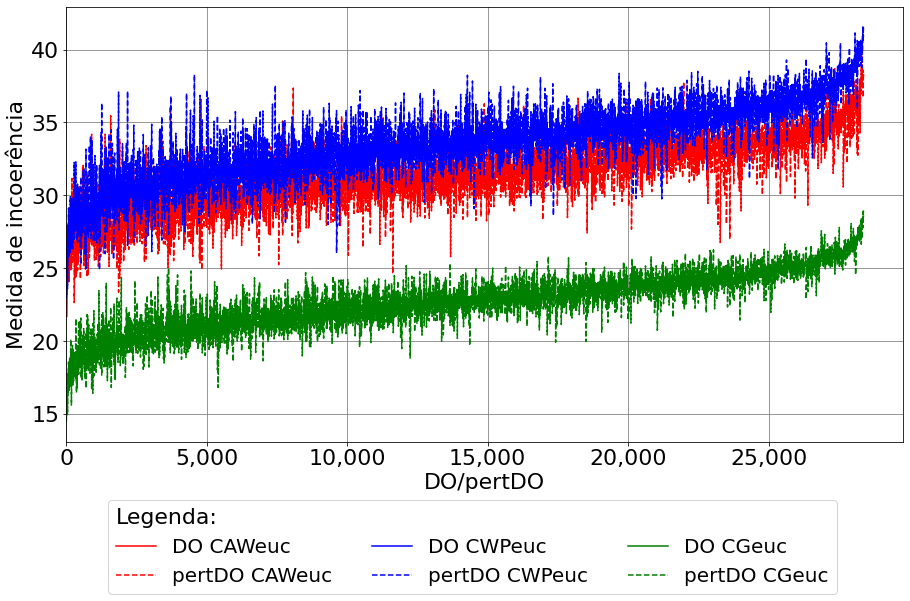

In [223]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW, 
                   lista_perturbado_ordenado_CeucCAW, 
                   lista_original_ordenado_CeucCWP, 
                   lista_perturbado_ordenado_CeucCWP, 
                   lista_original_ordenado_CeucCG, 
                   lista_perturbado_ordenado_CeucCG,
                   medida = medida)

In [224]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 22428.563986005043
Diferença absoluta entre as medidas equação CWP : 22308.19948823708
Diferença absoluta entre as medidas equação CG  : 14616.188384545298


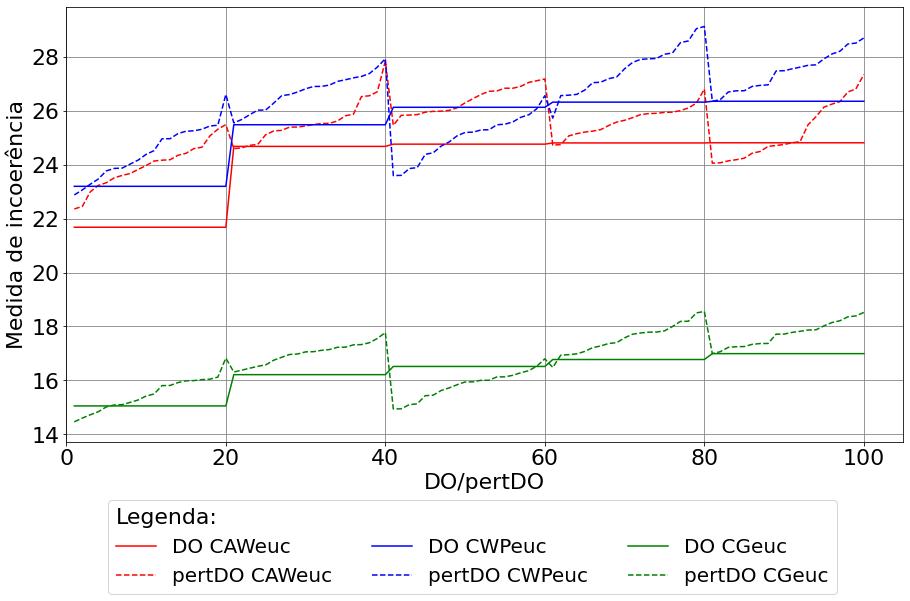

In [225]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[0:100], 
                   lista_perturbado_ordenado_CeucCAW[0:100], 
                   lista_original_ordenado_CeucCWP[0:100], 
                   lista_perturbado_ordenado_CeucCWP[0:100], 
                   lista_original_ordenado_CeucCG[0:100], 
                   lista_perturbado_ordenado_CeucCG[0:100],
                   medida = medida)

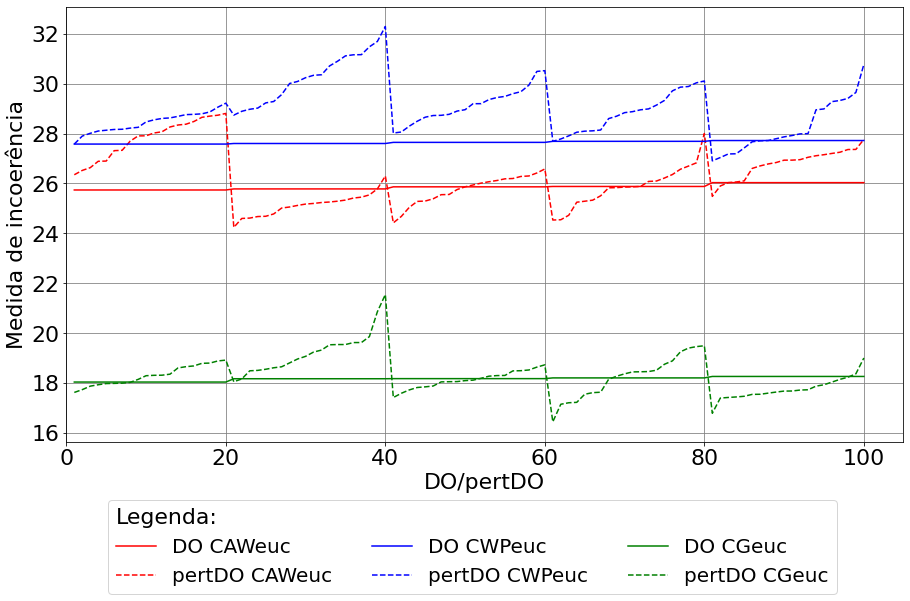

In [226]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[300:400], 
                   lista_perturbado_ordenado_CeucCAW[300:400], 
                   lista_original_ordenado_CeucCWP[300:400], 
                   lista_perturbado_ordenado_CeucCWP[300:400], 
                   lista_original_ordenado_CeucCG[300:400], 
                   lista_perturbado_ordenado_CeucCG[300:400],
                   medida = medida)

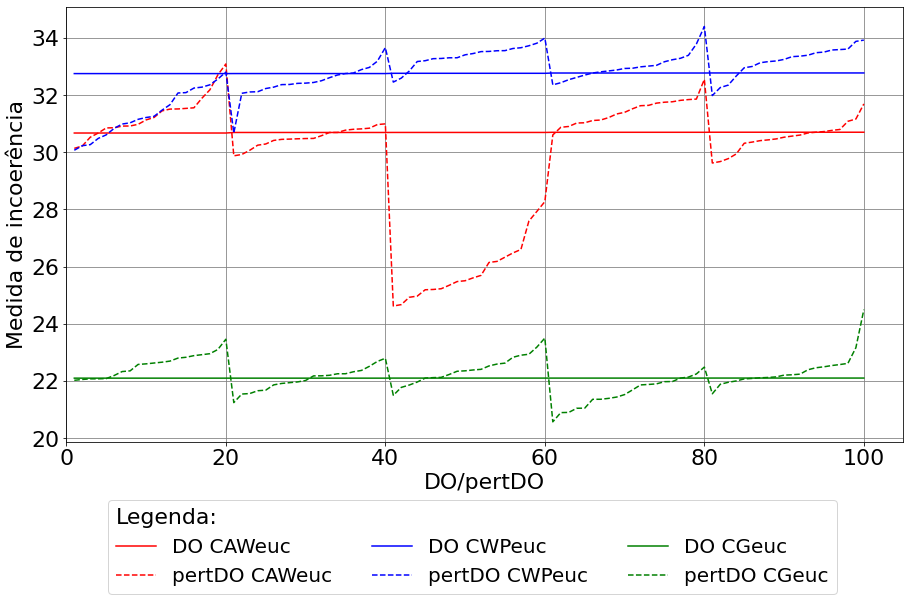

In [227]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CeucCAW[11580:11680], 
                   lista_perturbado_ordenado_CeucCAW[11580:11680], 
                   lista_original_ordenado_CeucCWP[11580:11680], 
                   lista_perturbado_ordenado_CeucCWP[11580:11680], 
                   lista_original_ordenado_CeucCG[11580:11680], 
                   lista_perturbado_ordenado_CeucCG[11580:11680],
                   medida = medida)

# DO central do gráfico com a maior diferença
# id = 56cdd21562d2951400fa68b2
# difabs=95.93362426757811
# Qual foi a intensidade escalada?
# Posição gráfico 582 * 20 = 11640

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [228]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 22428.563986005043

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5728f9a14b864d1900165160', 1.9153947035471717, 1242, 'Em que dia a empresa que tocou a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes?']
['570e5b3b0dc6ce1900204f8b', 2.509110980563669, 1374, 'As áreas de Docklands, St. Kilda Road e Southbank apresentam formas de alta ou baixa densidade?']
['5a69ba4d5ce1a5001a9696c9', 2.6942472839355176, 1340, 'Em que número de relatório ao Conselho o Procurador reconheceu que os crimes haviam sido cometidos, mas as evidências para a acusação eram suficientes?']
['5ad11ad3645df0001a2d0d93', 2.832534535725884, 1135, 'Quantas ogivas nucleares podem ser fabricadas com 450 toneladas de urânio altamente enriquecido para armas?']
['5

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [229]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 14243.706303898813

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5a8475107cf838001a46a810', 0.00405836105347035, 501, 'Quantos membros do conselho foram mortos no EIC?']
['57277abc5951b619008f8ae8', 0.0045288085937507105, 762, 'Onde a principal base industrial apareceu na Carolina do Norte?']
['56f72db03d8e2e1400e373e0', 0.010726408524945441, 945, 'Quem foi a flauta principal da Filarmônica de Viena em 1996?']
['5730467a04bcaa1900d77453', 0.010887690952849027, 1391, 'O que estava causando grandes perdas e aumentando a guerra aérea projetada para fazer?']
['5ad40158604f3c001a3ffd0c', 0.0121612548828125, 937, 'Que líder Khitan rejeitou os mongóis?']



Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [230]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [231]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
  1 - De que forma os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> forma(CAWeuc(pertDO)=29,2686019897)] - VERB/NOUN-0-0
  2 - De que maneira os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> maneira(CAWeuc(pertDO)=29,6043422699)] - VERB/NOUN-0-0
  3 - De que tipo os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> tipo(CAWeuc(pertDO)=30,6038921356)] - VERB/NOUN-0-0
  4 - De que tipos os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> tipos(CAWeuc(pertDO)=30,7009166718)] - VERB/NOUN-0-0
  5 - De que falam os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> falam(CAWeuc(pertDO)=30,8700229645)] - VERB/VERB-1-0
  6 - De que participam os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> participam(CAWeuc(pertDO)=31,0152980804)] - VERB/VERB-1-0
  7 - De que dependem os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> dependem(CAWeuc(pertDO)=31,14017

In [232]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5a4fe902af0d07001ae8cc7c_pert_0;De que servem os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;servem;VERB;33,1289878845;34,4429269155;22,8676573435;0,1968212873;0;1
5a4fe902af0d07001ae8cc7c_pert_1;De que são os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;são;AUX;31,1467971802;33,5656227112;22,2497283618;0,1718800962;0;0
5a4fe902af0d07001ae8cc7c_pert_2;De que vêm os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;vêm;VERB;32,5266361237;34,7638520559;22,8829388618;0,1439927220;0;1
5a4fe902af0d07001ae8cc7c_pert_3;De que forma os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;forma;NOUN;29,2686019897;30,977920405

##### Usando CAW onde Cm(pertDO)<Cm(DO) *

In [233]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 8184.857682106281

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5a516183ce860b001aa3fd77', 0.0012379884719848633, 1101, 'Qual artigo afirmava que, se uma petição fosse bem-sucedida, não havia necessidade de referendo?']
['5a67a1e3f038b7001ab0c38a', 0.0073975154331726856, 544, 'Que nome geralmente está associado à pré-escola?']
['573014c3a23a5019007fcd25', 0.007524251937866211, 657, 'Qual é o termo que se refere às áreas onde a radiação das antenas é zero?']
['57320e1ee17f3d1400422635', 0.007526061114141669, 699, 'Embora os irmãos Plymouth não tenham um nome denominacional, que nome geralmente é usado para eles?']
['56d12d3c17492d1400aabb6a', 0.00838

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [234]:
id_documento = "56cdd21562d2951400fa68b2"
id_documento = lista[-1:][0][0]

In [235]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56cdd21562d2951400fa68b2
DO: Qual foi a intensidade escalada?
     PRON AUX DET NOUN VERB PUNCT 
  1 - Qual foi a intensidade aplicada ? [escalada(CAWeuc(DO)=30,6948036194) -> aplicada(>CAWeuc(pertDO)=24,6204090118)] - VERB/VERB-1-0
  2 - Qual foi a intensidade total ? [escalada(CAWeuc(DO)=30,6948036194) -> total(>CAWeuc(pertDO)=24,6703159332)] - VERB/ADJ-0-0
  3 - Qual foi a intensidade dela ? [escalada(CAWeuc(DO)=30,6948036194) -> dela(>CAWeuc(pertDO)=24,9266029358)] - VERB/PRON-0-0
  4 - Qual foi a intensidade inicial ? [escalada(CAWeuc(DO)=30,6948036194) -> inicial(>CAWeuc(pertDO)=24,9676452637)] - VERB/ADJ-0-0
  5 - Qual foi a intensidade usada ? [escalada(CAWeuc(DO)=30,6948036194) -> usada(>CAWeuc(pertDO)=25,1899536133)] - VERB/VERB-1-0
  6 - Qual foi a intensidade dele ? [escalada(CAWeuc(DO)=30,6948036194) -> dele(>CAWeuc(pertDO)=25,2002811432)] - VERB/PRON-0-0
  7 - Qual foi a intensidade utilizada ? [escalada(CAWeuc(DO)=30,6948036194) -> utilizada(>CAWeuc(pertDO)=25,225

In [236]:
visualizaMedidasEquacoesCSV("57101890b654c5140001f7d6",
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 57101890b654c5140001f7d6
DO: Que perguntas correspondem às homossexuais?
     DET NOUN VERB ADP NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
57101890b654c5140001f7d6_pert_0;Que perguntas fazem às homossexuais ?;correspondem;VERB;33,3558204651;32,3634695689;20,8709761302;fazem;VERB;29,2626560211;29,1081087748;18,8008619944;0,4668880403;0;1
57101890b654c5140001f7d6_pert_1;Que perguntas fazer às homossexuais ?;correspondem;VERB;33,3558204651;32,3634695689;20,8709761302;fazer;VERB;28,8825214386;28,2095813751;18,2005670865;0,2838557065;0;1
57101890b654c5140001f7d6_pert_2;Que perguntas faz às homossexuais ?;correspondem;VERB;33,3558204651;32,3634695689;20,8709761302;faz;VERB;29,5427379608;28,6123987834;18,4753589630;0,0825906470;0;1
57101890b654c5140001f7d6_pert_3;Que perguntas fizeram às homossexuais ?;correspondem;VERB;33,3558204651;

#### Usando CWP

In [237]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 22308.19948823708

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5726d2ce5951b619008f7f19', 1.9357484102249316, 1183, 'Em que século foram usados detalhes góticos distintos em novas construções em Oxford e Cambridge?']
['56f76011a6d7ea1400e1721a', 2.587033132319398, 1385, 'Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido, em vez de invalidar completamente o consentimento?']
['5730bb522461fd1900a9d012', 2.801687383651739, 1237, 'a expansão dos EUA para o oeste poderia ser vista como que tipo de colonialismo?']
['5a0c96fbf5590b0018dab489', 2.8883986130258847, 1377, 'Empreendimentos comerciais estão usando GPS portátil e mapas do Google para minar as tribos indígenas o que?']
['572662b9708984140094c46f', 3.040774654

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [238]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 14088.065647765066

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56e1ded7cd28a01900c67bd5', 0.008488896128895362, 870, 'Qual é o nome de um problema que atende à afirmação de Ladner?']
['572ffa79a23a5019007fcbe9', 0.009252442253959714, 1141, 'O atual Mar Mediterrâneo desce de que mar?']
['56de73fd4396321400ee2939', 0.017259805852717136, 941, 'Qual revista chamou o imigrante mais famoso da Schwarzenegger America?']
['5ad3f258604f3c001a3ff8a7', 0.020638359917533933, 1164, 'Qual era o nome do pescador na tradição que teve uma visão de São Paulo perto da Abadia?']
['5711488ab654c5140001fc41', 0.03416872303387919, 1333, 'Juntamente com a admissão, esc

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [239]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [240]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
  1 - De que forma os neutrófilos ? [resultam(>CWPeuc(DO)=29,6221960704) -> forma(CWPeuc(pertDO)=30,9779204051)] - VERB/NOUN-0-0
  2 - De que maneira os neutrófilos ? [resultam(>CWPeuc(DO)=29,6221960704) -> maneira(CWPeuc(pertDO)=31,1036946615)] - VERB/NOUN-0-0
  3 - De que tipo os neutrófilos ? [resultam(>CWPeuc(DO)=29,6221960704) -> tipo(CWPeuc(pertDO)=31,5794975281)] - VERB/NOUN-0-0
  4 - De que tipos os neutrófilos ? [resultam(>CWPeuc(DO)=29,6221960704) -> tipos(CWPeuc(pertDO)=31,8686873118)] - VERB/NOUN-0-0
  5 - De que falam os neutrófilos ? [resultam(>CWPeuc(DO)=29,6221960704) -> falam(CWPeuc(pertDO)=32,0610608419)] - VERB/VERB-1-0
  6 - De que dependem os neutrófilos ? [resultam(>CWPeuc(DO)=29,6221960704) -> dependem(CWPeuc(pertDO)=32,2621920268)] - VERB/VERB-1-0
  7 - De que participam os neutrófilos ? [resultam(>CWPeuc(DO)=29,6221960704) -> participam(CWPeuc(pertDO)=32,26552

In [241]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5a4fe902af0d07001ae8cc7c_pert_0;De que servem os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;servem;VERB;33,1289878845;34,4429269155;22,8676573435;0,1968212873;0;1
5a4fe902af0d07001ae8cc7c_pert_1;De que são os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;são;AUX;31,1467971802;33,5656227112;22,2497283618;0,1718800962;0;0
5a4fe902af0d07001ae8cc7c_pert_2;De que vêm os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;vêm;VERB;32,5266361237;34,7638520559;22,8829388618;0,1439927220;0;1
5a4fe902af0d07001ae8cc7c_pert_3;De que forma os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;forma;NOUN;29,2686019897;30,977920405

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [242]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 8220.133840471852

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5a8475a07cf838001a46a81a', 0.007766299777557606, 552, 'Quem acabou por falir devido ao seu monopólio virtual?']
['56d28b0659d6e41400146065', 0.009670459862910263, 1119, 'O budismo ocidental é frequentemente visto como exótico e o quê?']
['5726d31af1498d1400e8ec64', 0.009757450648720578, 940, 'Qual é um termo frequentemente usado para a retirada britânica da União Europeia?']
['5ad19782645df0001a2d20d0', 0.011005054820657278, 1313, 'os não LEDs são frequentemente usados para que tipo de sistemas?']
['5a7b849921c2de001afea0f1', 0.019616179032759362, 428, 'Quais descrições do firmware s

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [243]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [244]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56cdd21562d2951400fa68b2
DO: Qual foi a intensidade escalada?
     PRON AUX DET NOUN VERB PUNCT 
  1 - Qual foi a intensidade dela ? [escalada(CWPeuc(DO)=32,3554883321) -> dela(>CWPeuc(pertDO)=26,0396597544)] - VERB/PRON-0-0
  2 - Qual foi a intensidade total ? [escalada(CWPeuc(DO)=32,3554883321) -> total(>CWPeuc(pertDO)=26,2756036123)] - VERB/ADJ-0-0
  3 - Qual foi a intensidade dele ? [escalada(CWPeuc(DO)=32,3554883321) -> dele(>CWPeuc(pertDO)=26,4049238841)] - VERB/PRON-0-0
  4 - Qual foi a intensidade usada ? [escalada(CWPeuc(DO)=32,3554883321) -> usada(>CWPeuc(pertDO)=26,4878147125)] - VERB/VERB-1-0
  5 - Qual foi a intensidade delas ? [escalada(CWPeuc(DO)=32,3554883321) -> delas(>CWPeuc(pertDO)=26,4947990417)] - VERB/PRON-0-0
  6 - Qual foi a intensidade deles ? [escalada(CWPeuc(DO)=32,3554883321) -> deles(>CWPeuc(pertDO)=26,6070377350)] - VERB/PRON-0-0
  7 - Qual foi a intensidade disso ? [escalada(CWPeuc(DO)=32,3554883321) -> disso(>CWPeuc(pertDO)=26,6121309916)] - VERB/

In [245]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56cdd21562d2951400fa68b2
DO: Qual foi a intensidade escalada?
     PRON AUX DET NOUN VERB PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
56cdd21562d2951400fa68b2_pert_0;Qual foi a intensidade dela ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;dela;PRON;24,9266029358;26,0396597544;16,8209840457;0,4185869098;0;0
56cdd21562d2951400fa68b2_pert_1;Qual foi a intensidade dele ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;dele;PRON;25,2002811432;26,4049238841;17,0683045387;0,1208369881;0;0
56cdd21562d2951400fa68b2_pert_2;Qual foi a intensidade delas ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;delas;PRON;25,4771224976;26,4947990417;17,1094562213;0,0759382918;0;0
56cdd21562d2951400fa68b2_pert_3;Qual foi a intensidade disso ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;disso;PRON;26,3300796509;26,6

#### Usando CG

In [246]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 14616.188384545298

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5726d2ce5951b619008f7f19', 1.3130583763122488, 1191, 'Em que século foram usados detalhes góticos distintos em novas construções em Oxford e Cambridge?']
['56f76011a6d7ea1400e1721a', 1.6581376117208961, 1393, 'Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido, em vez de invalidar completamente o consentimento?']
['5730bb522461fd1900a9d012', 2.0498002767562937, 1234, 'a expansão dos EUA para o oeste poderia ser vista como que tipo de colonialismo?']
['572662b9708984140094c46f', 2.117767582768977, 1366, 'Que conceito se baseia na adesão aos Marcos Maçônicos, nos requisitos básicos de associação e nos princípios e rituais da arte?']
['5a69ba4d5ce1a5001a9

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [247]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 9120.324730415943

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56e1ded7cd28a01900c67bd5', 0.00281279427664316, 930, 'Qual é o nome de um problema que atende à afirmação de Ladner?']
['572ffa79a23a5019007fcbe9', 0.015533023410373659, 1006, 'O atual Mar Mediterrâneo desce de que mar?']
['5ad2cf36d7d075001a42a308', 0.016360282897942113, 1064, 'Quantas músicas o Law Review publica a cada ano?']
['56fc44bb2603e7140040a04b', 0.020089662992038626, 977, 'Que tipo de estudo de linguagem envolve tentar deduzir os fonos subjacentes?']
['573173d8497a881900248f0d', 0.0281298160552943, 1416, 'Que violação pode resultar em apedrejamento e foi apoiada por 82% dos

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [248]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [249]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
  1 - De que forma os neutrófilos ? [resultam(>CGeuc(DO)=19,6790641149) -> forma(CGeuc(pertDO)=20,7506259282)] - VERB/NOUN-0-0
  2 - De que maneira os neutrófilos ? [resultam(>CGeuc(DO)=19,6790641149) -> maneira(CGeuc(pertDO)=20,8663733800)] - VERB/NOUN-0-0
  3 - De que tipo os neutrófilos ? [resultam(>CGeuc(DO)=19,6790641149) -> tipo(CGeuc(pertDO)=21,1555674871)] - VERB/NOUN-0-0
  4 - De que tipos os neutrófilos ? [resultam(>CGeuc(DO)=19,6790641149) -> tipos(CGeuc(pertDO)=21,3181153933)] - VERB/NOUN-0-0
  5 - De que falam os neutrófilos ? [resultam(>CGeuc(DO)=19,6790641149) -> falam(CGeuc(pertDO)=21,3377011617)] - VERB/VERB-1-0
  6 - De que participam os neutrófilos ? [resultam(>CGeuc(DO)=19,6790641149) -> participam(CGeuc(pertDO)=21,4231508573)] - VERB/VERB-1-0
  7 - De que dependem os neutrófilos ? [resultam(>CGeuc(DO)=19,6790641149) -> dependem(CGeuc(pertDO)=21,4869751930)] - VERB

In [250]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5a4fe902af0d07001ae8cc7c_pert_0;De que servem os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;servem;VERB;33,1289878845;34,4429269155;22,8676573435;0,1968212873;0;1
5a4fe902af0d07001ae8cc7c_pert_1;De que são os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;são;AUX;31,1467971802;33,5656227112;22,2497283618;0,1718800962;0;0
5a4fe902af0d07001ae8cc7c_pert_2;De que vêm os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;vêm;VERB;32,5266361237;34,7638520559;22,8829388618;0,1439927220;0;1
5a4fe902af0d07001ae8cc7c_pert_3;De que forma os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;forma;NOUN;29,2686019897;30,977920405

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [251]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 5495.863654129353

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['572fad2cb2c2fd1400568318', 0.0007431507110595703, 1266, 'Como as vesículas de gás produzidas por cianobactérias a ajudam a se mover na água?']
['570da18bdf2f5219002ed078', 0.0022891651500316357, 550, 'Quando a Lei de Conservação Antártica foi aprovada pelos EUA?']
['5ad3102b604f3c001a3fdb23', 0.0037987709045381735, 1213, 'O que um cardeal leigo não pode fazer e que não é considerado um status normal de um cardeal?']
['57304973947a6a140053d3b2', 0.005635070800789066, 1346, 'Que distrito médico está experimentando crescimento no campo da biotecnologia e da pesquisa médica?']
['5acfb6df77

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [252]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [253]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56cdd21562d2951400fa68b2
DO: Qual foi a intensidade escalada?
     PRON AUX DET NOUN VERB PUNCT 
  1 - Qual foi a intensidade dela ? [escalada(CGeuc(DO)=20,8719660441) -> dela(>CGeuc(pertDO)=16,8209840457)] - VERB/PRON-0-0
  2 - Qual foi a intensidade total ? [escalada(CGeuc(DO)=20,8719660441) -> total(>CGeuc(pertDO)=16,9598976771)] - VERB/ADJ-0-0
  3 - Qual foi a intensidade dele ? [escalada(CGeuc(DO)=20,8719660441) -> dele(>CGeuc(pertDO)=17,0683045387)] - VERB/PRON-0-0
  4 - Qual foi a intensidade usada ? [escalada(CGeuc(DO)=20,8719660441) -> usada(>CGeuc(pertDO)=17,0997996330)] - VERB/VERB-1-0
  5 - Qual foi a intensidade delas ? [escalada(CGeuc(DO)=20,8719660441) -> delas(>CGeuc(pertDO)=17,1094562213)] - VERB/PRON-0-0
  6 - Qual foi a intensidade disso ? [escalada(CGeuc(DO)=20,8719660441) -> disso(>CGeuc(pertDO)=17,1455696424)] - VERB/PRON-0-0
  7 - Qual foi a intensidade deles ? [escalada(CGeuc(DO)=20,8719660441) -> deles(>CGeuc(pertDO)=17,1867459615)] - VERB/PRON-0-0
  8 -

In [254]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56cdd21562d2951400fa68b2
DO: Qual foi a intensidade escalada?
     PRON AUX DET NOUN VERB PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
56cdd21562d2951400fa68b2_pert_0;Qual foi a intensidade dela ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;dela;PRON;24,9266029358;26,0396597544;16,8209840457;0,4185869098;0;0
56cdd21562d2951400fa68b2_pert_1;Qual foi a intensidade dele ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;dele;PRON;25,2002811432;26,4049238841;17,0683045387;0,1208369881;0;0
56cdd21562d2951400fa68b2_pert_2;Qual foi a intensidade delas ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;delas;PRON;25,4771224976;26,4947990417;17,1094562213;0,0759382918;0;0
56cdd21562d2951400fa68b2_pert_3;Qual foi a intensidade disso ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;disso;PRON;26,3300796509;26,6

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [255]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 5495.863654129353

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5728f9a14b864d1900165160', 0.21967267990112305, 1242, 'Em que dia a empresa que tocou a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes?']
['5726d752dd62a815002e9211', 0.3981788341815644, 1378, 'O estudo de 2008 relacionado à morte de Napoleão constatou que os cabelos coletados dos cabelos de Napoleão, assim como de sua família e contemporâneos, tinham níveis de arsênico aproximadamente quantas vezes maiores que as médias atuais?']
['56fb7490b28b3419009f1d5e', 0.40098019650107375, 1416, 'Junto com a Suécia e a Noruega, que país assistiu à atividade missionária nos séculos 9 e 10?']
['5730bb522461fd1900a9d012',

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [256]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 5495.863654129353

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5a8475107cf838001a46a810', 0.00405836105347035, 501, 'Quantos membros do conselho foram mortos no EIC?']
['57277abc5951b619008f8ae8', 0.0045288085937507105, 762, 'Onde a principal base industrial apareceu na Carolina do Norte?']
['56f72db03d8e2e1400e373e0', 0.010726408524945441, 945, 'Quem foi a flauta principal da Filarmônica de Viena em 1996?']
['5730467a04bcaa1900d77453', 0.010887690952849027, 1391, 'O que estava causando grandes perdas e aumentando a guerra aérea projetada para fazer?']
['5ad40158604f3c001a3ffd0c', 0.0121612548828125, 937, 'Que líder Khitan rejeitou os mongóis?']

Os 5 último

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [257]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [258]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
  1 - De que forma os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> forma(CAWeuc(pertDO)=29,2686019897)] - VERB/NOUN-0-0
  2 - De que maneira os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> maneira(CAWeuc(pertDO)=29,6043422699)] - VERB/NOUN-0-0
  3 - De que tipo os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> tipo(CAWeuc(pertDO)=30,6038921356)] - VERB/NOUN-0-0
  4 - De que tipos os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> tipos(CAWeuc(pertDO)=30,7009166718)] - VERB/NOUN-0-0
  5 - De que falam os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> falam(CAWeuc(pertDO)=30,8700229645)] - VERB/VERB-1-0
  6 - De que participam os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> participam(CAWeuc(pertDO)=31,0152980804)] - VERB/VERB-1-0
  7 - De que dependem os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> dependem(CAWeuc(pertDO)=31,14017

In [259]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5a4fe902af0d07001ae8cc7c_pert_0;De que servem os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;servem;VERB;33,1289878845;34,4429269155;22,8676573435;0,1968212873;0;1
5a4fe902af0d07001ae8cc7c_pert_1;De que são os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;são;AUX;31,1467971802;33,5656227112;22,2497283618;0,1718800962;0;0
5a4fe902af0d07001ae8cc7c_pert_2;De que vêm os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;vêm;VERB;32,5266361237;34,7638520559;22,8829388618;0,1439927220;0;1
5a4fe902af0d07001ae8cc7c_pert_3;De que forma os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;forma;NOUN;29,2686019897;30,977920405

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [260]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 5495.863654129353

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5a516183ce860b001aa3fd77', 0.0012379884719848633, 1101, 'Qual artigo afirmava que, se uma petição fosse bem-sucedida, não havia necessidade de referendo?']
['5a67a1e3f038b7001ab0c38a', 0.0073975154331726856, 544, 'Que nome geralmente está associado à pré-escola?']
['573014c3a23a5019007fcd25', 0.007524251937866211, 657, 'Qual é o termo que se refere às áreas onde a radiação das antenas é zero?']
['57320e1ee17f3d1400422635', 0.007526061114141669, 699, 'Embora os irmãos Plymouth não tenham um nome denominacional, que nome geralmente é usado para eles?']
['56d12d3c17492d1400aabb6a', 0.008389578925243

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [261]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [262]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a611ac3e9e1cc001a33cf1c
DO: O que substituiu objetos de metal?
     PRON PRON VERB NOUN ADP NOUN PUNCT 
  1 - O que são objetos de metal ? [substituiu(CAWeuc(DO)=33,2684822083) -> são(>CAWeuc(pertDO)=26,7601016363)] - VERB/AUX-0-0
  2 - O que eram objetos de metal ? [substituiu(CAWeuc(DO)=33,2684822083) -> eram(>CAWeuc(pertDO)=27,1367734273)] - VERB/AUX-0-0
  3 - O que envolve objetos de metal ? [substituiu(CAWeuc(DO)=33,2684822083) -> envolve(>CAWeuc(pertDO)=27,5112120310)] - VERB/VERB-1-0
  4 - O que seriam objetos de metal ? [substituiu(CAWeuc(DO)=33,2684822083) -> seriam(>CAWeuc(pertDO)=27,7111603419)] - VERB/AUX-0-0
  5 - O que sejam objetos de metal ? [substituiu(CAWeuc(DO)=33,2684822083) -> sejam(>CAWeuc(pertDO)=27,9864425659)] - VERB/VERB-1-0
  6 - O que representam objetos de metal ? [substituiu(CAWeuc(DO)=33,2684822083) -> representam(>CAWeuc(pertDO)=28,1214259466)] - VERB/VERB-1-0
  7 - O que representa objetos de metal ? [substituiu(CAWeuc(DO)=33,2684822083) -> repr

In [263]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a611ac3e9e1cc001a33cf1c
DO: O que substituiu objetos de metal?
     PRON PRON VERB NOUN ADP NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5a611ac3e9e1cc001a33cf1c_pert_0;O que são objetos de metal ?;substituiu;VERB;33,2684822083;34,0656068893;22,2171530042;são;AUX;26,7601016363;29,0811481476;19,1806971686;0,9631913900;0;0
5a611ac3e9e1cc001a33cf1c_pert_1;O que seriam objetos de metal ?;substituiu;VERB;33,2684822083;34,0656068893;22,2171530042;seriam;AUX;27,7111603419;29,5893580119;19,4940605164;0,0102391746;0;0
5a611ac3e9e1cc001a33cf1c_pert_2;O que é objetos de metal ?;substituiu;VERB;33,2684822083;34,0656068893;22,2171530042;é;AUX;30,7387266159;33,0482293084;21,7017195565;0,0059008105;0;0
5a611ac3e9e1cc001a33cf1c_pert_3;O que significa objetos de metal ?;substituiu;VERB;33,2684822083;34,0656068893;22,2171530042;significa;VERB;28,

#### Usando CWP






In [264]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 5495.863654129353

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5726d2ce5951b619008f7f19', 0.23347662289937432, 1183, 'Em que século foram usados detalhes góticos distintos em novas construções em Oxford e Cambridge?']
['5730bb522461fd1900a9d012', 0.32790250778198526, 1237, 'a expansão dos EUA para o oeste poderia ser vista como que tipo de colonialismo?']
['56f76011a6d7ea1400e1721a', 0.34244535468783965, 1385, 'Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido, em vez de invalidar completamente o consentimento?']
['572662b9708984140094c46f', 0.34922633717653184, 1357, 'Que conceito se baseia na adesão aos Marcos Maçônicos, nos requisitos básicos de associação e n

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [265]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 5495.863654129353

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56e1ded7cd28a01900c67bd5', 0.008488896128895362, 870, 'Qual é o nome de um problema que atende à afirmação de Ladner?']
['572ffa79a23a5019007fcbe9', 0.009252442253959714, 1141, 'O atual Mar Mediterrâneo desce de que mar?']
['56de73fd4396321400ee2939', 0.017259805852717136, 941, 'Qual revista chamou o imigrante mais famoso da Schwarzenegger America?']
['5ad3f258604f3c001a3ff8a7', 0.020638359917533933, 1164, 'Qual era o nome do pescador na tradição que teve uma visão de São Paulo perto da Abadia?']
['572813642ca10214002d9d5e', 0.028891788829461973, 991, 'Quem fundou o teatro de comédia de Amsterdã 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [266]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [267]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
  1 - De que forma os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> forma(CAWeuc(pertDO)=29,2686019897)] - VERB/NOUN-0-0
  2 - De que maneira os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> maneira(CAWeuc(pertDO)=29,6043422699)] - VERB/NOUN-0-0
  3 - De que tipo os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> tipo(CAWeuc(pertDO)=30,6038921356)] - VERB/NOUN-0-0
  4 - De que tipos os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> tipos(CAWeuc(pertDO)=30,7009166718)] - VERB/NOUN-0-0
  5 - De que falam os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> falam(CAWeuc(pertDO)=30,8700229645)] - VERB/VERB-1-0
  6 - De que participam os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> participam(CAWeuc(pertDO)=31,0152980804)] - VERB/VERB-1-0
  7 - De que dependem os neutrófilos ? [resultam(>CAWeuc(DO)=27,5448009491) -> dependem(CAWeuc(pertDO)=31,14017

In [268]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5a4fe902af0d07001ae8cc7c_pert_0;De que servem os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;servem;VERB;33,1289878845;34,4429269155;22,8676573435;0,1968212873;0;1
5a4fe902af0d07001ae8cc7c_pert_1;De que são os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;são;AUX;31,1467971802;33,5656227112;22,2497283618;0,1718800962;0;0
5a4fe902af0d07001ae8cc7c_pert_2;De que vêm os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;vêm;VERB;32,5266361237;34,7638520559;22,8829388618;0,1439927220;0;1
5a4fe902af0d07001ae8cc7c_pert_3;De que forma os neutrófilos ?;resultam;VERB;27,5448009491;29,6221960704;19,6790641149;forma;NOUN;29,2686019897;30,977920405

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [269]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 5495.863654129353

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5a8475a07cf838001a46a81a', 0.007766299777557606, 552, 'Quem acabou por falir devido ao seu monopólio virtual?']
['56d28b0659d6e41400146065', 0.009670459862910263, 1119, 'O budismo ocidental é frequentemente visto como exótico e o quê?']
['5726d31af1498d1400e8ec64', 0.009757450648720578, 940, 'Qual é um termo frequentemente usado para a retirada britânica da União Europeia?']
['5ad19782645df0001a2d20d0', 0.011005054820657278, 1313, 'os não LEDs são frequentemente usados para que tipo de sistemas?']
['5a82162231013a001a3351bd', 0.01700748716081435, 112, 'Qual é o outro nome da sílaba?']

Os 5 últim

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [270]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [271]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56cdd21562d2951400fa68b2
DO: Qual foi a intensidade escalada?
     PRON AUX DET NOUN VERB PUNCT 
  1 - Qual foi a intensidade aplicada ? [escalada(CAWeuc(DO)=30,6948036194) -> aplicada(>CAWeuc(pertDO)=24,6204090118)] - VERB/VERB-1-0
  2 - Qual foi a intensidade total ? [escalada(CAWeuc(DO)=30,6948036194) -> total(>CAWeuc(pertDO)=24,6703159332)] - VERB/ADJ-0-0
  3 - Qual foi a intensidade dela ? [escalada(CAWeuc(DO)=30,6948036194) -> dela(>CAWeuc(pertDO)=24,9266029358)] - VERB/PRON-0-0
  4 - Qual foi a intensidade inicial ? [escalada(CAWeuc(DO)=30,6948036194) -> inicial(>CAWeuc(pertDO)=24,9676452637)] - VERB/ADJ-0-0
  5 - Qual foi a intensidade usada ? [escalada(CAWeuc(DO)=30,6948036194) -> usada(>CAWeuc(pertDO)=25,1899536133)] - VERB/VERB-1-0
  6 - Qual foi a intensidade dele ? [escalada(CAWeuc(DO)=30,6948036194) -> dele(>CAWeuc(pertDO)=25,2002811432)] - VERB/PRON-0-0
  7 - Qual foi a intensidade utilizada ? [escalada(CAWeuc(DO)=30,6948036194) -> utilizada(>CAWeuc(pertDO)=25,225

In [272]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56cdd21562d2951400fa68b2
DO: Qual foi a intensidade escalada?
     PRON AUX DET NOUN VERB PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
56cdd21562d2951400fa68b2_pert_0;Qual foi a intensidade dela ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;dela;PRON;24,9266029358;26,0396597544;16,8209840457;0,4185869098;0;0
56cdd21562d2951400fa68b2_pert_1;Qual foi a intensidade dele ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;dele;PRON;25,2002811432;26,4049238841;17,0683045387;0,1208369881;0;0
56cdd21562d2951400fa68b2_pert_2;Qual foi a intensidade delas ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;delas;PRON;25,4771224976;26,4947990417;17,1094562213;0,0759382918;0;0
56cdd21562d2951400fa68b2_pert_3;Qual foi a intensidade disso ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;disso;PRON;26,3300796509;26,6

#### Usando CG






In [273]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 5495.863654129353

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5726d2ce5951b619008f7f19', 0.16069865226745605, 1191, 'Em que século foram usados detalhes góticos distintos em novas construções em Oxford e Cambridge?']
['56f76011a6d7ea1400e1721a', 0.18805794093919914, 1393, 'Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido, em vez de invalidar completamente o consentimento?']
['5730bb522461fd1900a9d012', 0.23267674446105957, 1234, 'a expansão dos EUA para o oeste poderia ser vista como que tipo de colonialismo?']
['5a0c96fbf5590b0018dab489', 0.24924108717177162, 1378, 'Empreendimentos comerciais estão usando GPS portátil e mapas do Google para minar as tribos indíg

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [274]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 5495.863654129353

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56e1ded7cd28a01900c67bd5', 0.00281279427664316, 930, 'Qual é o nome de um problema que atende à afirmação de Ladner?']
['572ffa79a23a5019007fcbe9', 0.015533023410373659, 1006, 'O atual Mar Mediterrâneo desce de que mar?']
['5ad2cf36d7d075001a42a308', 0.016360282897942113, 1064, 'Quantas músicas o Law Review publica a cada ano?']
['56fc44bb2603e7140040a04b', 0.020089662992038626, 977, 'Que tipo de estudo de linguagem envolve tentar deduzir os fonos subjacentes?']
['573173d8497a881900248f0d', 0.0281298160552943, 1416, 'Que violação pode resultar em apedrejamento e foi apoiada por 82% dos respondentes

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [275]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [276]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a86115eb4e223001a8e7443
DO: Onde é proibido comer pato?
     ADV AUX VERB VERB NOUN PUNCT 
  1 - Onde é possível comer pato ? [proibido(CAWeuc(DO)=28,9800273895) -> possível(>CAWeuc(pertDO)=27,5424777985)] - VERB/ADJ-0-0
  2 - Onde é permitido comer pato ? [proibido(CAWeuc(DO)=28,9800273895) -> permitido(>CAWeuc(pertDO)=28,8075771332)] - VERB/VERB-1-0
  3 - Onde é bom comer pato ? [proibido(CAWeuc(DO)=28,9800273895) -> bom(>CAWeuc(pertDO)=28,8242080688)] - VERB/ADJ-0-0
  4 - Onde é proibido comer pato ? [proibido(>CAWeuc(DO)=28,9800273895) -> proibido(CAWeuc(pertDO)=28,9800273895)] - VERB/VERB-1-1
  5 - Onde é certo comer pato ? [proibido(>CAWeuc(DO)=28,9800273895) -> certo(CAWeuc(pertDO)=29,0344020844)] - VERB/ADJ-0-0
  6 - Onde é legal comer pato ? [proibido(>CAWeuc(DO)=28,9800273895) -> legal(CAWeuc(pertDO)=29,5111034393)] - VERB/ADJ-0-0
  7 - Onde é preciso comer pato ? [proibido(>CAWeuc(DO)=28,9800273895) -> preciso(CAWeuc(pertDO)=29,6624256134)] - VERB/ADJ-0-0
  8 - Onde 

In [277]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a86115eb4e223001a8e7443
DO: Onde é proibido comer pato?
     ADV AUX VERB VERB NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
5a86115eb4e223001a8e7443_pert_0;Onde é proibido comer pato ?;proibido;VERB;28,9800273895;29,8115371704;19,2230787277;proibido;VERB;28,9800273895;29,8115371704;19,2230787277;0,3838050365;1;1
5a86115eb4e223001a8e7443_pert_1;Onde é possível comer pato ?;proibido;VERB;28,9800273895;29,8115371704;19,2230787277;possível;ADJ;27,5424777985;28,3071461995;18,2473079364;0,1419289410;0;0
5a86115eb4e223001a8e7443_pert_2;Onde é que comer pato ?;proibido;VERB;28,9800273895;29,8115371704;19,2230787277;que;SCONJ;34,6282371521;34,7197469076;22,3991835912;0,1154284701;0;0
5a86115eb4e223001a8e7443_pert_3;Onde é permitido comer pato ?;proibido;VERB;28,9800273895;29,8115371704;19,2230787277;permitido;VERB;28,8075771332;29,555791

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [278]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 5495.863654129353

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['572fad2cb2c2fd1400568318', 0.0007431507110595703, 1266, 'Como as vesículas de gás produzidas por cianobactérias a ajudam a se mover na água?']
['570da18bdf2f5219002ed078', 0.0022891651500316357, 550, 'Quando a Lei de Conservação Antártica foi aprovada pelos EUA?']
['5ad3102b604f3c001a3fdb23', 0.0037987709045381735, 1213, 'O que um cardeal leigo não pode fazer e que não é considerado um status normal de um cardeal?']
['57304973947a6a140053d3b2', 0.005635070800789066, 1346, 'Que distrito médico está experimentando crescimento no campo da biotecnologia e da pesquisa médica?']
['5acfb6df77cf76001a685a1

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [279]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [280]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56cdd21562d2951400fa68b2
DO: Qual foi a intensidade escalada?
     PRON AUX DET NOUN VERB PUNCT 
  1 - Qual foi a intensidade aplicada ? [escalada(CAWeuc(DO)=30,6948036194) -> aplicada(>CAWeuc(pertDO)=24,6204090118)] - VERB/VERB-1-0
  2 - Qual foi a intensidade total ? [escalada(CAWeuc(DO)=30,6948036194) -> total(>CAWeuc(pertDO)=24,6703159332)] - VERB/ADJ-0-0
  3 - Qual foi a intensidade dela ? [escalada(CAWeuc(DO)=30,6948036194) -> dela(>CAWeuc(pertDO)=24,9266029358)] - VERB/PRON-0-0
  4 - Qual foi a intensidade inicial ? [escalada(CAWeuc(DO)=30,6948036194) -> inicial(>CAWeuc(pertDO)=24,9676452637)] - VERB/ADJ-0-0
  5 - Qual foi a intensidade usada ? [escalada(CAWeuc(DO)=30,6948036194) -> usada(>CAWeuc(pertDO)=25,1899536133)] - VERB/VERB-1-0
  6 - Qual foi a intensidade dele ? [escalada(CAWeuc(DO)=30,6948036194) -> dele(>CAWeuc(pertDO)=25,2002811432)] - VERB/PRON-0-0
  7 - Qual foi a intensidade utilizada ? [escalada(CAWeuc(DO)=30,6948036194) -> utilizada(>CAWeuc(pertDO)=25,225

In [281]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 56cdd21562d2951400fa68b2
DO: Qual foi a intensidade escalada?
     PRON AUX DET NOUN VERB PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
56cdd21562d2951400fa68b2_pert_0;Qual foi a intensidade dela ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;dela;PRON;24,9266029358;26,0396597544;16,8209840457;0,4185869098;0;0
56cdd21562d2951400fa68b2_pert_1;Qual foi a intensidade dele ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;dele;PRON;25,2002811432;26,4049238841;17,0683045387;0,1208369881;0;0
56cdd21562d2951400fa68b2_pert_2;Qual foi a intensidade delas ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;delas;PRON;25,4771224976;26,4947990417;17,1094562213;0,0759382918;0;0
56cdd21562d2951400fa68b2_pert_3;Qual foi a intensidade disso ?;escalada;VERB;30,6948036194;32,3554883321;20,8719660441;disso;PRON;26,3300796509;26,6

## 3.7 Avaliando o cálculo da incoerência com todas as equações e com a medida de distância manhattan(man)









In [282]:
medida = 'man'

### Estatística

#### CAW

In [283]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 16870 de 28380
Percentual de documentos coerentes em relação ao total: 59.443269908386185
Acertos Perturbado : 11510 de 28380
Percentual de documentos incoerentes em relação ao total: 40.556730091613815


#### CWP

In [284]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 16805 de 28380
Percentual de documentos coerentes em relação ao total: 59.21423537702607
Acertos Perturbado : 11575 de 28380
Percentual de documentos incoerentes em relação ao total: 40.78576462297392


#### CG

In [285]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 16612 de 28380
Percentual de documentos coerentes em relação ao total: 58.534178999295285
Acertos Perturbado : 11768 de 28380
Percentual de documentos incoerentes em relação ao total: 41.46582100070472


### Gráficos

#### Gráfico de linha das medida de coerência Cman dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações





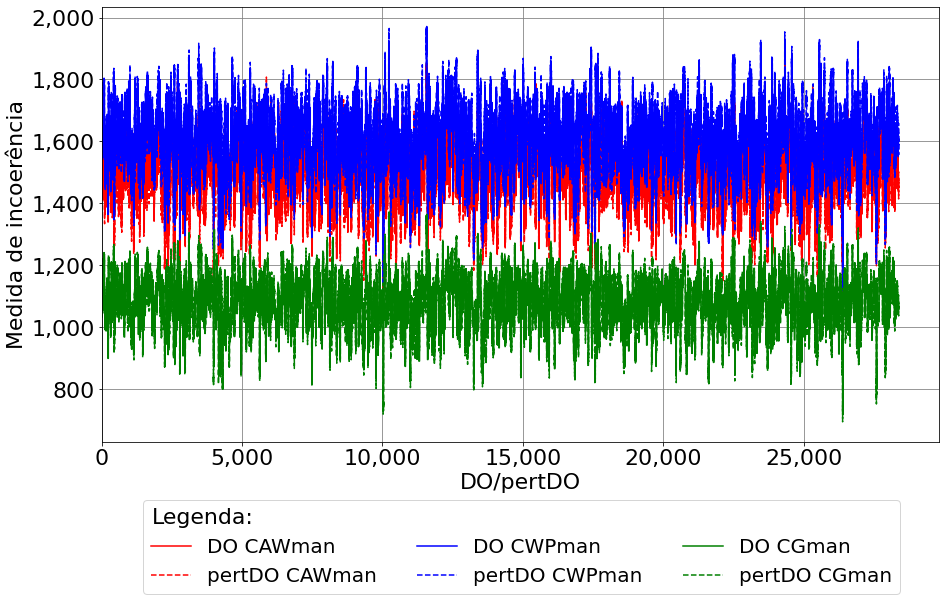

In [286]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW, 
                   lista_perturbado_CmanCAW, 
                   lista_original_CmanCWP, 
                   lista_perturbado_CmanCWP, 
                   lista_original_CmanCG, 
                   lista_perturbado_CmanCG,
                   medida = medida)

In [287]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCAW, lista_perturbado_CmanCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCWP, lista_perturbado_CmanCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CmanCG, lista_perturbado_CmanCG))

Diferença entre as equação CAW      : 992464.4106336217
Diferença entre as equação CWP      : 976460.5668094152
Diferença entre as equação CG       : 643167.1074404996


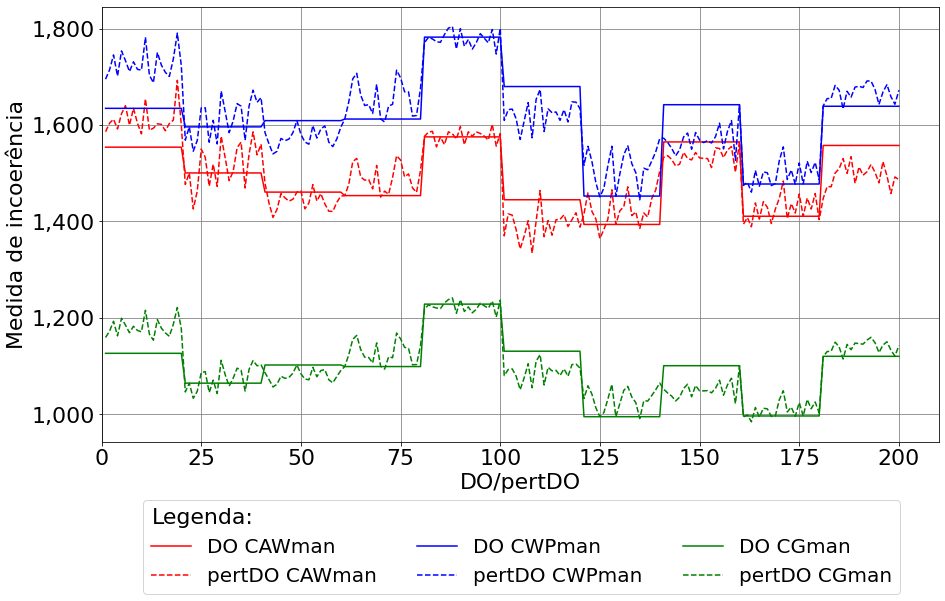

In [288]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:200], 
                   lista_perturbado_CmanCAW[0:200], 
                   lista_original_CmanCWP[0:200], 
                   lista_perturbado_CmanCWP[0:200], 
                   lista_original_CmanCG[0:200], 
                   lista_perturbado_CmanCG[0:200],
                   medida = medida)

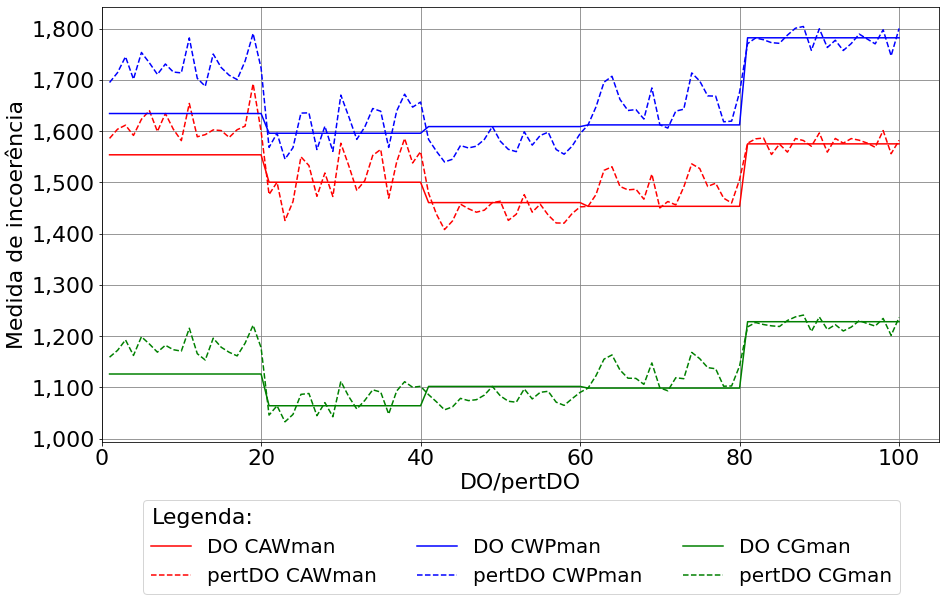

In [289]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:100], 
                   lista_perturbado_CmanCAW[0:100], 
                   lista_original_CmanCWP[0:100], 
                   lista_perturbado_CmanCWP[0:100], 
                   lista_original_CmanCG[0:100], 
                   lista_perturbado_CmanCG[0:100],
                   medida = medida)

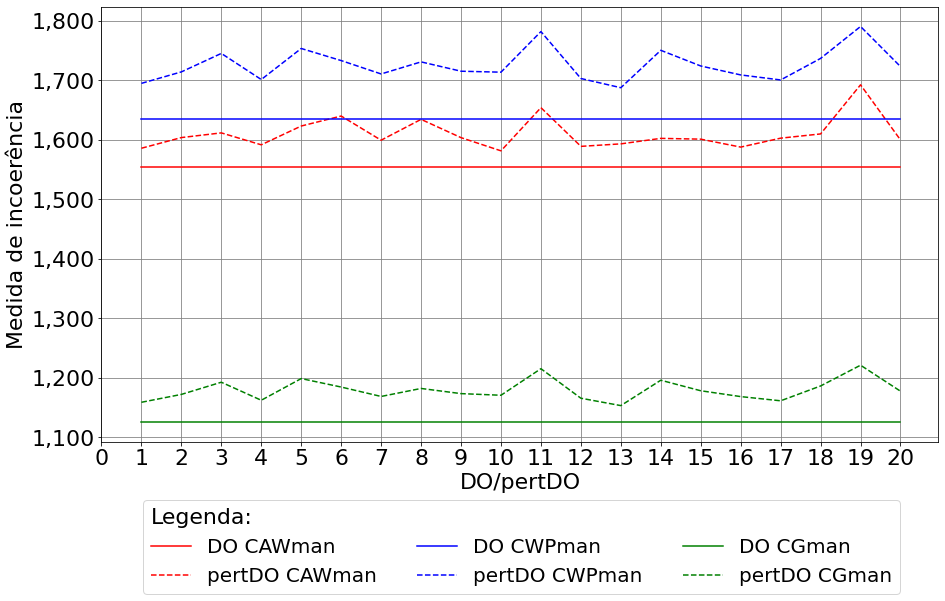

In [290]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_CmanCAW[0:20], 
                   lista_perturbado_CmanCAW[0:20], 
                   lista_original_CmanCWP[0:20], 
                   lista_perturbado_CmanCWP[0:20], 
                   lista_original_CmanCG[0:20], 
                   lista_perturbado_CmanCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações

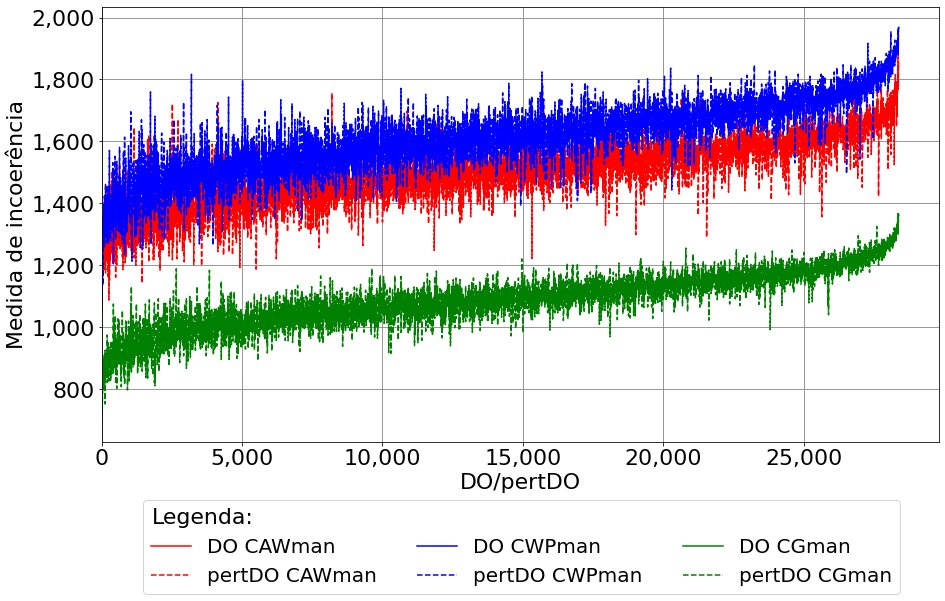

In [291]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CmanCAW, 
                   lista_perturbado_ordenado_CmanCAW, 
                   lista_original_ordenado_CmanCWP, 
                   lista_perturbado_ordenado_CmanCWP, 
                   lista_original_ordenado_CmanCG, 
                   lista_perturbado_ordenado_CmanCG,
                   medida = medida)

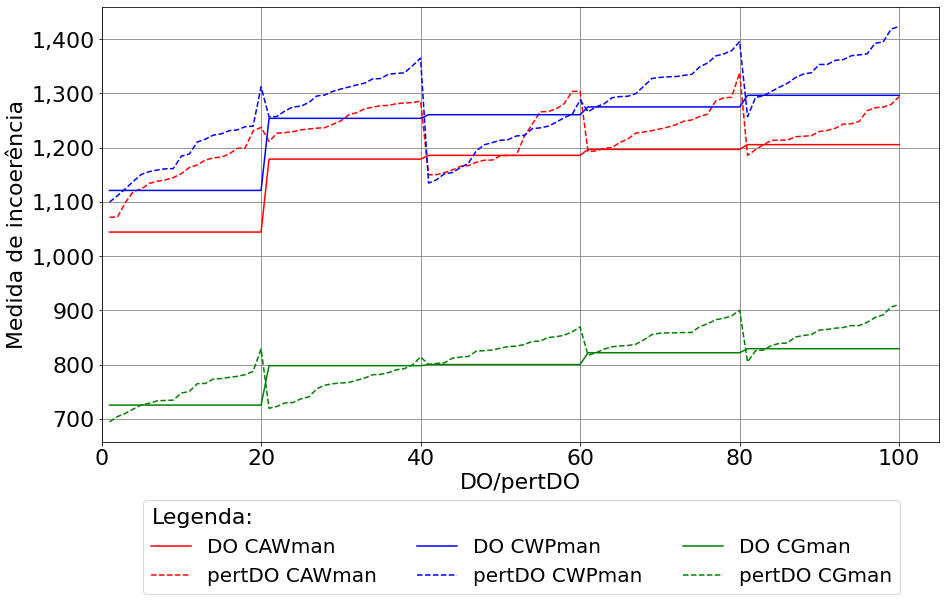

In [292]:
graficoLinhaMedida('Medida de incoerência', 
                   lista_original_ordenado_CmanCAW[0:100], 
                   lista_perturbado_ordenado_CmanCAW[0:100], 
                   lista_original_ordenado_CmanCWP[0:100], 
                   lista_perturbado_ordenado_CmanCWP[0:100], 
                   lista_original_ordenado_CmanCG[0:100], 
                   lista_perturbado_ordenado_CmanCG[0:100],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

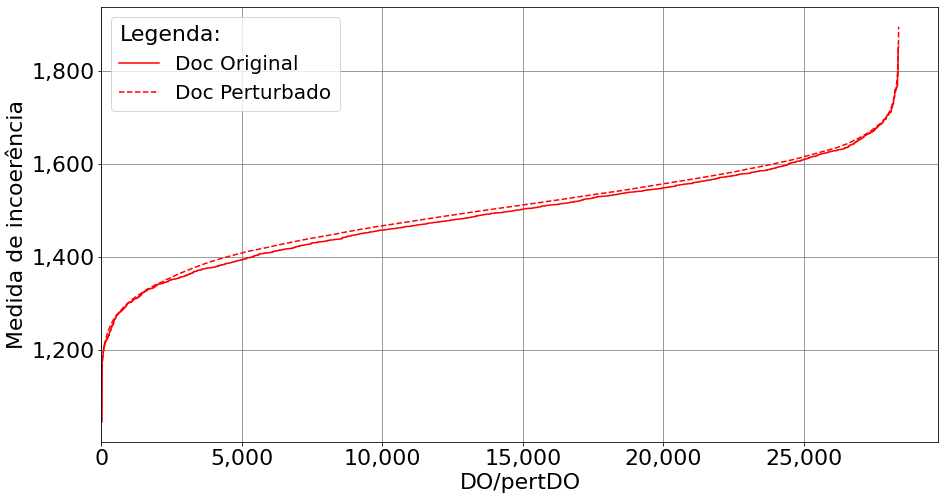

In [293]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_ordenado_CmanCAW, 
                    lista_perturbado_ordenado_CmanCAW,
                    'r',
                    medida = medida)

Sem ordem

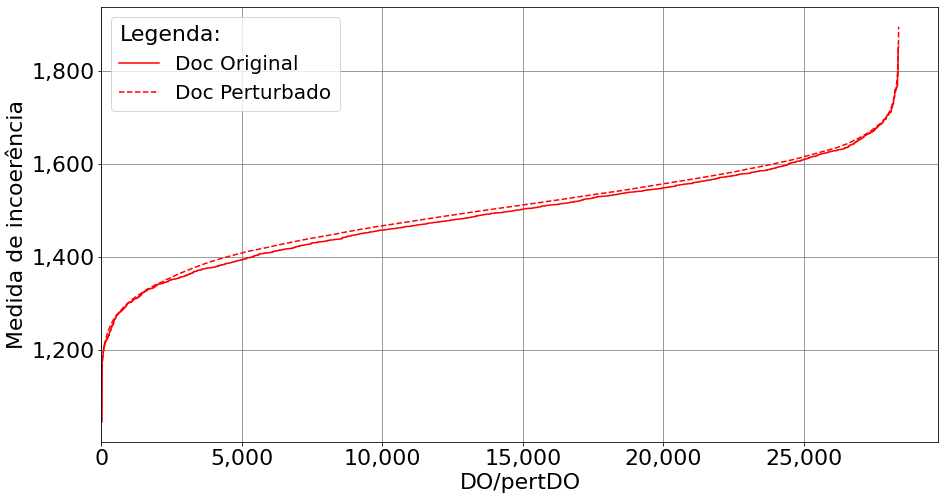

In [294]:
graficoLinhaMedida2('Medida de incoerência', 
                    lista_original_CmanCAW, 
                    lista_perturbado_CmanCAW,
                    'r',
                    medida = medida)

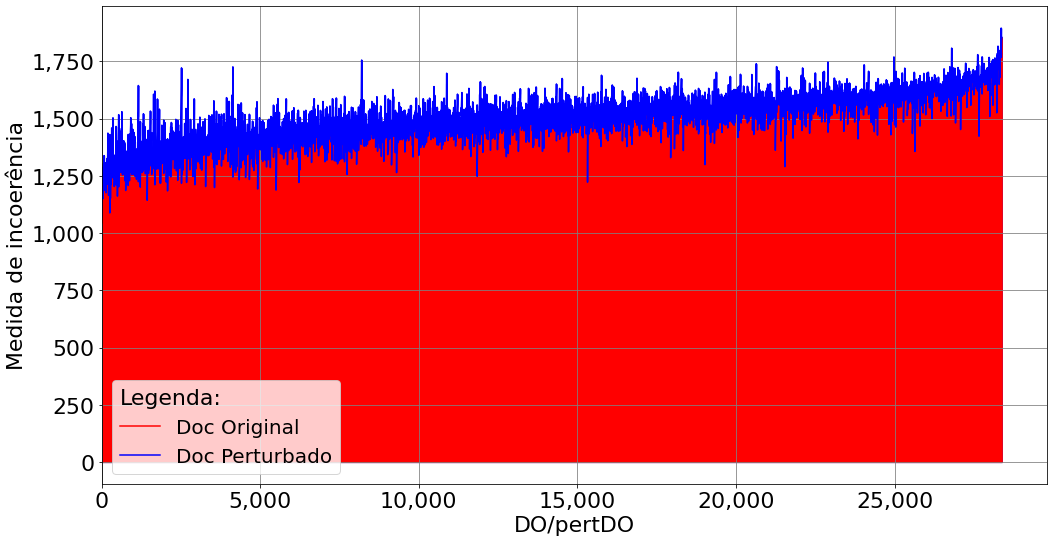

In [295]:
graficoLinhaMedida2Preenchido('Medida de incoerência', 
                              lista_original_ordenado_CmanCAW, 
                              lista_perturbado_ordenado_CmanCAW,
                              medida = 'man')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [296]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 992464.4106336217

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5a69ba4d5ce1a5001a9696c9', 97.85298000000193, 1369, 'Em que número de relatório ao Conselho o Procurador reconheceu que os crimes haviam sido cometidos, mas as evidências para a acusação eram suficientes?']
['5728f9a14b864d1900165160', 106.94625000000178, 1323, 'Em que dia a empresa que tocou a campainha pela primeira vez no inverno de 2014 em Mianmar abriu suas portas para os clientes?']
['5705eece75f01819005e778b', 107.29908571428268, 1311, 'Em 1817, o impressor do jornal The Times, James Lawson, passou seus negócios para qual membro da família?']
['5730bb522461fd1900a9d012', 120.57685999999876, 1153, 'a expansão dos EUA para o oeste poderia ser vista como que tipo de colonialismo?']
['5711488ab654c51400

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [297]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 617409.6185970668

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5725cadc38643c19005acd0e', 0.1420499999999265, 165, 'Quem organizou a flotilha?']
['572634a1271a42140099d75c', 1.1064999999994143, 974, 'A revolta de Orlov foi para qual suposto benefício de uma nação?']
['5ad2a316d7d075001a429d31', 2.0259000000000924, 1185, 'Em que dia a Nintendo não revelou os novos sistemas?']
['570e65050b85d914000d7e8b', 2.205238571428481, 158, 'Como foram oferecidos os primeiros textos sagrados?']
['5acfa71b77cf76001a68572d', 2.451541666666799, 1376, 'Que astronauta do DNA também é um aluno da U of C?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['570c2ef

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [298]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [299]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
  1 - De que forma os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> forma(CAWman(pertDO)=1421,8199200000)] - VERB/NOUN-0-0
  2 - De que maneira os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> maneira(CAWman(pertDO)=1426,2395000000)] - VERB/NOUN-0-0
  3 - De que tipo os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> tipo(CAWman(pertDO)=1481,9387200000)] - VERB/NOUN-0-0
  4 - De que participam os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> participam(CAWman(pertDO)=1492,7872800000)] - VERB/VERB-1-0
  5 - De que dependem os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> dependem(CAWman(pertDO)=1500,4133400000)] - VERB/VERB-1-0
  6 - De que tipos os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> tipos(CAWman(pertDO)=1500,4634400000)] - VERB/NOUN-0-0
  7 - De que falam os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> fal

In [300]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
5a4fe902af0d07001ae8cc7c_pert_0;De que servem os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;servem;VERB;1617,3590000000;1694,2843200000;1124,2425933333;0,1968212873;0;1
5a4fe902af0d07001ae8cc7c_pert_1;De que são os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;são;AUX;1543,6429000000;1661,7161933333;1097,6073833333;0,1718800962;0;0
5a4fe902af0d07001ae8cc7c_pert_2;De que vêm os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;vêm;VERB;1596,2350200000;1713,5547466667;1128,1667400000;0,1439927220;0;1
5a4fe902af0d07001ae8cc7c_pert_3;De que forma os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [301]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 375054.79203655623

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57270596708984140094d898', 0.5602291666668862, 1026, 'Além da desnutrição e da disseminação de doenças, qual é o exemplo de um problema de saúde que surgiu devido ao esgotamento ambiental?']
['5727acb32ca10214002d9364', 0.5826883333338628, 742, 'Quando o primeiro reator nuclear da Suíça está programado para ser desligado?']
['57324bd1b9d445190005e9dd', 0.5999454545453773, 844, 'Como as Testemunhas de Jeová se referem a seus serviços semanais?']
['56d12d3c17492d1400aabb6a', 0.6649555555559346, 612, 'Em que programa Adams parecia "se defender"?']
['56ddd58e66d3e219004dad0d', 0.7687071428

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [302]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [303]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a611ac3e9e1cc001a33cf1c
DO: O que substituiu objetos de metal?
     PRON PRON VERB NOUN ADP NOUN PUNCT 
  1 - O que são objetos de metal ? [substituiu(CAWman(DO)=1564,1268833333) -> são(>CAWman(pertDO)=1290,0205500000)] - VERB/AUX-0-0
  2 - O que envolve objetos de metal ? [substituiu(CAWman(DO)=1564,1268833333) -> envolve(>CAWman(pertDO)=1311,5107000000)] - VERB/VERB-1-0
  3 - O que eram objetos de metal ? [substituiu(CAWman(DO)=1564,1268833333) -> eram(>CAWman(pertDO)=1311,8672000000)] - VERB/AUX-0-0
  4 - O que seriam objetos de metal ? [substituiu(CAWman(DO)=1564,1268833333) -> seriam(>CAWman(pertDO)=1340,2152500000)] - VERB/AUX-0-0
  5 - O que representam objetos de metal ? [substituiu(CAWman(DO)=1564,1268833333) -> representam(>CAWman(pertDO)=1344,7438000000)] - VERB/VERB-1-0
  6 - O que sejam objetos de metal ? [substituiu(CAWman(DO)=1564,1268833333) -> sejam(>CAWman(pertDO)=1346,0701333333)] - VERB/VERB-1-0
  7 - O que representa objetos de metal ? [substituiu(CAWman(DO

In [304]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a611ac3e9e1cc001a33cf1c
DO: O que substituiu objetos de metal?
     PRON PRON VERB NOUN ADP NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
5a611ac3e9e1cc001a33cf1c_pert_0;O que são objetos de metal ?;substituiu;VERB;1564,1268833333;1611,7278666667;1054,4384771429;são;AUX;1290,0205500000;1412,3306142857;934,2878971429;0,9631913900;0;0
5a611ac3e9e1cc001a33cf1c_pert_1;O que seriam objetos de metal ?;substituiu;VERB;1564,1268833333;1611,7278666667;1054,4384771429;seriam;AUX;1340,2152500000;1440,6815885714;949,3483000000;0,0102391746;0;0
5a611ac3e9e1cc001a33cf1c_pert_2;O que é objetos de metal ?;substituiu;VERB;1564,1268833333;1611,7278666667;1054,4384771429;é;AUX;1435,9234000000;1552,2952476190;1023,1160500000;0,0059008105;0;0
5a611ac3e9e1cc001a33cf1c_pert_3;O que significa objetos de metal ?;substituiu;VERB;1564,1268833333;1611,72786

#### Usando CWP

In [305]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 976460.5668094152

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5a69ba4d5ce1a5001a9696c9', 86.44011446152876, 1378, 'Em que número de relatório ao Conselho o Procurador reconheceu que os crimes haviam sido cometidos, mas as evidências para a acusação eram suficientes?']
['56f76011a6d7ea1400e1721a', 94.91973245058853, 1393, 'Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido, em vez de invalidar completamente o consentimento?']
['5726d2ce5951b619008f7f19', 100.98505450000016, 917, 'Em que século foram usados detalhes góticos distintos em novas construções em Oxford e Cambridge?']
['5a0c96fbf5590b0018dab489', 144.99714575162966, 1349, 'Empreendimentos comerciais estão usando GPS portátil e mapas do Google para minar

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [306]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 597321.4445570735

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5ad3fdac604f3c001a3ffbf5', 1.0721662091502822, 1048, 'Que lei estadual diz que as sentenças de morte não devem ocorrer em um "recinto"?']
['572634a1271a42140099d75c', 1.5716487179486194, 1083, 'A revolta de Orlov foi para qual suposto benefício de uma nação?']
['572813642ca10214002d9d5e', 2.0663945454543864, 803, 'Quem fundou o teatro de comédia de Amsterdã Boom Chicago?']
['56cff91b234ae51400d9c1be', 2.2475933333344074, 429, 'Como os budistas acreditam que seu sofrimento pode acabar?']
['5acd177707355d001abf3456', 3.1084194444451896, 279, 'Qual é a força da cerveja em bares?']

Os 5

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [307]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [308]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
  1 - De que maneira os neutrófilos ? [resultam(>CWPman(DO)=1463,8395866667) -> maneira(CWPman(pertDO)=1508,6527466667)] - VERB/NOUN-0-0
  2 - De que forma os neutrófilos ? [resultam(>CWPman(DO)=1463,8395866667) -> forma(CWPman(pertDO)=1513,9867133333)] - VERB/NOUN-0-0
  3 - De que tipo os neutrófilos ? [resultam(>CWPman(DO)=1463,8395866667) -> tipo(CWPman(pertDO)=1541,1613600000)] - VERB/NOUN-0-0
  4 - De que tipos os neutrófilos ? [resultam(>CWPman(DO)=1463,8395866667) -> tipos(CWPman(pertDO)=1562,7208400000)] - VERB/NOUN-0-0
  5 - De que participam os neutrófilos ? [resultam(>CWPman(DO)=1463,8395866667) -> participam(CWPman(pertDO)=1572,5735466667)] - VERB/VERB-1-0
  6 - De que dependem os neutrófilos ? [resultam(>CWPman(DO)=1463,8395866667) -> dependem(CWPman(pertDO)=1572,6108400000)] - VERB/VERB-1-0
  7 - De que falam os neutrófilos ? [resultam(>CWPman(DO)=1463,8395866667) -> fal

In [309]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
5a4fe902af0d07001ae8cc7c_pert_0;De que servem os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;servem;VERB;1617,3590000000;1694,2843200000;1124,2425933333;0,1968212873;0;1
5a4fe902af0d07001ae8cc7c_pert_1;De que são os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;são;AUX;1543,6429000000;1661,7161933333;1097,6073833333;0,1718800962;0;0
5a4fe902af0d07001ae8cc7c_pert_2;De que vêm os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;vêm;VERB;1596,2350200000;1713,5547466667;1128,1667400000;0,1439927220;0;1
5a4fe902af0d07001ae8cc7c_pert_3;De que forma os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [310]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 379139.1222523407

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5a2ef31fa83784001a7d25cd', 0.36283555555564817, 567, 'Em que teatro da Broadway o Perfect Harmony abriu?']
['570da18bdf2f5219002ed078', 0.6253909090914931, 542, 'Quando a Lei de Conservação Antártica foi aprovada pelos EUA?']
['572808863acd2414000df2d9', 0.8789333333329523, 931, 'O intervalo invariável que separa dois eventos no espaço-tempo de Minkowski pode ser o quê?']
['57302590b2c2fd140056896d', 0.9919022222220519, 549, 'Em que ano a constituição da Suazilândia foi suspensa?']
['5a516183ce860b001aa3fd77', 1.4410363235267596, 1149, 'Qual artigo afirmava que, se uma petição fosse 

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [311]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [312]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 572933aa3f37b319004780fa
DO: Qual é o vértice também conhecido como?
     PRON AUX DET NOUN ADV VERB ADP PUNCT 
  1 - Qual é o vértice também : como ? [conhecido(CWPman(DO)=1756,5623035714) -> :(>CWPman(pertDO)=1495,5884142857)] - VERB/PUNCT-0-0
  2 - Qual é o vértice também , como ? [conhecido(CWPman(DO)=1756,5623035714) -> ,(>CWPman(pertDO)=1496,3360500000)] - VERB/PUNCT-0-0
  3 - Qual é o vértice também ; como ? [conhecido(CWPman(DO)=1756,5623035714) -> ;(>CWPman(pertDO)=1500,1427250000)] - VERB/PUNCT-0-0
  4 - Qual é o vértice também e como ? [conhecido(CWPman(DO)=1756,5623035714) -> e(>CWPman(pertDO)=1507,4007071429)] - VERB/CCONJ-0-0
  5 - Qual é o vértice também sabe como ? [conhecido(CWPman(DO)=1756,5623035714) -> sabe(>CWPman(pertDO)=1509,5081464286)] - VERB/VERB-1-0
  6 - Qual é o vértice também tem como ? [conhecido(CWPman(DO)=1756,5623035714) -> tem(>CWPman(pertDO)=1509,6394928571)] - VERB/VERB-1-0
  7 - Qual é o vértice também é como ? [conhecido(CWPman(DO)=1756,562

In [313]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 572933aa3f37b319004780fa
DO: Qual é o vértice também conhecido como?
     PRON AUX DET NOUN ADV VERB ADP PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
572933aa3f37b319004780fa_pert_0;Qual é o vértice também e como ?;conhecido;VERB;1589,2570857143;1756,5623035714;1165,2717700000;e;CCONJ;1444,9054857143;1507,4007071429;998,9809237500;0,5633524656;0;0
572933aa3f37b319004780fa_pert_1;Qual é o vértice também , como ?;conhecido;VERB;1589,2570857143;1756,5623035714;1165,2717700000;,;PUNCT;1427,7153428571;1496,3360500000;992,2224662500;0,1817247123;0;0
572933aa3f37b319004780fa_pert_2;Qual é o vértice também ou como ?;conhecido;VERB;1589,2570857143;1756,5623035714;1165,2717700000;ou;CCONJ;1510,0754000000;1552,8230642857;1029,9190575000;0,0503703803;0;0
572933aa3f37b319004780fa_pert_3;Qual é o vértice também ? como ?;conhecido;VERB;1589,25708571

#### Usando CG

In [314]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 643167.1074404996

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5a69ba4d5ce1a5001a9696c9', 57.86490269230876, 1387, 'Em que número de relatório ao Conselho o Procurador reconheceu que os crimes haviam sido cometidos, mas as evidências para a acusação eram suficientes?']
['56f76011a6d7ea1400e1721a', 58.612570869564706, 1400, 'Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido, em vez de invalidar completamente o consentimento?']
['5726d2ce5951b619008f7f19', 70.42877874999999, 956, 'Em que século foram usados detalhes góticos distintos em novas construções em Oxford e Cambridge?']
['57265737708984140094c2fb', 95.37913049999815, 1351, "Quando a OMPI adotou 'A Declaração de Genebra sobre o Futuro da Organização Mundial 

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [315]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 387038.80272010237

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5ad25ed0d7d075001a428f46', 0.02964125000016793, 547, 'Quais cidadãos britânicos estabeleceram Grtviken na Antártica?']
['572a0ce11d046914007796fe', 0.057326000000102795, 656, 'Que bactéria alimentar é um exemplo de patogênese intracelular?']
['56cff91b234ae51400d9c1be', 0.16118900000014946, 384, 'Como os budistas acreditam que seu sofrimento pode acabar?']
['5a81fbf231013a001a335043', 0.37278875000004064, 155, 'Quais são as análises harmônicas estudadas usando?']
['572634a1271a42140099d75c', 0.7159492307694109, 1069, 'A revolta de Orlov foi para qual suposto benefício de uma nação?']


Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [316]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [317]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
  1 - De que maneira os neutrófilos ? [resultam(>CGman(DO)=967,4537933333) -> maneira(CGman(pertDO)=1005,4323383333)] - VERB/NOUN-0-0
  2 - De que forma os neutrófilos ? [resultam(>CGman(DO)=967,4537933333) -> forma(CGman(pertDO)=1008,3889283333)] - VERB/NOUN-0-0
  3 - De que tipo os neutrófilos ? [resultam(>CGman(DO)=967,4537933333) -> tipo(CGman(pertDO)=1026,2376283333)] - VERB/NOUN-0-0
  4 - De que tipos os neutrófilos ? [resultam(>CGman(DO)=967,4537933333) -> tipos(CGman(pertDO)=1039,4765750000)] - VERB/NOUN-0-0
  5 - De que participam os neutrófilos ? [resultam(>CGman(DO)=967,4537933333) -> participam(CGman(pertDO)=1039,5359000000)] - VERB/VERB-1-0
  6 - De que falam os neutrófilos ? [resultam(>CGman(DO)=967,4537933333) -> falam(CGman(pertDO)=1046,1022600000)] - VERB/VERB-1-0
  7 - De que dependem os neutrófilos ? [resultam(>CGman(DO)=967,4537933333) -> dependem(CGman(pertDO)=104

In [318]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
5a4fe902af0d07001ae8cc7c_pert_0;De que servem os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;servem;VERB;1617,3590000000;1694,2843200000;1124,2425933333;0,1968212873;0;1
5a4fe902af0d07001ae8cc7c_pert_1;De que são os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;são;AUX;1543,6429000000;1661,7161933333;1097,6073833333;0,1718800962;0;0
5a4fe902af0d07001ae8cc7c_pert_2;De que vêm os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;vêm;VERB;1596,2350200000;1713,5547466667;1128,1667400000;0,1439927220;0;1
5a4fe902af0d07001ae8cc7c_pert_3;De que forma os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [319]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 256128.3047203959

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56dde0a49a695914005b963a', 0.03789769230752427, 422, 'Em que país as escolas politécnicas são designadas exclusivamente pelas universidades acadêmicas?']
['572923981d046914007790b0', 0.21198624999999538, 81, 'Que método é usado para criar janelas?']
['5ad257e8d7d075001a428da1', 0.2184169999995902, 175, 'O que Hobart não queria que os frades alcançassem?']
['5ad30e3b604f3c001a3fdb12', 0.21969100000001163, 184, 'Quem estava matriculado apenas na ordem dos cardeais leigos?']
['56d4d2232ccc5a1400d83263', 0.3504144444443682, 891, 'Como Beyoncé e Jay Z nomearam sua filha?']

Os 5 últimos DOs

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [320]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [321]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 572933aa3f37b319004780fa
DO: Qual é o vértice também conhecido como?
     PRON AUX DET NOUN ADV VERB ADP PUNCT 
  1 - Qual é o vértice também , como ? [conhecido(CGman(DO)=1165,2717700000) -> ,(>CGman(pertDO)=992,2224662500)] - VERB/PUNCT-0-0
  2 - Qual é o vértice também : como ? [conhecido(CGman(DO)=1165,2717700000) -> :(>CGman(pertDO)=993,2860437500)] - VERB/PUNCT-0-0
  3 - Qual é o vértice também ; como ? [conhecido(CGman(DO)=1165,2717700000) -> ;(>CGman(pertDO)=995,4723250000)] - VERB/PUNCT-0-0
  4 - Qual é o vértice também e como ? [conhecido(CGman(DO)=1165,2717700000) -> e(>CGman(pertDO)=998,9809237500)] - VERB/CCONJ-0-0
  5 - Qual é o vértice também sabe como ? [conhecido(CGman(DO)=1165,2717700000) -> sabe(>CGman(pertDO)=1003,6683912500)] - VERB/VERB-1-0
  6 - Qual é o vértice também tem como ? [conhecido(CGman(DO)=1165,2717700000) -> tem(>CGman(pertDO)=1005,8065062500)] - VERB/VERB-1-0
  7 - Qual é o vértice também é como ? [conhecido(CGman(DO)=1165,2717700000) -> é(>CG

In [322]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 572933aa3f37b319004780fa
DO: Qual é o vértice também conhecido como?
     PRON AUX DET NOUN ADV VERB ADP PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
572933aa3f37b319004780fa_pert_0;Qual é o vértice também e como ?;conhecido;VERB;1589,2570857143;1756,5623035714;1165,2717700000;e;CCONJ;1444,9054857143;1507,4007071429;998,9809237500;0,5633524656;0;0
572933aa3f37b319004780fa_pert_1;Qual é o vértice também , como ?;conhecido;VERB;1589,2570857143;1756,5623035714;1165,2717700000;,;PUNCT;1427,7153428571;1496,3360500000;992,2224662500;0,1817247123;0;0
572933aa3f37b319004780fa_pert_2;Qual é o vértice também ou como ?;conhecido;VERB;1589,2570857143;1756,5623035714;1165,2717700000;ou;CCONJ;1510,0754000000;1552,8230642857;1029,9190575000;0,0503703803;0;0
572933aa3f37b319004780fa_pert_3;Qual é o vértice também ? como ?;conhecido;VERB;1589,25708571

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [323]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 256128.3047203959

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5705eece75f01819005e778b', 15.748980952381089, 1311, 'Em 1817, o impressor do jornal The Times, James Lawson, passou seus negócios para qual membro da família?']
['5a0c96fbf5590b0018dab489', 17.796811764705353, 1192, 'Empreendimentos comerciais estão usando GPS portátil e mapas do Google para minar as tribos indígenas o que?']
['5730bb522461fd1900a9d012', 18.172186666666903, 1153, 'a expansão dos EUA para o oeste poderia ser vista como que tipo de colonialismo?']
['5a79ce7517ab25001a8a008d', 19.023147058823497, 796, 'Que organização disse que existem conexões históricas para associar o futebol a outros jogos fora da Europa?']
['5a69ba4d5ce1a5001a9696c9',

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [324]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 256128.3047203959

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5725cadc38643c19005acd0e', 0.1420499999999265, 165, 'Quem organizou a flotilha?']
['572634a1271a42140099d75c', 1.1064999999994143, 974, 'A revolta de Orlov foi para qual suposto benefício de uma nação?']
['5ad2a316d7d075001a429d31', 2.0259000000000924, 1185, 'Em que dia a Nintendo não revelou os novos sistemas?']
['570e65050b85d914000d7e8b', 2.205238571428481, 158, 'Como foram oferecidos os primeiros textos sagrados?']
['5acfa71b77cf76001a68572d', 2.451541666666799, 1376, 'Que astronauta do DNA também é um aluno da U of C?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5706cfe02eaba6190

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [325]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [326]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
  1 - De que forma os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> forma(CAWman(pertDO)=1421,8199200000)] - VERB/NOUN-0-0
  2 - De que maneira os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> maneira(CAWman(pertDO)=1426,2395000000)] - VERB/NOUN-0-0
  3 - De que tipo os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> tipo(CAWman(pertDO)=1481,9387200000)] - VERB/NOUN-0-0
  4 - De que participam os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> participam(CAWman(pertDO)=1492,7872800000)] - VERB/VERB-1-0
  5 - De que dependem os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> dependem(CAWman(pertDO)=1500,4133400000)] - VERB/VERB-1-0
  6 - De que tipos os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> tipos(CAWman(pertDO)=1500,4634400000)] - VERB/NOUN-0-0
  7 - De que falam os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> fal

In [327]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
5a4fe902af0d07001ae8cc7c_pert_0;De que servem os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;servem;VERB;1617,3590000000;1694,2843200000;1124,2425933333;0,1968212873;0;1
5a4fe902af0d07001ae8cc7c_pert_1;De que são os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;são;AUX;1543,6429000000;1661,7161933333;1097,6073833333;0,1718800962;0;0
5a4fe902af0d07001ae8cc7c_pert_2;De que vêm os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;vêm;VERB;1596,2350200000;1713,5547466667;1128,1667400000;0,1439927220;0;1
5a4fe902af0d07001ae8cc7c_pert_3;De que forma os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [328]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 256128.3047203959

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['57270596708984140094d898', 0.5602291666668862, 1026, 'Além da desnutrição e da disseminação de doenças, qual é o exemplo de um problema de saúde que surgiu devido ao esgotamento ambiental?']
['5727acb32ca10214002d9364', 0.5826883333338628, 742, 'Quando o primeiro reator nuclear da Suíça está programado para ser desligado?']
['57324bd1b9d445190005e9dd', 0.5999454545453773, 844, 'Como as Testemunhas de Jeová se referem a seus serviços semanais?']
['56d12d3c17492d1400aabb6a', 0.6649555555559346, 612, 'Em que programa Adams parecia "se defender"?']
['56ddd58e66d3e219004dad0d', 0.7687071428572381, 112

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [329]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [330]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 570ff55ab654c5140001f6f0
DO: Quem Demarcus Sears sequestrou?
     PRON PROPN PROPN VERB PUNCT 
  1 - Quem Demarcus Sears ? ? [sequestrou(CAWman(DO)=1504,6030000000) -> ?(>CAWman(pertDO)=1222,2382000000)] - VERB/PUNCT-0-0
  2 - Quem Demarcus Sears " ? [sequestrou(CAWman(DO)=1504,6030000000) -> "(>CAWman(pertDO)=1340,3060750000)] - VERB/PUNCT-0-0
  3 - Quem Demarcus Sears foi ? [sequestrou(CAWman(DO)=1504,6030000000) -> foi(>CAWman(pertDO)=1354,8085250000)] - VERB/AUX-0-0
  4 - Quem Demarcus Sears é ? [sequestrou(CAWman(DO)=1504,6030000000) -> é(>CAWman(pertDO)=1360,8571250000)] - VERB/AUX-0-0
  5 - Quem Demarcus Sears era ? [sequestrou(CAWman(DO)=1504,6030000000) -> era(>CAWman(pertDO)=1369,3174750000)] - VERB/AUX-0-0
  6 - Quem Demarcus Sears t ? [sequestrou(CAWman(DO)=1504,6030000000) -> t(>CAWman(pertDO)=1369,9410250000)] - VERB/PROPN-0-0
  7 - Quem Demarcus Sears será ? [sequestrou(CAWman(DO)=1504,6030000000) -> será(>CAWman(pertDO)=1388,1888250000)] - VERB/AUX-0-0
  8 - Quem

In [331]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 570ff55ab654c5140001f6f0
DO: Quem Demarcus Sears sequestrou?
     PRON PROPN PROPN VERB PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
570ff55ab654c5140001f6f0_pert_0;Quem Demarcus Sears é ?;sequestrou;VERB;1504,6030000000;1524,6639600000;986,8458860000;é;AUX;1360,8571250000;1389,8187600000;928,7477600000;0,1901453286;0;0
570ff55ab654c5140001f6f0_pert_1;Quem Demarcus Sears on ?;sequestrou;VERB;1504,6030000000;1524,6639600000;986,8458860000;on;PROPN;1481,9390250000;1543,7283800000;985,9053340000;0,0605522916;0;0
570ff55ab654c5140001f6f0_pert_2;Quem Demarcus Sears foi ?;sequestrou;VERB;1504,6030000000;1524,6639600000;986,8458860000;foi;AUX;1354,8085250000;1376,4853100000;914,9667100000;0,0403242148;0;0
570ff55ab654c5140001f6f0_pert_3;Quem Demarcus Sears era ?;sequestrou;VERB;1504,6030000000;1524,6639600000;986,8458860000;era;AUX;1369,3174

#### Usando CWP






In [332]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 256128.3047203959

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56f76011a6d7ea1400e1721a', 10.761040988142895, 1393, 'Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido, em vez de invalidar completamente o consentimento?']
['5726d2ce5951b619008f7f19', 12.54519583333331, 917, 'Em que século foram usados detalhes góticos distintos em novas construções em Oxford e Cambridge?']
['5a69ba4d5ce1a5001a9696c9', 15.11060123076686, 1378, 'Em que número de relatório ao Conselho o Procurador reconheceu que os crimes haviam sido cometidos, mas as evidências para a acusação eram suficientes?']
['5730bb522461fd1900a9d012', 16.795623333334333, 1286, 'a expansão dos EUA para o oeste

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [333]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 256128.3047203959

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5ad3fdac604f3c001a3ffbf5', 1.0721662091502822, 1048, 'Que lei estadual diz que as sentenças de morte não devem ocorrer em um "recinto"?']
['572634a1271a42140099d75c', 1.5716487179486194, 1083, 'A revolta de Orlov foi para qual suposto benefício de uma nação?']
['56cff91b234ae51400d9c1be', 2.0346644444450703, 429, 'Como os budistas acreditam que seu sofrimento pode acabar?']
['572813642ca10214002d9d5e', 2.0663945454543864, 803, 'Quem fundou o teatro de comédia de Amsterdã Boom Chicago?']
['5a8308fde60761001a2eb320', 2.6181745454543943, 613, 'O que um agente infeccioso deve evitar para causar doenç

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [334]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [335]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
  1 - De que forma os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> forma(CAWman(pertDO)=1421,8199200000)] - VERB/NOUN-0-0
  2 - De que maneira os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> maneira(CAWman(pertDO)=1426,2395000000)] - VERB/NOUN-0-0
  3 - De que tipo os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> tipo(CAWman(pertDO)=1481,9387200000)] - VERB/NOUN-0-0
  4 - De que participam os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> participam(CAWman(pertDO)=1492,7872800000)] - VERB/VERB-1-0
  5 - De que dependem os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> dependem(CAWman(pertDO)=1500,4133400000)] - VERB/VERB-1-0
  6 - De que tipos os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> tipos(CAWman(pertDO)=1500,4634400000)] - VERB/NOUN-0-0
  7 - De que falam os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> fal

In [336]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
5a4fe902af0d07001ae8cc7c_pert_0;De que servem os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;servem;VERB;1617,3590000000;1694,2843200000;1124,2425933333;0,1968212873;0;1
5a4fe902af0d07001ae8cc7c_pert_1;De que são os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;são;AUX;1543,6429000000;1661,7161933333;1097,6073833333;0,1718800962;0;0
5a4fe902af0d07001ae8cc7c_pert_2;De que vêm os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;vêm;VERB;1596,2350200000;1713,5547466667;1128,1667400000;0,1439927220;0;1
5a4fe902af0d07001ae8cc7c_pert_3;De que forma os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [337]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 256128.3047203959

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5a2ef31fa83784001a7d25cd', 0.36283555555564817, 567, 'Em que teatro da Broadway o Perfect Harmony abriu?']
['570da18bdf2f5219002ed078', 0.6253909090914931, 542, 'Quando a Lei de Conservação Antártica foi aprovada pelos EUA?']
['572808863acd2414000df2d9', 0.8789333333329523, 931, 'O intervalo invariável que separa dois eventos no espaço-tempo de Minkowski pode ser o quê?']
['57302590b2c2fd140056896d', 0.9919022222220519, 549, 'Em que ano a constituição da Suazilândia foi suspensa?']
['5a516183ce860b001aa3fd77', 1.4410363235267596, 1149, 'Qual artigo afirmava que, se uma petição fosse bem-sucedida,

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [338]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [339]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 572933aa3f37b319004780fa
DO: Qual é o vértice também conhecido como?
     PRON AUX DET NOUN ADV VERB ADP PUNCT 
  1 - Qual é o vértice também tem como ? [conhecido(CAWman(DO)=1589,2570857143) -> tem(>CAWman(pertDO)=1411,1614000000)] - VERB/VERB-1-0
  2 - Qual é o vértice também sabe como ? [conhecido(CAWman(DO)=1589,2570857143) -> sabe(>CAWman(pertDO)=1418,0917714286)] - VERB/VERB-1-0
  3 - Qual é o vértice também ; como ? [conhecido(CAWman(DO)=1589,2570857143) -> ;(>CAWman(pertDO)=1419,3925142857)] - VERB/PUNCT-0-0
  4 - Qual é o vértice também mas como ? [conhecido(CAWman(DO)=1589,2570857143) -> mas(>CAWman(pertDO)=1423,2223857143)] - VERB/CCONJ-0-0
  5 - Qual é o vértice também funciona como ? [conhecido(CAWman(DO)=1589,2570857143) -> funciona(>CAWman(pertDO)=1423,2544142857)] - VERB/VERB-1-0
  6 - Qual é o vértice também : como ? [conhecido(CAWman(DO)=1589,2570857143) -> :(>CAWman(pertDO)=1424,0260571429)] - VERB/PUNCT-0-0
  7 - Qual é o vértice também é como ? [conhecido(CA

In [340]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 572933aa3f37b319004780fa
DO: Qual é o vértice também conhecido como?
     PRON AUX DET NOUN ADV VERB ADP PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
572933aa3f37b319004780fa_pert_0;Qual é o vértice também e como ?;conhecido;VERB;1589,2570857143;1756,5623035714;1165,2717700000;e;CCONJ;1444,9054857143;1507,4007071429;998,9809237500;0,5633524656;0;0
572933aa3f37b319004780fa_pert_1;Qual é o vértice também , como ?;conhecido;VERB;1589,2570857143;1756,5623035714;1165,2717700000;,;PUNCT;1427,7153428571;1496,3360500000;992,2224662500;0,1817247123;0;0
572933aa3f37b319004780fa_pert_2;Qual é o vértice também ou como ?;conhecido;VERB;1589,2570857143;1756,5623035714;1165,2717700000;ou;CCONJ;1510,0754000000;1552,8230642857;1029,9190575000;0,0503703803;0;0
572933aa3f37b319004780fa_pert_3;Qual é o vértice também ? como ?;conhecido;VERB;1589,25708571

#### Usando CG






In [341]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 256128.3047203959

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56f76011a6d7ea1400e1721a', 8.088523913042991, 1400, 'Quais processos simplesmente alteram o consentimento dado pelas partes em um tratado previamente válido, em vez de invalidar completamente o consentimento?']
['5726d2ce5951b619008f7f19', 8.491993124999908, 956, 'Em que século foram usados detalhes góticos distintos em novas construções em Oxford e Cambridge?']
['5a69ba4d5ce1a5001a9696c9', 9.461246153846105, 1387, 'Em que número de relatório ao Conselho o Procurador reconheceu que os crimes haviam sido cometidos, mas as evidências para a acusação eram suficientes?']
['5730bb522461fd1900a9d012', 11.081072499999891, 1280, 'a expansão dos EUA para o oeste po

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [342]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 256128.3047203959

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5ad25ed0d7d075001a428f46', 0.02964125000016793, 547, 'Quais cidadãos britânicos estabeleceram Grtviken na Antártica?']
['572a0ce11d046914007796fe', 0.057326000000102795, 656, 'Que bactéria alimentar é um exemplo de patogênese intracelular?']
['56cff91b234ae51400d9c1be', 0.16118900000014946, 384, 'Como os budistas acreditam que seu sofrimento pode acabar?']
['5a81fbf231013a001a335043', 0.37278875000004064, 155, 'Quais são as análises harmônicas estudadas usando?']
['572634a1271a42140099d75c', 0.4850800000001527, 1069, 'A revolta de Orlov foi para qual suposto benefício de uma nação?']

Os 5 últimos 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [343]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [344]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
  1 - De que forma os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> forma(CAWman(pertDO)=1421,8199200000)] - VERB/NOUN-0-0
  2 - De que maneira os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> maneira(CAWman(pertDO)=1426,2395000000)] - VERB/NOUN-0-0
  3 - De que tipo os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> tipo(CAWman(pertDO)=1481,9387200000)] - VERB/NOUN-0-0
  4 - De que participam os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> participam(CAWman(pertDO)=1492,7872800000)] - VERB/VERB-1-0
  5 - De que dependem os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> dependem(CAWman(pertDO)=1500,4133400000)] - VERB/VERB-1-0
  6 - De que tipos os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> tipos(CAWman(pertDO)=1500,4634400000)] - VERB/NOUN-0-0
  7 - De que falam os neutrófilos ? [resultam(>CAWman(DO)=1351,1151600000) -> fal

In [345]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 5a4fe902af0d07001ae8cc7c
DO: De que resultam os neutrófilos?
     ADP PRON VERB DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
5a4fe902af0d07001ae8cc7c_pert_0;De que servem os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;servem;VERB;1617,3590000000;1694,2843200000;1124,2425933333;0,1968212873;0;1
5a4fe902af0d07001ae8cc7c_pert_1;De que são os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;são;AUX;1543,6429000000;1661,7161933333;1097,6073833333;0,1718800962;0;0
5a4fe902af0d07001ae8cc7c_pert_2;De que vêm os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333;vêm;VERB;1596,2350200000;1713,5547466667;1128,1667400000;0,1439927220;0;1
5a4fe902af0d07001ae8cc7c_pert_3;De que forma os neutrófilos ?;resultam;VERB;1351,1151600000;1463,8395866667;967,4537933333

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [346]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 256128.3047203959

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['56dde0a49a695914005b963a', 0.03789769230752427, 422, 'Em que país as escolas politécnicas são designadas exclusivamente pelas universidades acadêmicas?']
['572923981d046914007790b0', 0.21198624999999538, 81, 'Que método é usado para criar janelas?']
['5ad257e8d7d075001a428da1', 0.2184169999995902, 175, 'O que Hobart não queria que os frades alcançassem?']
['5ad30e3b604f3c001a3fdb12', 0.21969100000001163, 184, 'Quem estava matriculado apenas na ordem dos cardeais leigos?']
['56d4d2232ccc5a1400d83263', 0.3504144444443682, 891, 'Como Beyoncé e Jay Z nomearam sua filha?']

Os 5 últimos DOs
id_DO, difab

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [347]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [348]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 572933aa3f37b319004780fa
DO: Qual é o vértice também conhecido como?
     PRON AUX DET NOUN ADV VERB ADP PUNCT 
  1 - Qual é o vértice também tem como ? [conhecido(CAWman(DO)=1589,2570857143) -> tem(>CAWman(pertDO)=1411,1614000000)] - VERB/VERB-1-0
  2 - Qual é o vértice também sabe como ? [conhecido(CAWman(DO)=1589,2570857143) -> sabe(>CAWman(pertDO)=1418,0917714286)] - VERB/VERB-1-0
  3 - Qual é o vértice também ; como ? [conhecido(CAWman(DO)=1589,2570857143) -> ;(>CAWman(pertDO)=1419,3925142857)] - VERB/PUNCT-0-0
  4 - Qual é o vértice também mas como ? [conhecido(CAWman(DO)=1589,2570857143) -> mas(>CAWman(pertDO)=1423,2223857143)] - VERB/CCONJ-0-0
  5 - Qual é o vértice também funciona como ? [conhecido(CAWman(DO)=1589,2570857143) -> funciona(>CAWman(pertDO)=1423,2544142857)] - VERB/VERB-1-0
  6 - Qual é o vértice também : como ? [conhecido(CAWman(DO)=1589,2570857143) -> :(>CAWman(pertDO)=1424,0260571429)] - VERB/PUNCT-0-0
  7 - Qual é o vértice também é como ? [conhecido(CA

In [349]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 572933aa3f37b319004780fa
DO: Qual é o vértice também conhecido como?
     PRON AUX DET NOUN ADV VERB ADP PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
572933aa3f37b319004780fa_pert_0;Qual é o vértice também e como ?;conhecido;VERB;1589,2570857143;1756,5623035714;1165,2717700000;e;CCONJ;1444,9054857143;1507,4007071429;998,9809237500;0,5633524656;0;0
572933aa3f37b319004780fa_pert_1;Qual é o vértice também , como ?;conhecido;VERB;1589,2570857143;1756,5623035714;1165,2717700000;,;PUNCT;1427,7153428571;1496,3360500000;992,2224662500;0,1817247123;0;0
572933aa3f37b319004780fa_pert_2;Qual é o vértice também ou como ?;conhecido;VERB;1589,2570857143;1756,5623035714;1165,2717700000;ou;CCONJ;1510,0754000000;1552,8230642857;1029,9190575000;0,0503703803;0;0
572933aa3f37b319004780fa_pert_3;Qual é o vértice também ? como ?;conhecido;VERB;1589,25708571

# 4 Finalização

## 4.1 Tempo final de processamento



In [350]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))


  Tempo processamento:  0:07:58 (h:mm:ss)
